## imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from prediction_pipeline.preprocessing import *
#from prediction_pipeline.build_sysmex_features import *
#from prediction_pipeline.training import *
#from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.linear_model import LinearRegression
#from matplotlib.patches import Patch
%load_ext cython
from bgen.reader import BgenFile
import subprocess
from scipy.stats import binom_test,mannwhitneyu, pearsonr
from sklearn.preprocessing import quantile_transform
from scipy.signal import correlate

In [2]:
#data_dir = "/Users/hippolyte/sysmex2pf/data"
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
training_data = "%s/training_exports" % data_dir
#FACS_cols = ["FSC","SSC","SFL","FSCW"]
FACS_cols = ["FSC","SSC","SFL"]
pheno_cols = ["ADP_FIB","CRP_FIB","TRAP_FIB","PAR1_FIB","PAR4_FIB","FIB"]
#pheno_cols = ["ADP","CRP","TRAP","PAR1","PAR4"]
covar_cols = ["MPV","PLT","PCT","PDW","IPF","Age","Sex"] 
EUR_path = "%s/genetic_score/EUR" % export_folder

# Load Sysmex data of PFC cohort

We load Sysmex data (cell-level measurements) and phenotypes (MPV, PLT, etc...)

## phenotypes

In [3]:
sys_phen = load_sys_phenotypes(data_dir)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


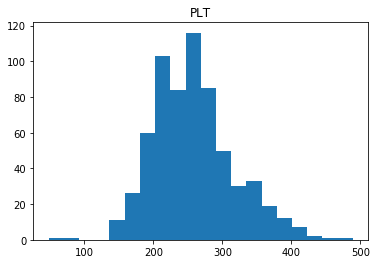

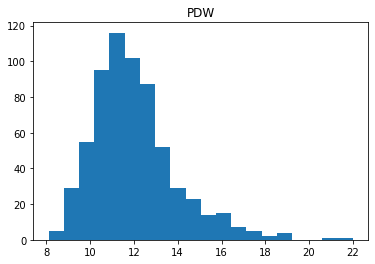

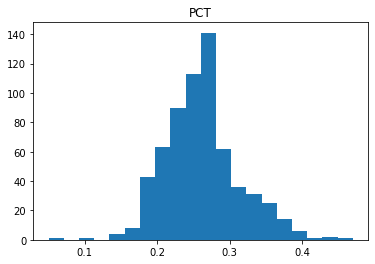

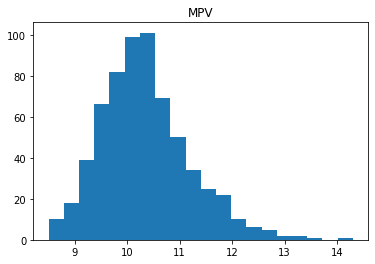

In [4]:
for col in ["PLT","PDW","PCT","MPV"]:
    plt.figure()
    plt.hist(sys_phen[col],bins=20)
    plt.title(col)

In [5]:
sys_phen.to_hdf("%s/sys_phen.hdf" % training_data, key="sys_phen")
print("Sysmex phenotypes available for %d samples" % sys_phen.shape[0])

Sysmex phenotypes available for 642 samples


In [47]:
sys_phen = pd.read_hdf("%s/sys_phen.hdf" % training_data, key="sys_phen")

## cell-level

In [6]:
sys_sct = load_Sysmex(data_dir)
sys_sct.rename(columns={"Side Fluorescence Signal":"SFL",
                                  "Forward Scatter Signal":"FSC",
                                  "Forward Scatter Pulse Width Signal":"FSCW",
                                  "Side Scatter Signal":"SSC"},inplace=True)

648 candidates Sysmex WB files


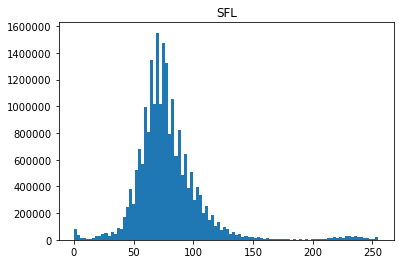

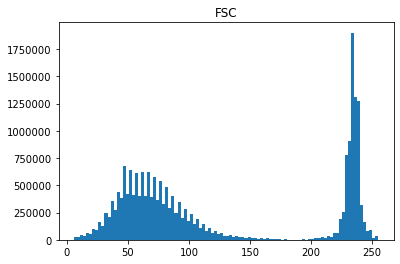

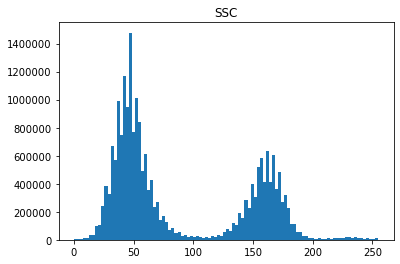

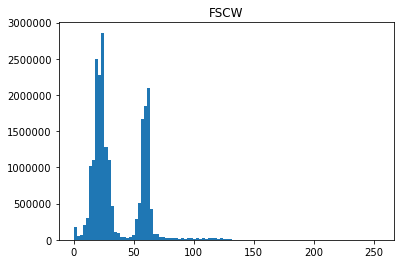

In [7]:
for c in sys_sct.columns[:4]:
    plt.figure()
    plt.hist(sys_sct[c],bins=100)
    plt.title(c)

In [8]:
sys_sct.to_hdf("%s/sys_df_init.hdf" % training_data,key="sys_df_init")

## Intersect

In [4]:
sys_sct = pd.read_hdf("%s/sys_df_init.hdf" % training_data,key="sys_df_init")

In [5]:
IDs_WB = sys_sct.ID.unique().tolist()
IDs_phen = sys_phen.ID.unique().tolist()

In [6]:
valid_IDs = [ID for ID in IDs_phen if ID in IDs_WB]
missing_IDs_1 = [ID for ID in IDs_phen if ID not in IDs_WB]
missing_IDs_2 = [ID for ID in IDs_WB if ID not in IDs_phen]
print("IDs in common", len(valid_IDs))
print("IDs only found in sysmex summary files", sorted(missing_IDs_1))
print("IDs only found in sysmex .FCS files", sorted(missing_IDs_2))

IDs in common 639
IDs only found in sysmex summary files ['C1A0NU', 'C1A0PQ', 'C1A2JU']
IDs only found in sysmex .FCS files ['C19BQP']


# Load Sysmex data of INTERVAL cohort

## Phenotypes

In [37]:
INTERVAL_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only"
meta = pd.read_csv("%s/interval_HAAS/meta_table.tsv" % INTERVAL_path, sep="\t")
pheno = pd.read_csv("%s/interval_phenotypes/INTERVALdata_14MAY2020.csv" % INTERVAL_path,sep=",", encoding = "ISO-8859-1")

In [38]:
pheno = pheno.rename(columns={"agePulse":"Age","sexPulse":"Sex"})

In [39]:
meta = meta.loc[meta.SampleType == "NHSBT"]
meta.shape

(102595, 11)

In [40]:
pheno = pheno.loc[~pheno.interval.isnull()]
pheno.shape

(45040, 760)

In [41]:
pheno_bl = pheno.rename(columns={'PLT_10_9_L_bl':"PLT",
                              'MPV_fL_bl':"MPV",
                              'PCT_PCT_bl':"PCT",
                              'PDW_fL_bl':"PDW",
                              "IPF_bl":"IPF"}).copy()
pheno_bl.dropna(subset=["PLT","MPV","PDW","PCT","IPF"],how="any",inplace=True)
pheno_bl["in_cohort"] = "BL"

int_phen = pd.merge(meta.loc[~meta.EpiCovId_bl.isnull()],pheno_bl,
                    left_on="EpiCovId_bl",right_on="identifier",how="inner",
                      validate="one_to_one")
print(int_phen.shape)

(20714, 772)


In [42]:
pheno_24 = pheno.loc[~pheno.identifier.isin(int_phen.identifier.tolist())].copy()
pheno_24.rename(columns={'PLT_10_9_L_24m':"PLT",
                              'MPV_fL_24m':"MPV",
                              'PCT_PCT_24m':"PCT",
                              'PDW_fL_24m':"PDW",
                              "IPF_24m":"IPF"},inplace=True)
pheno_24.dropna(subset=["PLT","MPV","PDW","PCT","IPF"],how="any",inplace=True)
pheno_24["in_cohort"] = "24"

to_add = pd.merge(meta.loc[~meta["EpiCovId_24m"].isnull()],
                  pheno_24,
                  left_on="EpiCovId_24m",right_on="identifier",
                  validate="one_to_one")
int_phen = pd.concat([int_phen,to_add],copy=False,axis=0)
print(int_phen.shape)

(37575, 777)


In [43]:
pheno_48 = pheno.loc[~pheno.identifier.isin(int_phen.identifier.tolist())].copy()
pheno_48.rename(columns={'PLT_10_9_L_48m':"PLT",
                              'MPV_fL_48m':"MPV",
                              'PCT_PCT_48m':"PCT",
                              'PDW_fL_48m':"PDW",
                              "IPF_48m":"IPF"},inplace=True)
pheno_48.dropna(subset=["PLT","MPV","PDW","PCT","IPF"],how="any",inplace=True)
pheno_48["in_cohort"] = "48"

to_add = pd.merge(meta.loc[~meta["EpiCovId_48m"].isnull()],
                  pheno_48,
                  left_on="EpiCovId_48m",right_on="identifier",
                  validate="one_to_one")
int_phen = pd.concat([int_phen,to_add],copy=False,axis=0)
print(int_phen.shape)

(37752, 777)


In [44]:
pheno

identifier  Sex  monthPulse  yearPulse   Age           ethnicPulse  \
0         1000000    2           7       1986  26.3    Eng/W/Scot/NI/Brit   
2         1000003    2           9       1961  51.8    Eng/W/Scot/NI/Brit   
3         1000004    1           2       1953  59.5    Eng/W/Scot/NI/Brit   
5         1000007    2          10       1981  31.0  Other White backgrnd   
6         1000008    1          10       1966  47.1    Eng/W/Scot/NI/Brit   
...           ...  ...         ...        ...   ...                   ...   
48454     1119979    2           4       1988  25.0    Eng/W/Scot/NI/Brit   
48455     1119980    2           1       1986  26.8    Eng/W/Scot/NI/Brit   
48456     1119986    2           1       1974  39.6    Eng/W/Scot/NI/Brit   
48458     1119994    1           2       1962  50.4           White Irish   
48459     1119998    2           5       1982  30.2    Eng/W/Scot/NI/Brit   

      attendanceDate  centre  newDonor recruitmentSource  ... dateTRIG_48m  \
0          17OCT2012      25         0              WINT  ...          NaN   
2          03JUL2013      11         0               DI1  ...          NaN   
3          01AUG2012       4         0              WINT  ...          NaN   
5          20OCT2012      25         0              WINT  ...          NaN   
6          08DEC2013       6         0              WINT  ...          NaN   
...              ...     ...       ...               ...  ...          ...   
48454      25APR2013      15         0            walkIn  ...          NaN   
48455      18NOV2012      19         0              WINT  ...          NaN   
48456      31AUG2013       4         0               DI5  ...    10JUL2017   
48458      08JUL2012      23         0              WINT  ...          NaN   
48459      25JUL2012       1         0              WINT  ...    02JUN2017   

      TCHOL_48m CRP_48m  FERR_48m FRUCTO_48m  HDL_48m  TRIG_48m  LDL_48m  \
0           NaN     NaN       NaN        NaN      NaN       NaN      NaN   
2           NaN     NaN       NaN        NaN      NaN       NaN      NaN   
3           NaN     NaN       NaN        NaN      NaN       NaN      NaN   
5           NaN     NaN       NaN        NaN      NaN       NaN      NaN   
6           NaN     NaN       NaN        NaN      NaN       NaN      NaN   
...         ...     ...       ...        ...      ...       ...      ...   
48454       NaN     NaN       NaN        NaN      NaN       NaN      NaN   
48455       NaN     NaN       NaN        NaN      NaN       NaN      NaN   
48456       5.7    1.02      21.0      331.0      1.9       1.3      3.0   
48458       NaN     NaN       NaN        NaN      NaN       NaN      NaN   
48459       6.9    0.65      22.0      261.0      2.1       2.1      4.1   

       HBA1C_48m  HBF_48m  
0            NaN      NaN  
2            NaN      NaN  
3            NaN      NaN  
5            NaN      NaN  
6            NaN      NaN  
...          ...      ...  
48454        NaN      NaN  
48455        NaN      NaN  
48456        NaN      0.8  
48458        NaN      NaN  
48459        NaN      NaN  

[45040 rows x 760 columns]

In [45]:
int_phen["DateTime"] = pd.to_datetime(int_phen["DateTime"], format="%Y-%m-%d %H:%M:%S")
print("%d rows before removing duplicate IDs" % int_phen.shape[0])
int_phen = int_phen.sort_values("DateTime",ascending=True).drop_duplicates("identifier",keep="first")
int_phen = int_phen.sort_values("DateTime",ascending=True).drop_duplicates("SampleNo",keep="first")
print("%d rows after removing duplicate IDs" % int_phen.shape[0])


37752 rows before removing duplicate IDs
37752 rows after removing duplicate IDs


In [46]:
#CHeck
cond = pheno.identifier.isin(meta["EpiCovId_48m"].tolist()) |\
        pheno.identifier.isin(meta["EpiCovId_24m"].tolist()) |\
        pheno.identifier.isin(meta["EpiCovId_bl"].tolist())
print(cond.sum())
print(pheno["identifier"].nunique())

37823
45040


NameError: name 'sys_phen' is not defined

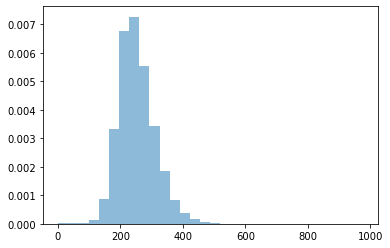

In [27]:
# Check that there's no discrepancy between cohorts
for c in ["PLT","MPV","PDW","PCT","IPF"]:
    plt.figure()
    plt.hist(int_phen[c],bins=30,density=True,alpha=.5,label="INTERVAL")
    plt.hist(sys_phen[c],bins=30,density=True,alpha=.5,label="Training cohort")
    plt.title(c)
    plt.legend()

## Cell level

In [208]:
sysmex_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS"
files = glob.glob("%s/*/SCT/PLTF*.csv" % sysmex_dir)

In [209]:
# Some samples have two files. In this case, we have ___.116.csv & ___.116(1).csv
# We only read ___.116.csv for now

In [210]:
to_read = [[sysmex_dir + "/" + m + "/SCT/PLTF_" + f +".csv" for f in \
           int_phen.loc[int_phen.FileName.str.contains(m,regex=False),"FileName"].tolist()] \
               for m in int_phen.Instrument.unique().tolist()]
to_read = to_read[0] + to_read[1]

print("Found %d scattergrams to read" % len(to_read))

Found 37752 scattergrams to read


In [211]:
dfs = []
# Only load a few examples, to check that clusterng will work well.
for f in tqdm(np.random.choice(to_read,200)):
    sct = pd.read_csv(f)
    assert sct.shape[0] > 0
    ID = f.split("][")[-1].lstrip(' ').split("]")[0]
    # Keeping only measurements with phase B
    #sct = sct.loc[sct.Phase == "B"]
    sct["ID"] = ID
    dfs.append(sct)
int_sct = pd.concat(dfs,axis=0,ignore_index=True)

100%|██████████| 200/200 [00:13<00:00, 14.82it/s]


# Filter platelets

## Polygon in SFL/FSC plane

In [212]:
def polygon_with_offset(offset):
    alpha = ((120+.6*offset) - (25+ .5*offset)) / (85 - 25)
    
    p = np.array([[22,25,30,85 ,140,200,200,80,50,22],
                  [5 + .3*offset ,25+ .5*offset,max(35+.5*offset,25+.5*offset + alpha*5),120+.6*offset,180+.6*offset,220,160,15,0,5+ .3*offset]])
    #p[0] -= offset
    return p.T

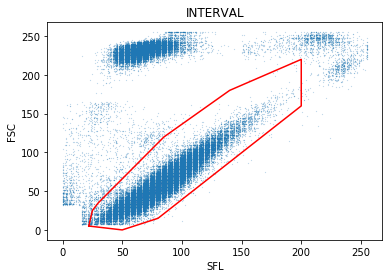

In [213]:
plt.figure()
sub_int_sct = int_sct.sample(int(1e5))
plt.scatter(sub_int_sct.SFL,
            sub_int_sct.FSC,s=.01)

offset = 0
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("INTERVAL");

Text(0.5, 1.0, 'PFC Cohort')

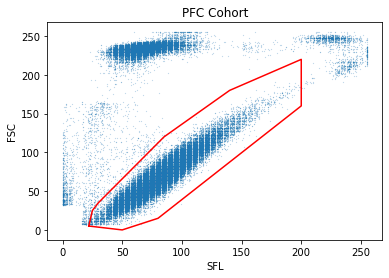

In [214]:
plt.figure()
sub_sys_sct = sys_sct.sample(int(1e5))
plt.scatter(sub_sys_sct.SFL,sub_sys_sct.FSC,s=.01)

offset = 0
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("PFC Cohort")

In [215]:
int_sct["PLT"] = path.contains_points(int_sct[["SFL","FSC"]])
sys_sct["PLT"] = path.contains_points(sys_sct[["SFL","FSC"]])

In [216]:
def subsample(x):
    return x.sample(1000)

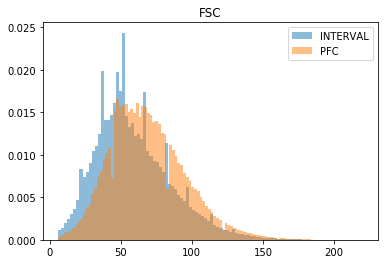

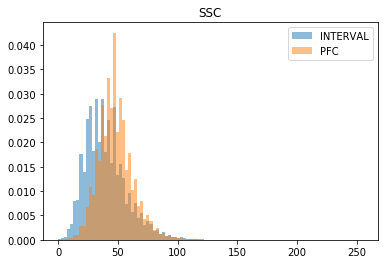

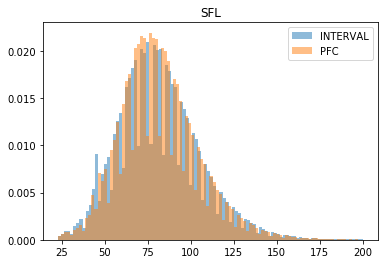

In [217]:
for c in FACS_cols:
    plt.figure()
    plt.hist(int_sct.loc[int_sct.PLT].groupby("ID").apply(subsample)[c],bins=100,density=True,alpha=.5,label="INTERVAL")
    plt.hist(sys_sct.loc[sys_sct.PLT].groupby("ID").apply(subsample)[c],bins=100,density=True,alpha=.5,label="PFC")
    plt.title(c)
    plt.legend()

Text(0, 0.5, 'SFL')

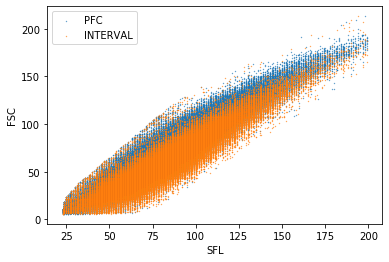

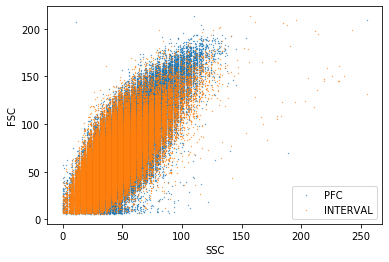

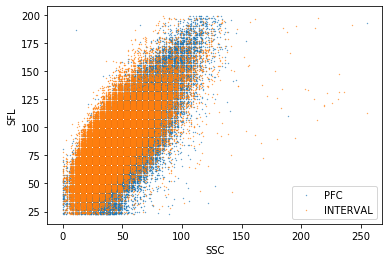

In [218]:
sub_sys_sct = sys_sct.groupby("ID").apply(subsample)
sub_int_sct = int_sct.groupby("ID").apply(subsample)
plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SFL"],sub_sys_sct.loc[sub_sys_sct.PLT,"FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SFL"],sub_int_sct.loc[sub_int_sct.PLT,"FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SSC"],sub_sys_sct.loc[sub_sys_sct.PLT,"FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SSC"],sub_int_sct.loc[sub_int_sct.PLT,"FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SSC"],sub_sys_sct.loc[sub_sys_sct.PLT,"SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SSC"],sub_int_sct.loc[sub_int_sct.PLT,"SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

## Compare counts

In [219]:
print(sys_sct.loc[sys_sct.PLT].ID.value_counts().mean())
print(int_sct.loc[int_sct.PLT].ID.value_counts().mean())

20864.878125
20821.21


Text(0.5, 1.0, 'PFC')

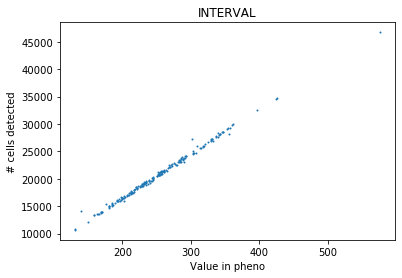

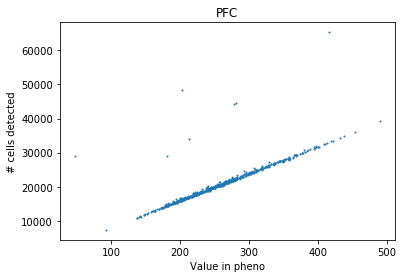

In [220]:
plt.figure()
X = pd.merge(int_phen,int_sct.loc[int_sct.PLT,"ID"].value_counts(),left_on="SampleNo",right_index=True)
plt.scatter(X["PLT"],X.ID,s=1)
plt.xlabel("Value in pheno")
plt.ylabel("# cells detected")
plt.title("INTERVAL")

plt.figure()
X = pd.merge(sys_phen,sys_sct.loc[sys_sct.PLT,"ID"].value_counts(),left_on="ID",right_index=True)
plt.scatter(X["PLT"],X.ID_y,s=1)
plt.xlabel("Value in pheno")
plt.ylabel("# cells detected")
plt.title("PFC")

## Filter for good

In [221]:
def read_and_filter_platelets(f):
    sct = pd.read_csv(f)
    assert sct.shape[0] > 0
    # Keeping only measurements with phase B
    ID = f.split("][")[-1].lstrip(' ').split("]")[0]
    #sct = sct.loc[sct.Phase == "B"]
    sct["PLT"] = path.contains_points(sct[["SFL","FSC"]])# & (sct["FSCW"] > 0)
    sct["ID"] = ID
    N = sct.PLT.sum()
    return sct.loc[sct.PLT,FACS_cols+["ID"]].sample(N // 4,replace=True)
    

In [222]:
from multiprocessing import Pool
p = Pool(16)
dfs = []
for df in tqdm(p.imap_unordered(read_and_filter_platelets,to_read)):
    dfs.append(df)
p.close()
int_sct = pd.concat(dfs,axis=0,ignore_index=True,copy=False)
del dfs

37752it [01:45, 357.83it/s]


In [224]:
int_sct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196381220 entries, 0 to 196381219
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   FSC     int64 
 1   SSC     int64 
 2   SFL     int64 
 3   ID      object
dtypes: int64(3), object(1)
memory usage: 5.9+ GB


In [225]:
int_sct.to_hdf("%s/int_sct_raw.hdf" % training_data,key="INT_SCT")
int_sct = pd.read_hdf("%s/int_sct_raw.hdf" % training_data,key="INT_SCT")

## Filter bad counts

In [226]:
from sklearn.linear_model import LinearRegression

In [227]:
count = sys_sct.groupby("ID")[["FSC"]].count().rename(columns={"FSC":"PLT_count"})
pheno = sys_phen.groupby("ID")[["PLT"]].first().rename(columns={"PLT":"PLT_pheno"})
comp_sys = pd.merge(count,pheno,left_index=True,right_index=True,how="inner")

count = int_sct.groupby("ID")[["FSC"]].count().rename(columns={"FSC":"PLT_count"})
pheno = int_phen.groupby("SampleNo")[["PLT"]].first().rename(columns={"PLT":"PLT_pheno"})
comp_int = pd.merge(count,pheno,left_index=True,right_index=True,how="inner")

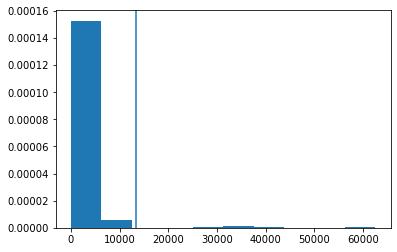

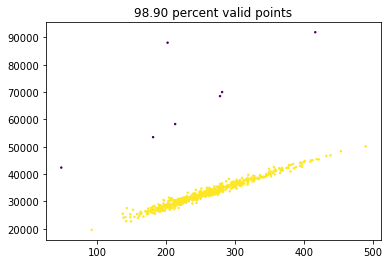

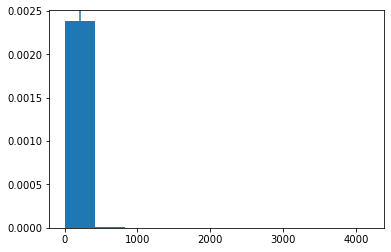

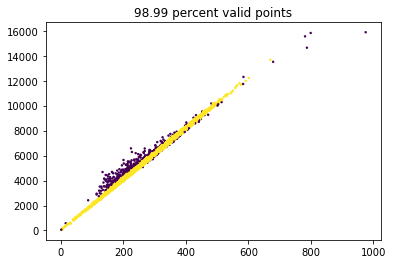

In [230]:
valid_IDs_PLT = []
for comp in [comp_sys,comp_int]:
    lm = LinearRegression(fit_intercept=False).fit(np.reshape(comp.PLT_pheno.values,(-1,1)),comp.PLT_count)
    pred = lm.predict(np.reshape(comp.PLT_pheno.values,(-1,1)))
    error = np.abs(pred-comp.PLT_count)
    plt.figure()
    plt.hist(error,density=True)
    err_threshold = np.mean(error) + 2.5*np.std(error)
    comp["err"] = error
    comp["err_th"] = error / comp.PLT_count
    comp["valid"] = (comp.err < err_threshold) & (comp.err_th < .6) 
    plt.axvline(err_threshold)
    plt.figure()
    plt.scatter(comp.PLT_pheno,comp.PLT_count,c=comp.valid,s=2)
    plt.title("%.2f percent valid points" % (comp.valid.mean()*100))
    valid_IDs_PLT += comp.loc[comp.valid].index.tolist()

In [231]:
int_sct = int_sct.loc[int_sct.ID.isin(valid_IDs_PLT)]
sys_sct = sys_sct.loc[sys_sct.PLT]
sys_sct = sys_sct.loc[sys_sct.ID.isin(valid_IDs_PLT)]

int_sct.to_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")
sys_sct.to_hdf("%s/sys_sct_filtered.hdf" % training_data,key="SYS_SCT")

int_sct = pd.read_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data,key="SYS_SCT")

In [232]:
sys_sct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13044506 entries, 0 to 38773
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   SFL     float32
 1   FSC     float32
 2   SSC     float32
 3   FSCW    float32
 4   ID      object 
 5   PLT     bool   
dtypes: bool(1), float32(4), object(1)
memory usage: 410.5+ MB


In [233]:
int_sct.ID.nunique()

37372

# Adjust

In [93]:
int_sct = pd.read_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")

## SCT and phen for time variations

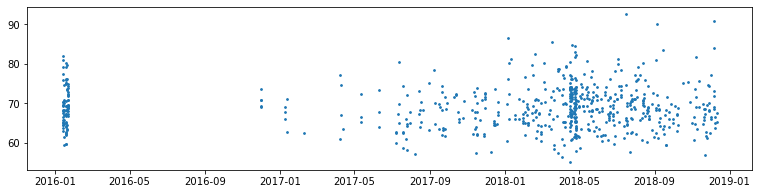

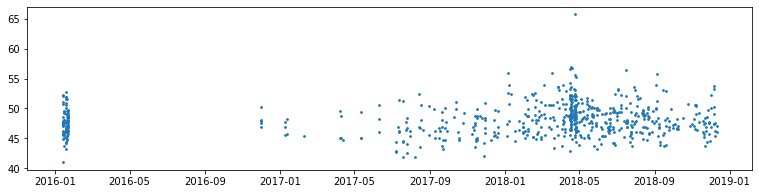

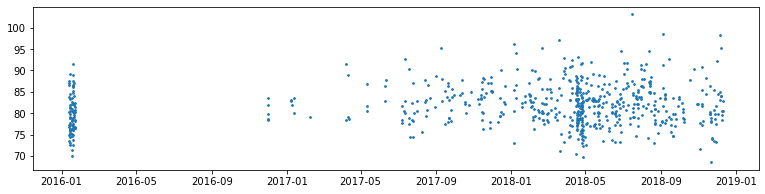

In [92]:
# No adjustment for PFC cohort, too few samples
mean_values = sys_sct.groupby("ID")[FACS_cols].mean()
mean_values = pd.merge(mean_values,sys_phen,left_index=True,right_on="ID")
for c in FACS_cols:
    plt.figure(figsize=(13,3))
    plt.scatter(pd.to_datetime(mean_values.Date),mean_values[c],s=3)

In [10]:
int_phen.head()

FileName         SampleNo  \
0  [XN-10^11041][00-11_8][20130301_101944][      ...  INT_116_6580100   
2  [XN-10^11041][00-11_8][20130301_102100][      ...  INT_116_6580000   
4  [XN-10^11041][00-11_8][20130301_102216][      ...  INT_116_2129800   
6  [XN-10^11041][00-11_8][20130301_102333][      ...  INT_116_4555900   
7  [XN-10^11041][00-11_8][20130301_102449][      ...  INT_116_4555800   

    Instrument            DateTime  DateTime_rank SampleType  \
0  XN-10^11041 2013-03-01 10:19:44            2.0      NHSBT   
2  XN-10^11041 2013-03-01 10:21:00            3.0      NHSBT   
4  XN-10^11041 2013-03-01 10:22:16            4.0      NHSBT   
6  XN-10^11041 2013-03-01 10:23:33            5.0      NHSBT   
7  XN-10^11041 2013-03-01 10:24:49            6.0      NHSBT   

   WithinSampleRank  EpiCovId_bl  EpiCovId_24m  EpiCovId_48m  ...  \
0                 1    1090916.0           NaN           NaN  ...   
2                 1    1111731.0           NaN           NaN  ...   
4                 1    1070498.0           NaN           NaN  ...   
6                 1    1042358.0           NaN           NaN  ...   
7                 1    1111391.0           NaN           NaN  ...   

   dateTRIG_48m  TCHOL_48m  CRP_48m  FERR_48m  FRUCTO_48m  HDL_48m  TRIG_48m  \
0           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
2           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
4           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
6           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
7           NaN        NaN      NaN       NaN         NaN      NaN       NaN   

  LDL_48m HBA1C_48m  HBF_48m  
0     NaN       NaN      NaN  
2     NaN       NaN      NaN  
4     NaN       NaN      NaN  
6     NaN       NaN      NaN  
7     NaN       NaN      NaN  

[5 rows x 772 columns]

In [94]:
from pandas.tseries.offsets import MonthEnd
def compute_shift(x):
    x = shift_by_month.loc[x.index.first(),x.name]
    return x

In [95]:
sample_shifts = []

sys_pheno_cols = ["PLT","MPV","PCT","PDW","IPF"]
cols_to_adjust = FACS_cols + sys_pheno_cols

In [96]:
mean_values_all = int_sct.groupby("ID")[FACS_cols].mean()
base_mean = mean_values_all[FACS_cols].mean()
base_mean = pd.concat([base_mean,int_phen[sys_pheno_cols].mean()],axis=0)

XN-10^11041 18258
XN-10^11036 19494


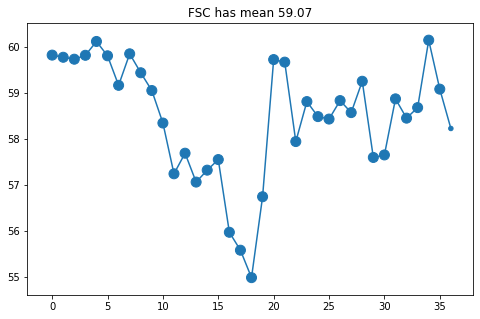

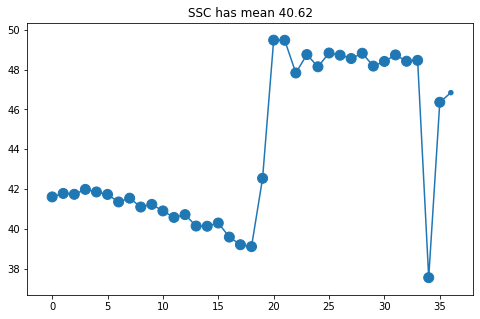

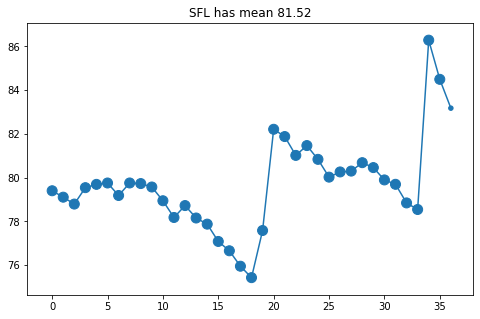

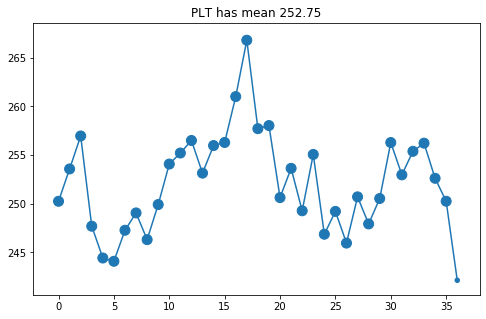

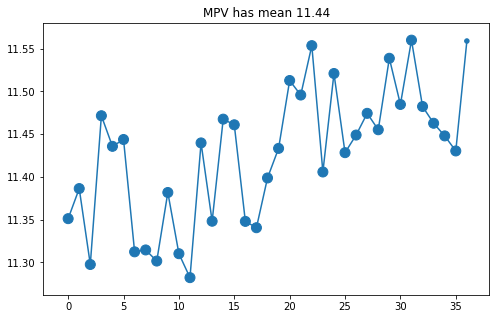

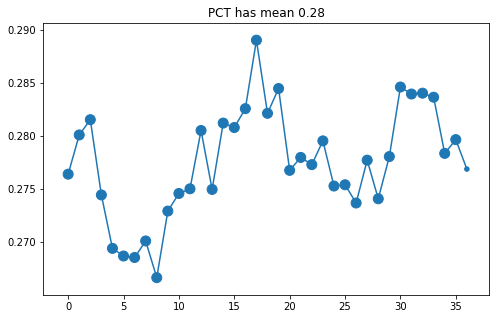

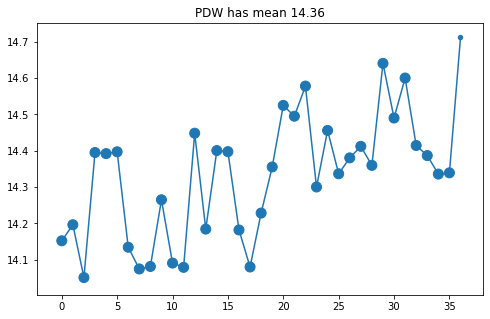

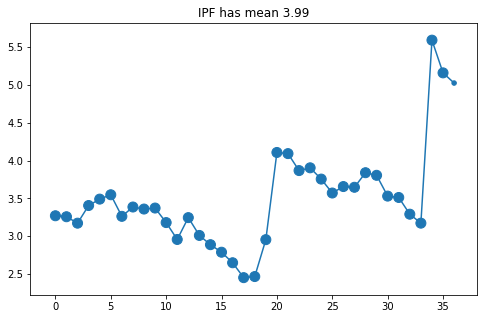

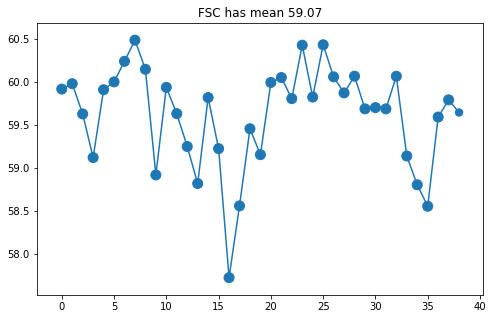

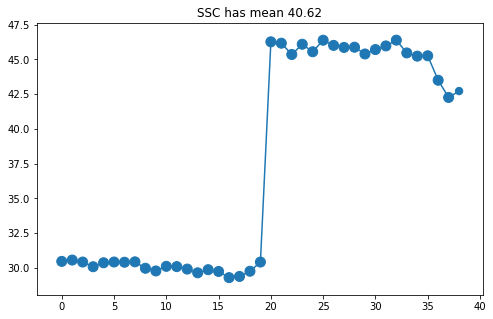

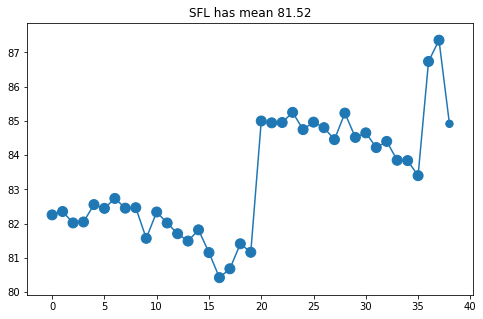

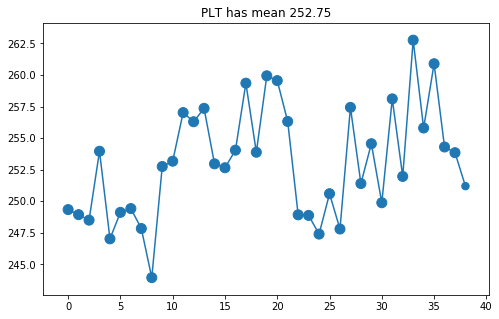

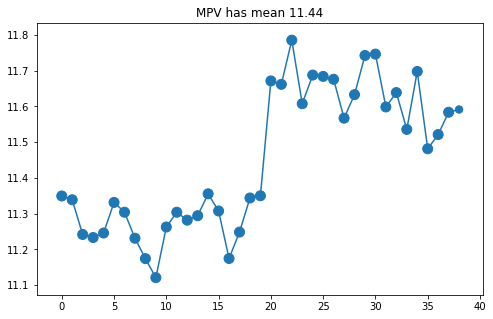

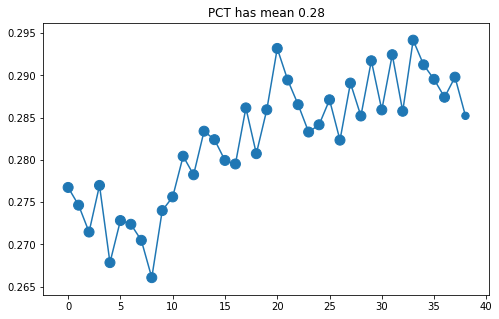

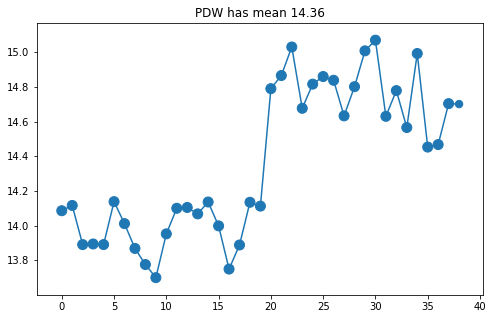

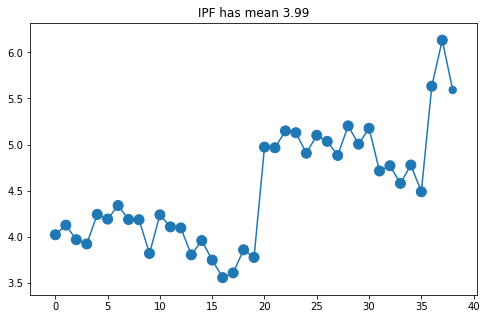

In [97]:
for machine in int_phen.Instrument.unique():
    
    machine_IDs = int_phen.loc[int_phen.Instrument == machine,"SampleNo"].unique().tolist()
    print(machine,len(machine_IDs))
    mean_values_SCT = int_sct.loc[int_sct.ID.isin(machine_IDs)].groupby("ID")[FACS_cols].mean()
    mean_values = pd.merge(mean_values_SCT,int_phen[["DateTime","SampleNo"] + sys_pheno_cols],left_index=True,right_on="SampleNo")
    mean_values.set_index("DateTime",inplace=True)
    mean_values.sort_index(inplace=True)
    mean_values.reset_index(inplace=True)
    mean_values["Group"] = mean_values.index // 500
    
    mean_counts = mean_values.groupby("Group")[cols_to_adjust].count()
    mean_val = mean_values.groupby("Group")[cols_to_adjust].mean()
    for c in mean_val.columns:
        plt.figure(figsize=(8,5))
        plt.plot(mean_val.index,mean_val[c])
        plt.scatter(mean_val.index,mean_val[c],s=mean_counts[c]/5)
        plt.title("%s has mean %.2f" % (c,base_mean[c]))
        
    shift_by_month = mean_val - base_mean
    shift_by_month.loc[mean_counts["FSC"] < 100] = np.nan
    shift_by_month.fillna(method="ffill",inplace=True,axis=0)
    sample_shift = pd.merge(mean_values[["Group","SampleNo"]],shift_by_month,left_on="Group",right_index=True)
    sample_shifts.append(sample_shift)
sample_shift = pd.concat(sample_shifts,axis=0)

In [98]:
sample_shift

Group         SampleNo       FSC       SSC       SFL       PLT  \
0          0  INT_116_6580100  0.758523  0.983654 -2.122402 -2.497921   
1          0  INT_116_6580000  0.758523  0.983654 -2.122402 -2.497921   
2          0  INT_116_2129800  0.758523  0.983654 -2.122402 -2.497921   
3          0  INT_116_4555900  0.758523  0.983654 -2.122402 -2.497921   
4          0  INT_116_4555800  0.758523  0.983654 -2.122402 -2.497921   
...      ...              ...       ...       ...       ...       ...   
19267     38  INT_116_4535600  0.578282  2.093584  3.393435 -1.551068   
19268     38  INT_116_4149900  0.578282  2.093584  3.393435 -1.551068   
19269     38  INT_116_1952600  0.578282  2.093584  3.393435 -1.551068   
19270     38  INT_116_6545900  0.578282  2.093584  3.393435 -1.551068   
19271     38  INT_116_4548700  0.578282  2.093584  3.393435 -1.551068   

            MPV       PCT       PDW       IPF  
0     -0.093388 -0.004324 -0.209925 -0.717379  
1     -0.093388 -0.004324 -0.209925 -0.717379  
2     -0.093388 -0.004324 -0.209925 -0.717379  
3     -0.093388 -0.004324 -0.209925 -0.717379  
4     -0.093388 -0.004324 -0.209925 -0.717379  
...         ...       ...       ...       ...  
19267  0.146956  0.004476  0.339178  1.603132  
19268  0.146956  0.004476  0.339178  1.603132  
19269  0.146956  0.004476  0.339178  1.603132  
19270  0.146956  0.004476  0.339178  1.603132  
19271  0.146956  0.004476  0.339178  1.603132  

[37372 rows x 10 columns]

In [99]:
int_phen = int_phen.loc[int_phen.SampleNo.isin(int_sct.ID.unique().tolist())]

In [102]:
shift = pd.merge(int_sct, sample_shift,left_on="ID",
                 right_on="SampleNo",
                 suffixes=("","_shift"),
                 how="left")[FACS_cols + [f+"_shift" for f in FACS_cols]]
int_sct[FACS_cols] = shift[FACS_cols].values - shift[[f+"_shift" for f in FACS_cols]].values

In [103]:
shift = pd.merge(int_phen, sample_shift,left_on="SampleNo",
                 right_on="SampleNo",
                 suffixes=("","_shift"),
                 how="left")[sys_pheno_cols + [f+"_shift" for f in sys_pheno_cols]]
int_phen[sys_pheno_cols] = shift[sys_pheno_cols].values - shift[[f+"_shift" for f in sys_pheno_cols]].values

In [104]:
int_sct.head()

FSC        SSC         SFL               ID
0  12.241477  15.016346   40.122402  INT_116_4555900
1  51.241477  37.016346   79.122402  INT_116_4555900
2  40.241477  24.016346   68.122402  INT_116_4555900
3  67.241477  72.016346   78.122402  INT_116_4555900
4  88.241477  55.016346  119.122402  INT_116_4555900

XN-10^11041 18100
XN-10^11036 19272


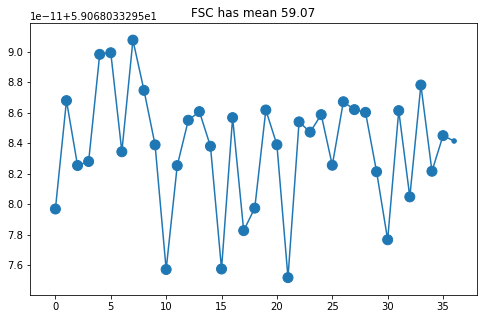

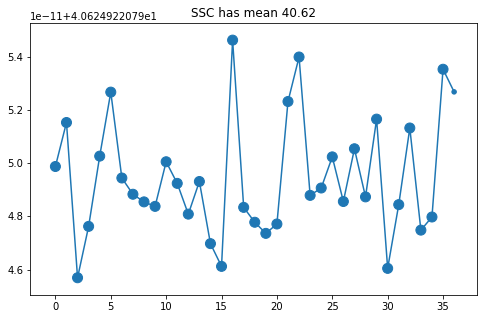

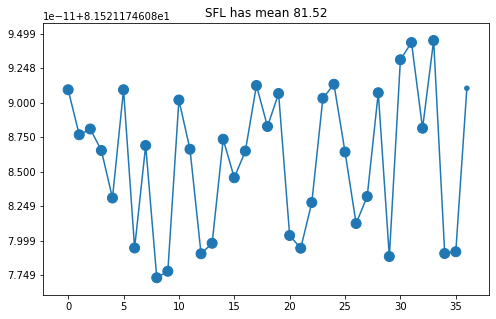

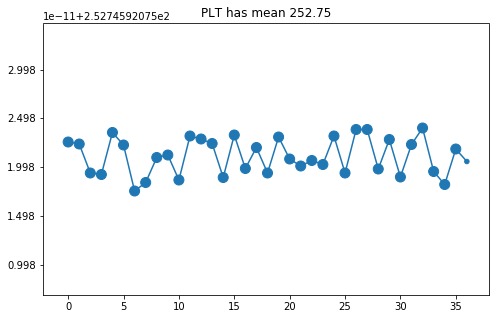

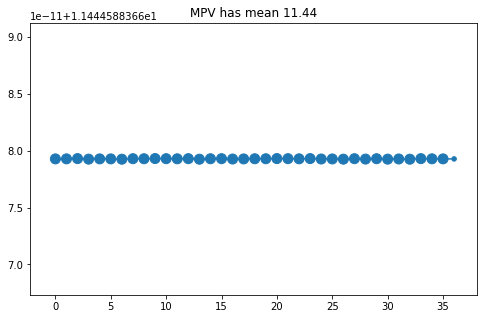

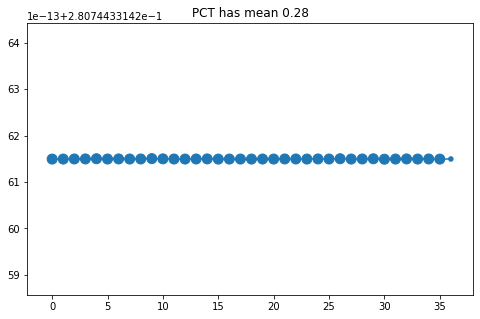

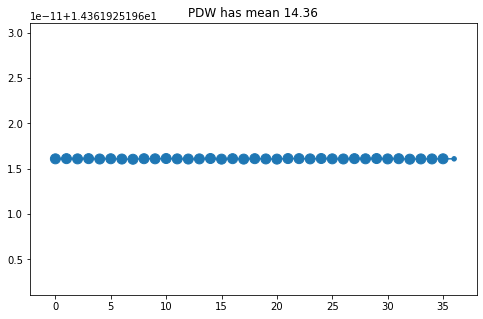

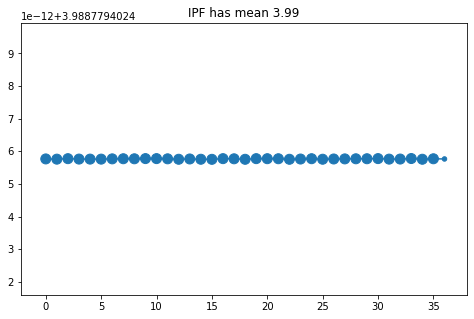

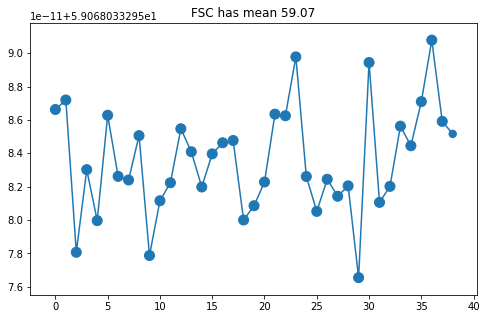

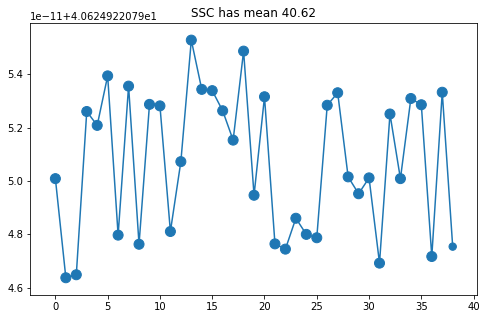

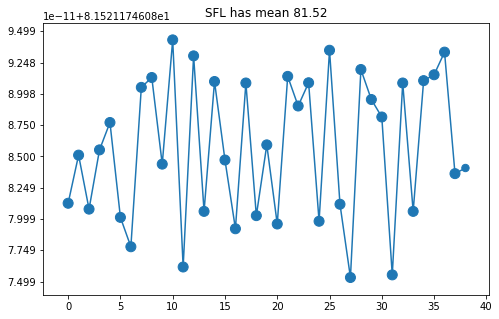

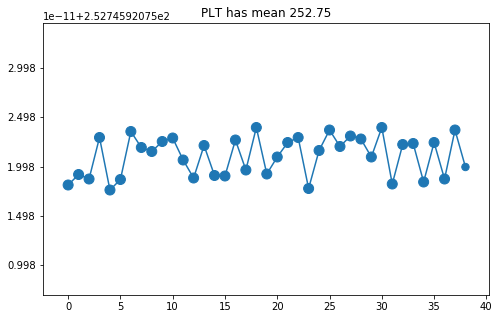

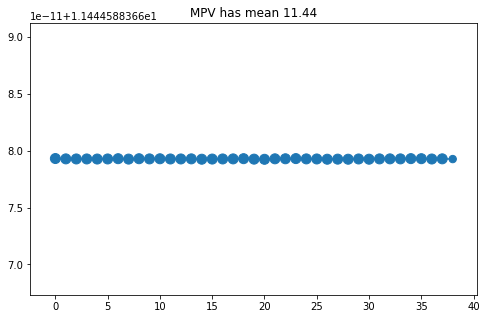

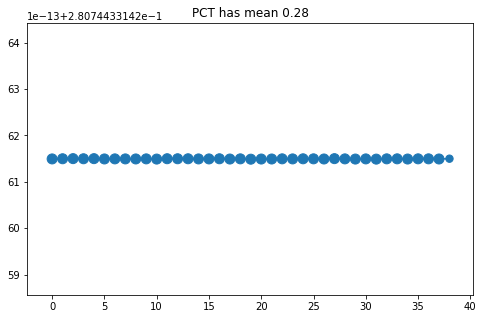

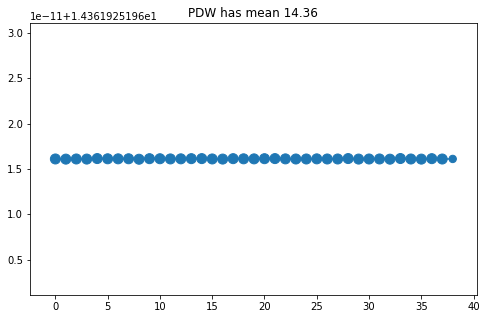

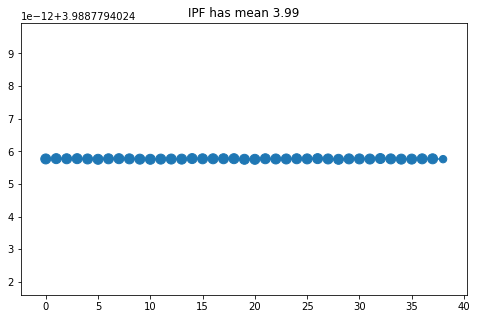

In [105]:
for machine in int_phen.Instrument.unique():
    
    machine_IDs = int_phen.loc[int_phen.Instrument == machine,"SampleNo"].unique().tolist()
    print(machine,len(machine_IDs))
    mean_values_SCT = int_sct.loc[int_sct.ID.isin(machine_IDs)].groupby("ID")[FACS_cols].mean()
    mean_values = pd.merge(mean_values_SCT,int_phen[["DateTime","SampleNo"] + sys_pheno_cols],left_index=True,right_on="SampleNo")
    mean_values.set_index("DateTime",inplace=True)
    mean_values.sort_index(inplace=True)
    mean_values.reset_index(inplace=True)
    mean_values["Group"] = mean_values.index // 500
    
    mean_counts = mean_values.groupby("Group")[cols_to_adjust].count()
    mean_val = mean_values.groupby("Group")[cols_to_adjust].mean()
    for c in mean_val.columns:
        plt.figure(figsize=(8,5))
        plt.plot(mean_val.index,mean_val[c])
        plt.scatter(mean_val.index,mean_val[c],s=mean_counts[c]/5)
        plt.title("%s has mean %.2f" % (c,base_mean[c]))

In [106]:
# IT works !

In [107]:
int_sct.to_hdf("%s/int_sct_adjusted.hdf" % training_data,key="INT_SCT")
int_phen.to_hdf("%s/int_phen_adjusted.hdf" % training_data,key="INT_PHEN")

## for discrepancies with PFC

In [108]:
int_sct = pd.read_hdf("%s/int_sct_adjusted.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)

In [109]:
def subsample_1000(x):
    return x.sample(1000)

def subsample_50(x):
    return x.sample(50,replace=True)

In [110]:
pfc_IDs = sys_sct.ID.unique().tolist()
int_1_IDs = int_phen.loc[int_phen.Instrument == "XN-10^11041"].SampleNo.unique().tolist()
int_2_IDs = int_phen.loc[int_phen.Instrument != "XN-10^11041"].SampleNo.unique().tolist()

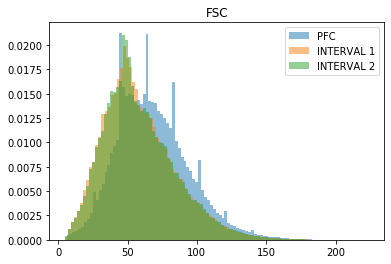

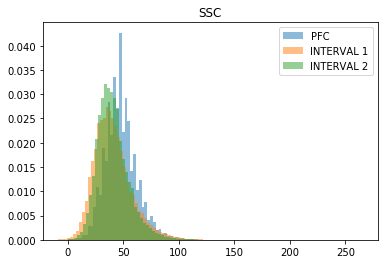

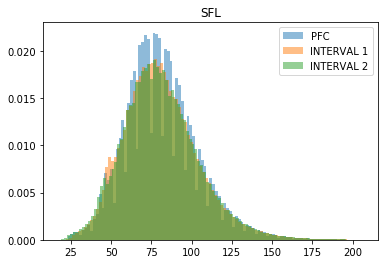

In [111]:
for c in FACS_cols:
    plt.figure()
    plt.hist(sys_sct.loc[sys_sct.ID.isin(pfc_IDs),c],label="PFC",alpha=.5,density=True,bins=100)
    plt.hist(int_sct.loc[int_sct.ID.isin(int_1_IDs),c],label="INTERVAL 1",alpha=.5,density=True,bins=100)
    plt.hist(int_sct.loc[int_sct.ID.isin(int_2_IDs),c],label="INTERVAL 2",alpha=.5,density=True,bins=100)
    plt.title(c)
    plt.legend();

In [112]:
sub_sys_sct = sys_sct.groupby("ID").apply(subsample_1000)
sub_int_sct = int_sct.groupby("ID").apply(subsample_50)

Text(0, 0.5, 'SFL')

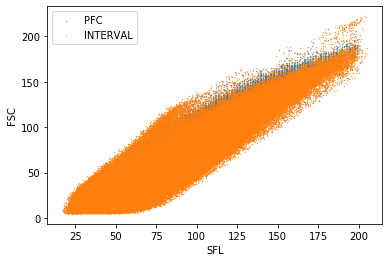

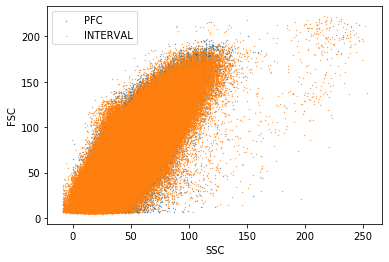

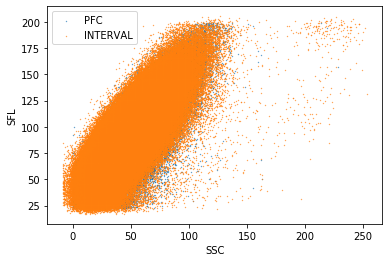

In [113]:
plt.figure()
plt.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SFL"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

In [114]:
from scipy.interpolate import interp1d
for c in FACS_cols:
    pfc_quantiles = np.quantile(sub_sys_sct[c],np.linspace(0,1,1000))
    for inst in int_phen.Instrument.unique().tolist():
        machine_IDs = int_phen.loc[int_phen.Instrument == inst,"SampleNo"].unique().tolist()
        cond_sub = sub_int_sct.ID.isin(machine_IDs)
        cond = int_sct.ID.isin(machine_IDs)
        int_quantiles = np.quantile(sub_int_sct.loc[cond_sub,c],np.linspace(0,1,1000))
        interpolator = interp1d(int_quantiles,pfc_quantiles,fill_value="extrapolate")
        int_sct.loc[cond,c] = interpolator(int_sct.loc[cond,c])

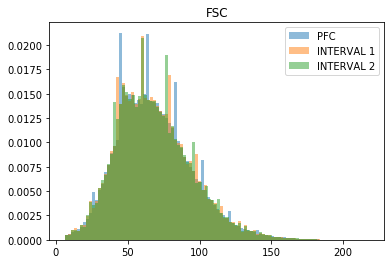

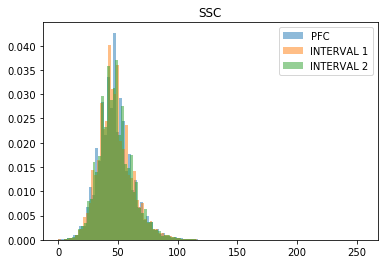

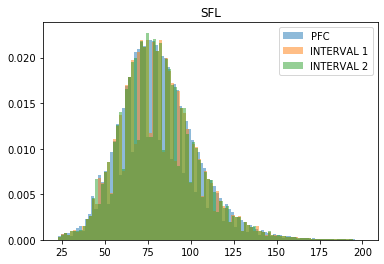

In [115]:
for c in FACS_cols:
    plt.figure()
    plt.hist(sys_sct.loc[sys_sct.ID.isin(pfc_IDs),c],label="PFC",alpha=.5,density=True,bins=100)
    plt.hist(int_sct.loc[int_sct.ID.isin(int_1_IDs),c],label="INTERVAL 1",alpha=.5,density=True,bins=100)
    plt.hist(int_sct.loc[int_sct.ID.isin(int_2_IDs),c],label="INTERVAL 2",alpha=.5,density=True,bins=100)
    plt.title(c)
    plt.legend();

Text(0, 0.5, 'SFL')

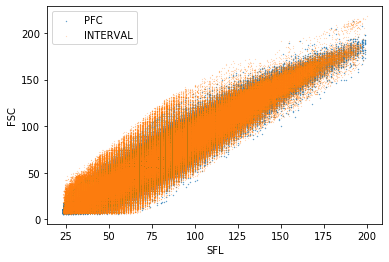

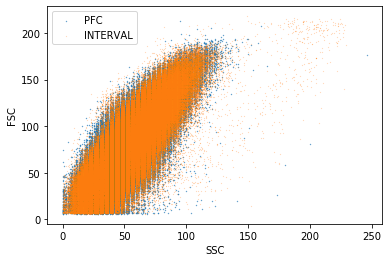

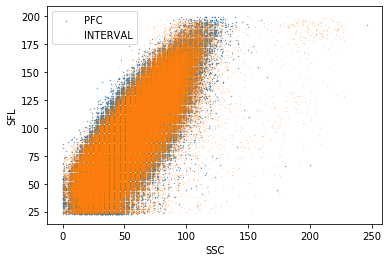

In [116]:
sub_sys_sct = sys_sct.groupby("ID").apply(subsample_1000)
sub_int_sct = int_sct.groupby("ID").apply(subsample_50)
plt.figure()
plt.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SFL"],sub_int_sct["FSC"],s=.01,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["FSC"],s=.01,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["SFL"],s=.01,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

In [117]:
int_sct.to_hdf("%s/int_sct_discrepancy_adjusted.hdf" % training_data,key="INT_SCT")

# PF FC phenotypes

## Loading

We load the FC phenotypes database

In [287]:
all_pheno_df = pd.read_csv("%s/metadata_PF/PLATELET_FUNCTION_KD_11062019.txt" % data_dir,sep="\t")
#all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_4_U","PROJECT"] = "PFC_4"
del all_pheno_df["TIME"]

pf_unicorn = pd.read_csv("%s/metadata_PF/UNICORN_PF.csv" % data_dir,sep=";",decimal=",")
pf_unicorn.dropna(subset=["ID"],how="any",axis=0,inplace=True)
pf_unicorn["PROJECT"] = "PFC_4_U2"
rename = {"Date":"DATE", "ID":"SAMPLE_ID"}
for c in pf_unicorn.columns:
    if c[-3:] == "_PP":
        rename[c] = c[:-3]
pf_unicorn.rename(columns=rename,inplace=True)
rename = {}
for c in pf_unicorn.columns:
    if c[:2] in ["F_","P_"]:
        pf_unicorn[c] = pf_unicorn[c].astype(float)
        parts = c.split("_")
        marker = parts[0]
        ago = parts[1]
        if marker == "F":
            marker = "FIB"
        elif marker == "P":
            marker = "PSEL"
        parts[1] = marker
        parts[0] = ago
        rename[c] = "_".join(parts)
pf_unicorn.rename(columns=rename,inplace=True)
good_columns = all_pheno_df.columns
pf_unicorn = pf_unicorn[good_columns]

In [288]:
all_pheno_df.sample(3)

PROJECT     SAMPLE_ID      DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
301    PFC_1  100010100366  17/08/05        3.08        3.06          NaN   
75     PFC_1  100010100008  18/07/05        2.32        2.69          NaN   
1707   PFC_4        C18A47  25/07/17        0.24        0.24        14.41   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR1_PSEL_1  \
301           NaN      41.89      43.24      50.71  ...          NaN   
75            NaN      42.36      41.14      78.85  ...          NaN   
1707        15.22      39.97      38.40       5.94  ...        67.21   

      PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
301           NaN         NaN         NaN          NaN          NaN   
75            NaN         NaN         NaN          NaN          NaN   
1707        68.24       13.07       17.17        70.52        81.55   

      TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
301          NaN         NaN          NaN          NaN  
75           NaN         NaN          NaN          NaN  
1707        0.78        0.44         27.6        25.41  

[3 rows x 27 columns]

In [289]:
#all_pheno_df = pd.concat([pf_unicorn,all_pheno_df],axis=0)

In [294]:
df = all_pheno_df.copy()

## QC of phenotypes

In [295]:
agonists = ["ADP","CRP","TRAP","PAR1","PAR4"]

# Move to logit and normalize

for c in df.columns:
    is_fc_measurement = False
    for ago in agonists + ["REST"]:
        if ago in str(c):
            is_fc_measurement = True
            break
    if is_fc_measurement == True:
        if df[c].dtype == np.float:
            df[c] = np.log(df[c] / (100. - df[c]))
            
        for p in df.PROJECT.unique().tolist():
            df.loc[(df.PROJECT == p) & ~df[c].isnull(),c] = \
                    df.loc[(df.PROJECT == p) & ~df[c].isnull(),c] - \
                    df.loc[(df.PROJECT == p) & ~df[c].isnull(),c].mean()

In [296]:
df.head()

PROJECT     SAMPLE_ID      DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
0   PFC_1  100010100138  08/01/05   -0.219761    0.072761          NaN   
1   PFC_1  100010100139  08/01/05    0.162393    0.047692          NaN   
2   PFC_1  100010100140  08/01/05    0.254578    0.196270          NaN   
3   PFC_1  100010100141  08/01/05   -0.233673    0.079817          NaN   
4   PFC_1  100010100142  08/01/05    0.277880    0.315483          NaN   

   REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR1_PSEL_1  \
0          NaN   0.291696   0.143457   0.491260  ...          NaN   
1          NaN   0.148100   0.002572   1.402746  ...          NaN   
2          NaN   0.366266   0.184621   0.338351  ...          NaN   
3          NaN   0.125048   0.375470   0.876219  ...          NaN   
4          NaN  -1.405427  -1.299646  -0.477888  ...          NaN   

   PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  TRAP_FIB_1  \
0          NaN         NaN         NaN          NaN          NaN         NaN   
1          NaN         NaN         NaN          NaN          NaN         NaN   
2          NaN         NaN         NaN          NaN          NaN         NaN   
3          NaN         NaN         NaN          NaN          NaN         NaN   
4          NaN         NaN         NaN          NaN          NaN         NaN   

   TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
0         NaN          NaN          NaN  
1         NaN          NaN          NaN  
2         NaN          NaN          NaN  
3         NaN          NaN          NaN  
4         NaN          NaN          NaN  

[5 rows x 27 columns]

In [297]:
for ago in agonists:
    for reag in ["FIB","PSEL"]:
        df["N_%s_%s" % (ago,reag)] = (1*~df["%s_%s_1" % (ago,reag)].isnull() + 1*~df["%s_%s_2" % (ago,reag)].isnull())
        # Do we check that there's at least one "REST" measurement ?
        # No ! This removed approx. 500 donors from the ADP cohort...
        # df["N_%s_%s" % (ago,reag)] *= 1*(~df["REST_%s_1"% reag].isnull() | ~df["REST_%s_2"% reag].isnull())
        df["OK_%s_%s" % (ago,reag)] = 1*(df["N_%s_%s" % (ago,reag)] == 2)
        print("%s - %s : %d" % (ago,reag, df["OK_%s_%s" % (ago,reag)].sum()))

ADP - FIB : 2131
ADP - PSEL : 1686
CRP - FIB : 2134
CRP - PSEL : 2135
TRAP - FIB : 1186
TRAP - PSEL : 1186
PAR1 - FIB : 1184
PAR1 - PSEL : 1185
PAR4 - FIB : 1186
PAR4 - PSEL : 1185


Before Normalization
PROJECT
PFC_1     -0.006684
PFC_2     -0.036264
PFC_3     -0.008429
PFC_4      0.056765
PFC_4_U    0.023518
Name: ADP_FIB, dtype: float64
PROJECT
PFC_1      490
PFC_2      421
PFC_3      645
PFC_4      437
PFC_4_U     91
Name: ADP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1     -0.000364
PFC_3     -0.002036
PFC_4      0.015664
PFC_4_U    0.000126
Name: ADP_PSEL, dtype: float64
PROJECT
PFC_1      485
PFC_3      644
PFC_4      438
PFC_4_U     93
Name: ADP_PSEL, dtype: int64
Before Normalization
PROJECT
PFC_1      1.088792e-02
PFC_2      1.657596e-02
PFC_3      4.153081e-03
PFC_4      5.447484e-02
PFC_4_U    6.082605e-17
Name: CRP_FIB, dtype: float64
PROJECT
PFC_1      488
PFC_2      435
PFC_3      642
PFC_4      434
PFC_4_U     94
Name: CRP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1      2.952809e-02
PFC_2      3.610324e-02
PFC_3      5.410232e-03
PFC_4      2.376510e-02
PFC_4_U    7.086530e-17
Name: CRP_PSEL, dtype: float64
PROJECT
PFC_1      492


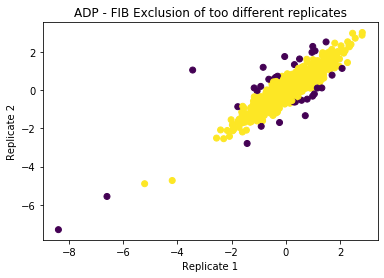

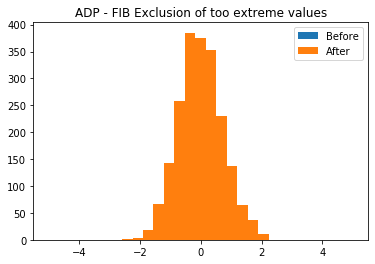

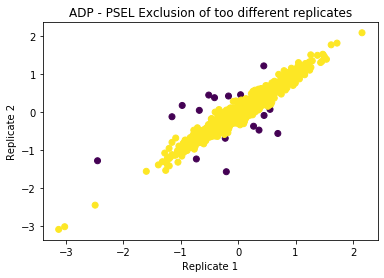

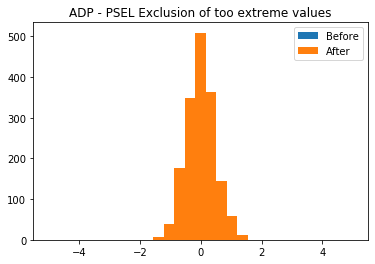

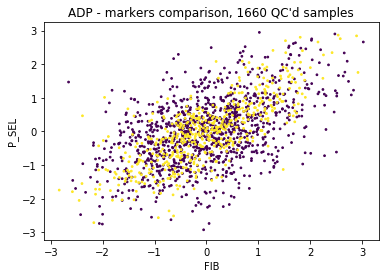

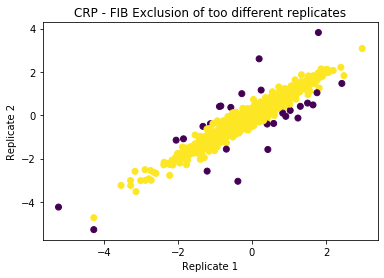

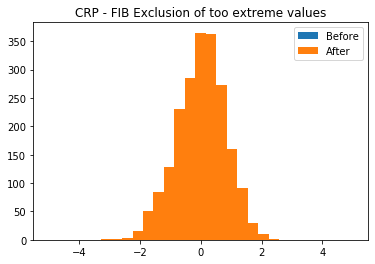

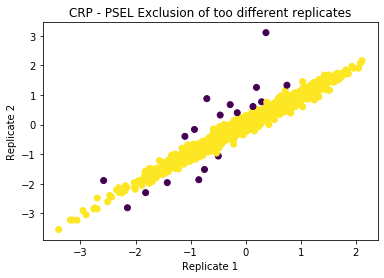

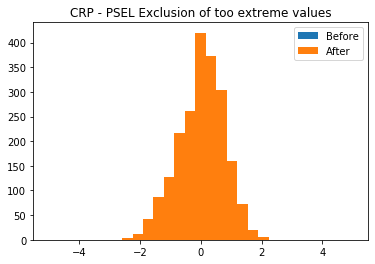

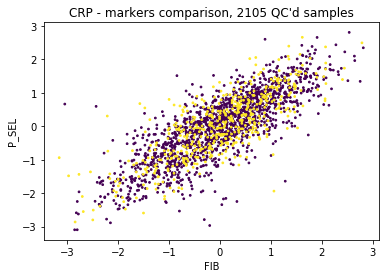

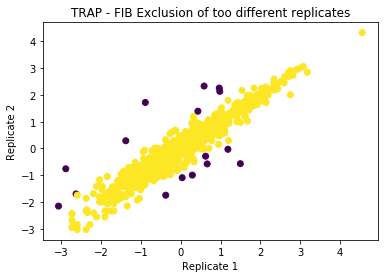

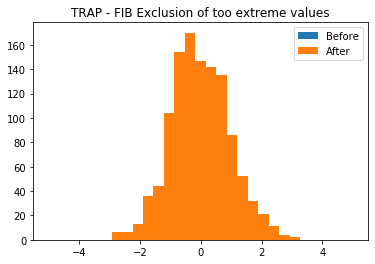

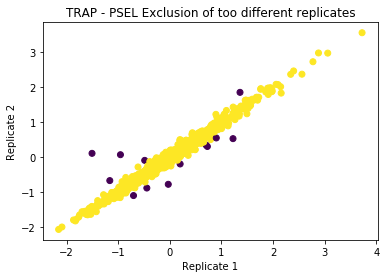

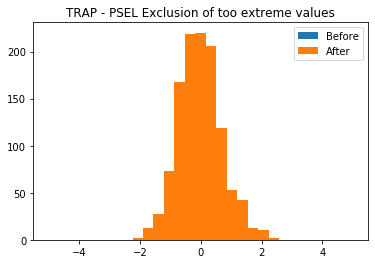

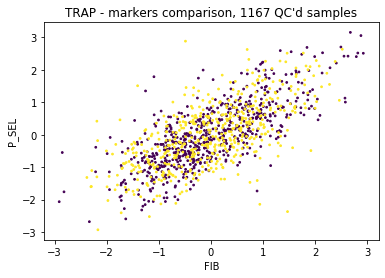

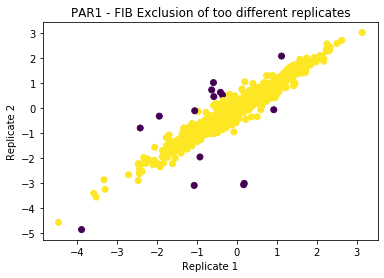

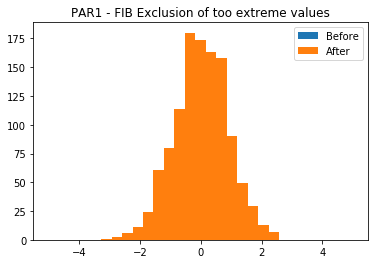

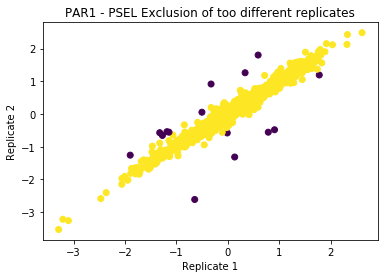

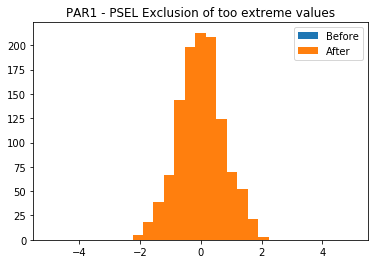

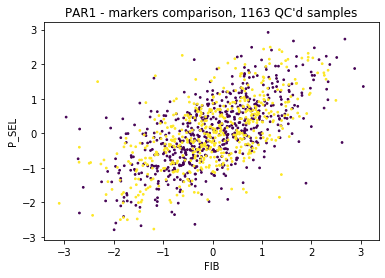

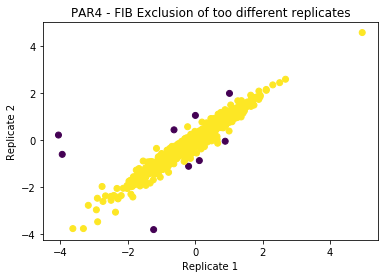

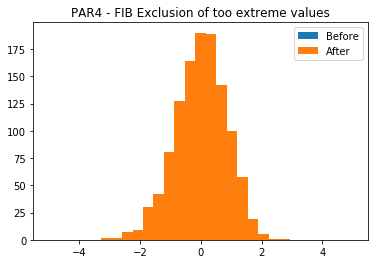

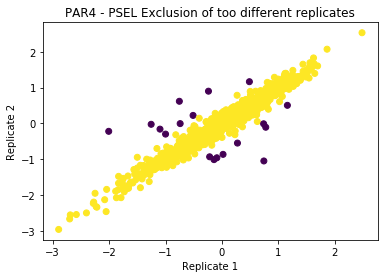

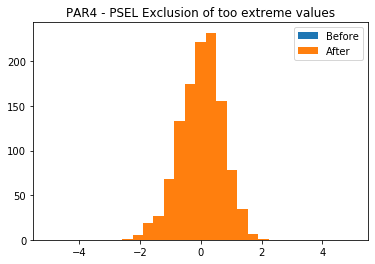

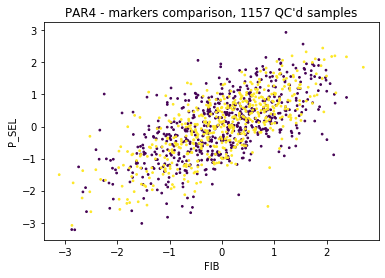

In [298]:
# Actual QC

for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        df["%s_%s_REP_DELTA" % (ago, marker)] = (df["%s_%s_1" % (ago, marker)] - df["%s_%s_2" % (ago, marker)])
        df["%s_%s_REP_OK" % (ago, marker)] = df["%s_%s_REP_DELTA" % (ago, marker)].abs() < 4*df["%s_%s_REP_DELTA" % (ago, marker)].abs().std()
        df["%s_%s" % (ago, marker)] = 0.5*(df["%s_%s_1" % (ago, marker)] + df["%s_%s_2" % (ago, marker)])
        plt.figure()
        plt.title("%s - %s Exclusion of too different replicates" % (ago, marker))
        plt.scatter(df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_1" % (ago, marker)],
            df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_2" % (ago, marker)],
            c = df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_REP_OK" % (ago, marker)])
        plt.xlabel("Replicate 1")
        plt.ylabel("Replicate 2")

        df["%s_%s_VAL_OK" % (ago, marker)] = False
        for cohort in df.PROJECT.unique().tolist():
            inc_cond = (df["%s_%s_REP_OK" % (ago, marker)] == 1) & (df.PROJECT == cohort)
            df.loc[inc_cond,"%s_%s_VAL_OK" % (ago, marker)] = \
                (df.loc[inc_cond,"%s_%s" % (ago, marker)] - df.loc[inc_cond,"%s_%s" % (ago, marker)].mean()).abs() \
                < 3*df.loc[inc_cond,"%s_%s" % (ago, marker)].std()
        
        plt.figure()
        plt.title("%s - %s Exclusion of too extreme values" % (ago, marker))
            
        #b = np.linspace(df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].min()-1,
        #               df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].max()+1,30)

        b = np.linspace(-5,5,30)
        df["%s_%s_QC_OK" % (ago, marker)] = df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)]
        df.loc[df["OK_%s_%s" % (ago,marker)]*\
                     df["%s_%s_QC_OK" % (ago,marker)] == 0,
                     "%s_%s" % (ago,marker)] = np.nan
        
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                            *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="Before")
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="After")
        plt.legend()

        print("Before Normalization")
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].mean())
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].count())
        
        for cohort in df.PROJECT.unique().tolist():
            cohort_valid_cond = ~df["%s_%s" % (ago,marker)].isnull() & (df.PROJECT == cohort)
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] -= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].mean()
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] /= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].std()
    
    df[ago] = 0.5*(df["%s_%s" % (ago, "FIB")] + df["%s_%s" % (ago, "PSEL")])
    
    plt.figure()
    plt.title("%s - markers comparison, %d QC'd samples" % (ago, df["%s_%s_QC_OK" % (ago, marker)].sum()))
    plt.scatter(df.loc[df["%s_%s_QC_OK" % (ago, "FIB" )] & df["%s_%s_QC_OK" % (ago, "PSEL")] == True,"%s_%s" % (ago, "FIB")],
                df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"%s_%s" % (ago, "PSEL")],
                c = df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"PROJECT"].str.contains("4"),
                s=3)
    plt.xlabel("FIB")
    plt.ylabel("P_SEL")

## Adjust phenotypes

In [299]:
df.PROJECT.value_counts()

PFC_3      649
PFC_1      506
PFC_2      450
PFC_4      443
PFC_4_U     94
Name: PROJECT, dtype: int64

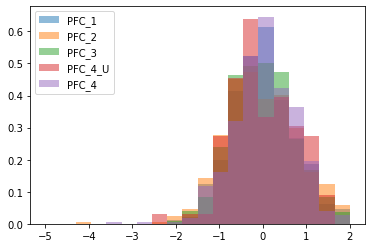

In [300]:
for p in df.PROJECT.unique().tolist():
    plt.hist(df.loc[df.PROJECT == p,"ADP_FIB_1"],label=p,range=(-5,2),density=True,alpha=.5,bins=20)
    plt.legend()

In [301]:
pheno_meta_df = pd.read_csv("%s/metadata_PF/PLATELET_FUNCTION_METADATA_KD_11062019.txt" % data_dir,sep="\t")

In [302]:
df = pd.merge(df,pheno_meta_df[["SAMPLE_ID","SEX","AGE","PLT","MPV"]],left_on="SAMPLE_ID",right_on="SAMPLE_ID")

### Sex

In [311]:
df.groupby("SEX")[["ADP","CRP","PAR1","PAR4","TRAP"]].mean()

ADP       CRP      PAR1      PAR4      TRAP
SEX                                                  
F   -0.049782 -0.039940  0.029239 -0.041997  0.015001
M    0.057313  0.039102 -0.012025  0.107913 -0.028732

In [312]:
df["is_MAN"] = df.SEX == "M"
df.loc[df.SEX.isnull(),"is_MAN"] = np.nan

In [314]:
df.groupby("is_MAN")[["ADP","CRP","PAR1","PAR4","TRAP"]].mean()

ADP       CRP      PAR1      PAR4      TRAP
is_MAN                                                  
0.0    -0.049782 -0.039940  0.029239 -0.041997  0.015001
1.0     0.057313  0.039102 -0.012025  0.107913 -0.028732

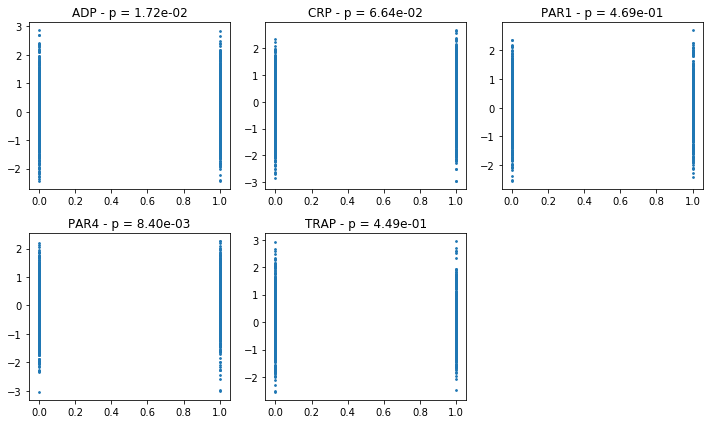

In [313]:
plt.figure(figsize=(10,6))
for i,pheno in enumerate(["ADP","CRP","PAR1","PAR4","TRAP"]):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(df["is_MAN"],df[pheno],s=3)
    cond = ~(df.is_MAN.isnull() | df[pheno].isnull())
    stat = pearsonr(df.loc[cond,"is_MAN"], df.loc[cond,pheno])
    ax.set_title("%s - p = %.2e" % (pheno,stat[1]))
plt.tight_layout()

### Age

In [315]:
from scipy.stats import pearsonr

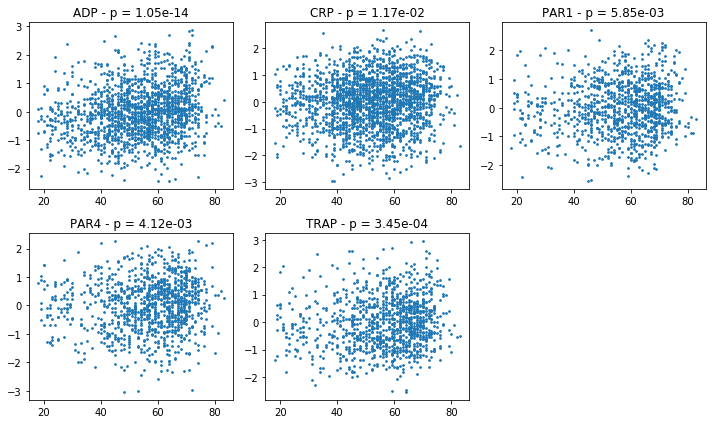

In [316]:
plt.figure(figsize=(10,6))
for i,pheno in enumerate(["ADP","CRP","PAR1","PAR4","TRAP"]):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(df["AGE"],df[pheno],s=3)
    cond = ~(df.AGE.isnull() | df[pheno].isnull())
    stat = pearsonr(df.loc[cond,"AGE"], df.loc[cond,pheno])
    ax.set_title("%s - p = %.2e" % (pheno,stat[1]))
plt.tight_layout()

Since we observe significant correlations, we adjust phenotypes by Age

In [338]:
pheno_columns = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

In [317]:
#for p in pheno_columns:
#    cond = ~(df.AGE.isnull() | df[pheno].isnull())
#    X = np.reshape(df.loc[cond,"AGE"].copy().values,(-1,1))
#    Y = df.loc[cond,pheno].copy()
#    lm = LinearRegression().fit(X,Y)
#    Y_adjust = Y - lm.predict(X)
#    df[pheno] = np.nan
#    df.loc[cond,pheno] = Y_adjust

### Time

In [336]:
df.PROJECT.value_counts()

PFC_3      600
PFC_1      505
PFC_2      450
PFC_4      442
PFC_4_U     94
Name: PROJECT, dtype: int64

Only PFC_4 and PFC_4_U will be included later

In [321]:
df.DATE = pd.to_datetime(df.DATE,format="%d/%m/%y")
day_1_pfc_4 = df.loc[df.PROJECT == "PFC_4","DATE"].min()
df["DAYS"] = (df.DATE - day_1_pfc_4).dt.days

In [325]:
df.sort_values("DATE")

PROJECT     SAMPLE_ID       DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
0      PFC_1  100010100138 2005-01-08   -0.219761    0.072761          NaN   
16     PFC_1  100010100154 2005-01-08    0.212542    0.079817          NaN   
15     PFC_1  100010100153 2005-01-08   -0.196976   -0.223558          NaN   
14     PFC_1  100010100152 2005-01-08   -0.201494    0.221195          NaN   
13     PFC_1  100010100151 2005-01-08    0.018301   -0.209583          NaN   
...      ...           ...        ...         ...         ...          ...   
2086   PFC_4        C1A2PI 2018-11-28   -0.499027   -0.029118    -0.137659   
2087   PFC_4        C1A2RE 2018-11-29    0.508091    0.748296    -0.166792   
2088   PFC_4        C1A2TA 2018-11-29   -0.123331   -0.724070    -0.576097   
2089   PFC_4        C1A2X2 2018-11-30    0.524721   -0.001618    -0.770366   
2090   PFC_4        C1A32N 2018-12-05    1.356199    1.395880    -0.494544   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR4_PSEL  \
0             NaN   0.291696   0.143457   0.491260  ...        NaN   
16            NaN   0.006986   0.133051  -0.281026  ...        NaN   
15            NaN   1.058391   1.277930  -0.498618  ...        NaN   
14            NaN   0.088986   0.502521   0.142162  ...        NaN   
13            NaN   0.910599   0.103554  -0.935827  ...        NaN   
...           ...        ...        ...        ...  ...        ...   
2086    -0.100298  -0.012903  -0.054591  -1.255076  ...  -1.716858   
2087    -0.215388   0.454233   0.438132   0.905671  ...  -0.871210   
2088    -0.664206   0.015207  -0.229225  -3.277229  ...  -1.771021   
2089    -0.929216   0.908069   0.839064   0.488176  ...  -1.282156   
2090    -0.428311   1.195611   1.305060   1.336172  ...  -0.387932   

      PAR4_PSEL_VAL_OK  PAR4_PSEL_QC_OK      PAR4  SEX   AGE     PLT   MPV  \
0                False                0       NaN    M  40.0  209.79   9.1   
16               False                0       NaN    M  40.0  205.35   8.5   
15               False                0       NaN    M  53.0  187.59   9.7   
14               False                0       NaN    M  56.0  170.94   9.3   
13               False                0       NaN    M  56.0  143.19   8.3   
...                ...              ...       ...  ...   ...     ...   ...   
2086              True                1 -1.183119    M  69.0  230.00  10.4   
2087              True                1 -0.395248    M  60.0  221.00  10.8   
2088              True                1 -1.128241    F  42.0  232.00   9.9   
2089              True                1 -0.185643    M  71.0  190.00   9.6   
2090              True                1  0.378871    F  44.0  225.00  11.0   

      is_MAN  DAYS  
0        1.0 -4575  
16       1.0 -4575  
15       1.0 -4575  
14       1.0 -4575  
13       1.0 -4575  
...      ...   ...  
2086     1.0   497  
2087     1.0   498  
2088     0.0   498  
2089     1.0   499  
2090     0.0   504  

[2091 rows x 108 columns]

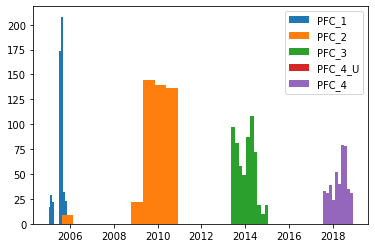

In [330]:
plt.figure()
for p in df.PROJECT.unique().tolist():
    cond = (df.PROJECT == p)
    plt.hist(df.loc[cond,"DATE"],label=p)
plt.legend()

In [344]:
df = df.loc[df.PROJECT.str.contains("PFC_4")]

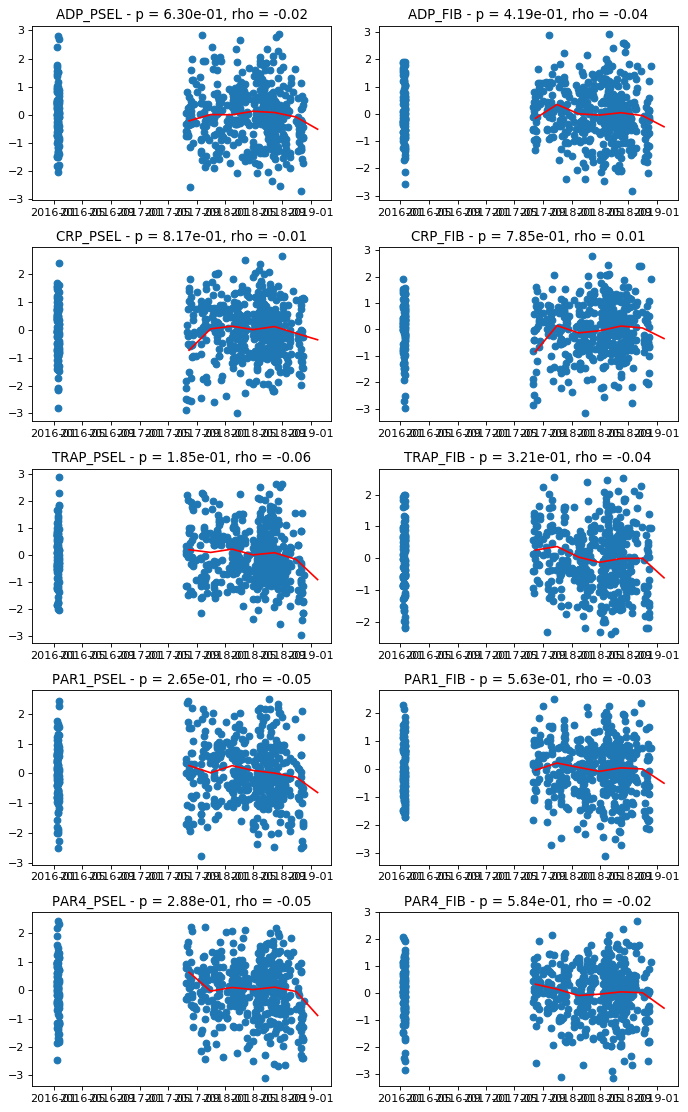

In [345]:
plt.figure(figsize=(13,14),dpi=80)

cond = df.PROJECT.isin(["PFC_4","PFC_4_U"])

for i, pheno in enumerate(pheno_columns):
    if "FIB" in pheno or "PSEL" in pheno:
        ax = plt.subplot(5,3,i+1)
        ax.scatter(df.loc[cond,"DATE"],df.loc[cond,pheno],label=project)
        ax.plot(df.loc[cond].groupby([pd.Grouper(key='DATE', freq='3M')])[pheno].mean(),color="red")
        cond_stat = cond & ~(df.DAYS.isnull() | df[pheno].isnull())
        stat = pearsonr(df.loc[cond_stat,"DAYS"], df.loc[cond_stat,pheno])
        ax.set_title("%s - p = %.2e, rho = %.2f" % (pheno,stat[1],stat[0]))
    
plt.tight_layout()

For PFC_4_U, group by day and adjust means

In [348]:
df = df.sort_values("DATE")
df["order"] = np.arange(df.shape[0])

In [352]:
cond = df.PROJECT.isin(["PFC_4_U"])
df.loc[cond,"group"] = df.loc[cond,"order"] // 30

for i, pheno in enumerate(pheno_columns):
    if "FIB" in pheno or "PSEL" in pheno:
        for g in df.loc[cond,"group"]:
            s_cond = cond & (df.group == g)
            df.loc[s_cond,pheno] -= df.loc[s_cond,pheno].mean()

In [353]:
cond = df.PROJECT.isin(["PFC_4"])
df.loc[cond,"group"] = df.loc[cond,"order"] // 30

for i, pheno in enumerate(pheno_columns):
    if "FIB" in pheno or "PSEL" in pheno:
        for g in df.loc[cond,"group"]:
            s_cond = cond & (df.group == g)
            df.loc[s_cond,pheno] -= df.loc[s_cond,pheno].mean()

ADP_PSEL
ADP_FIB
ADP
CRP_PSEL
CRP_FIB
CRP
TRAP_PSEL
TRAP_FIB
TRAP
PAR1_PSEL
PAR1_FIB
PAR1
PAR4_PSEL
PAR4_FIB
PAR4


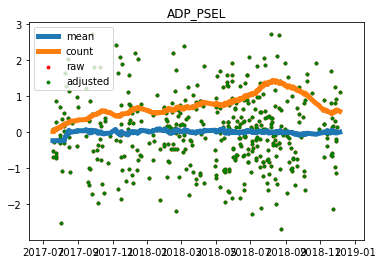

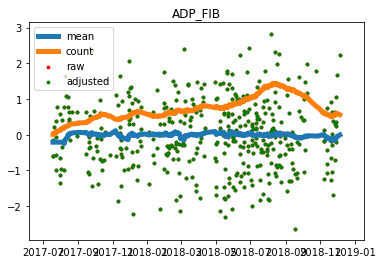

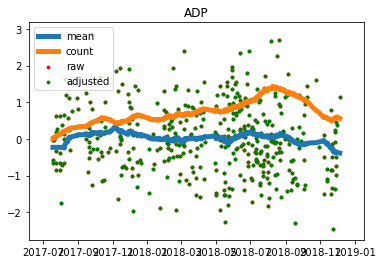

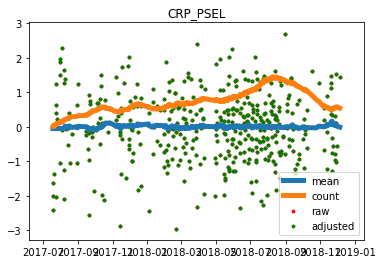

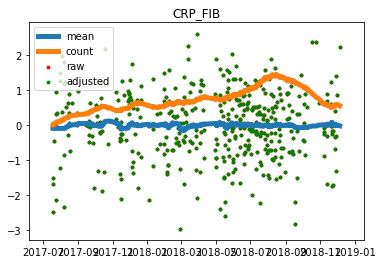

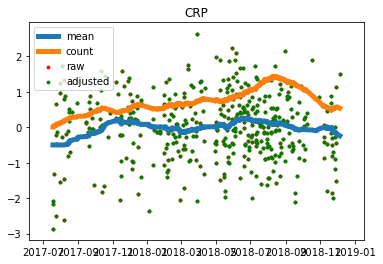

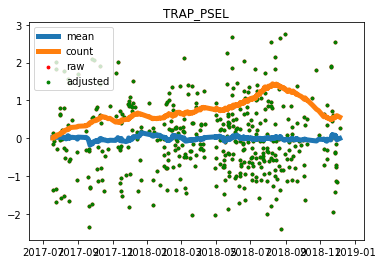

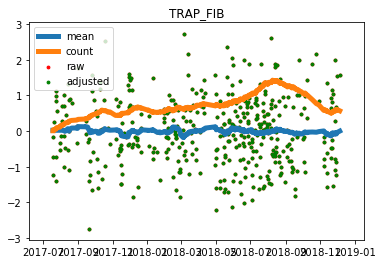

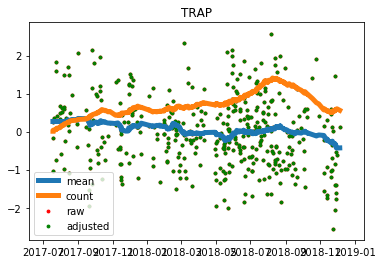

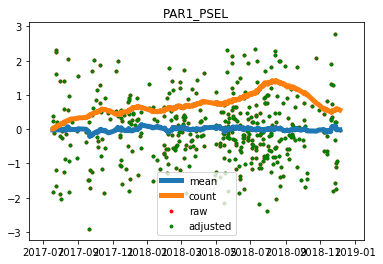

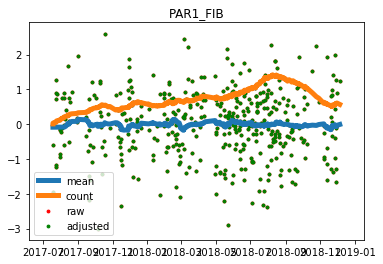

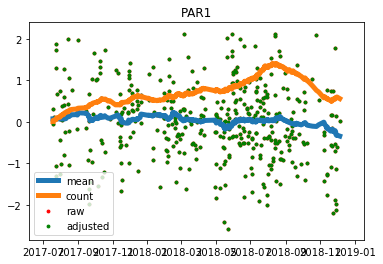

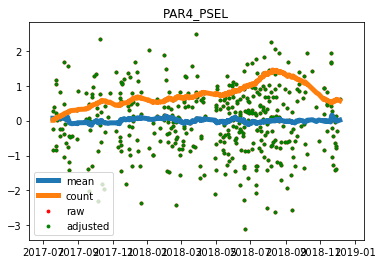

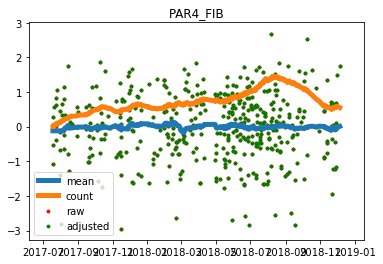

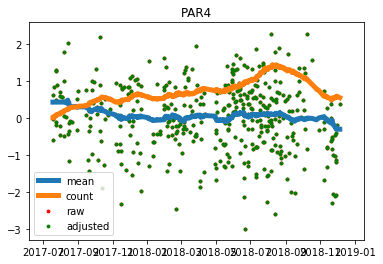

In [354]:
for p in pheno_columns:
    if p not in df.columns:
        continue
    print(p)
    # 45 days and min_count of 20 -> no improvement
    # SHould be improved, cluster points and apply adjustments on clusters.
    roll_count = df.loc[df.PROJECT == "PFC_4",[p,"DATE"]].rolling(window="90D",on="DATE").count()[p]
    roll_mean = df.loc[df.PROJECT == "PFC_4",[p,"DATE"]].rolling(window="90D",on="DATE").mean()[p]
    roll_mean.loc[roll_count < 20] = np.nan
    roll_mean = roll_mean.fillna(method="bfill")
    plt.figure()
    
    plt.scatter(df.loc[df.PROJECT == "PFC_4","DATE"],
                df.loc[df.PROJECT == "PFC_4",p],s=8,label="raw",c="red")
    plt.plot(df.loc[df.PROJECT == "PFC_4","DATE"],roll_mean,label="mean",lw=5)
    plt.plot(df.loc[df.PROJECT == "PFC_4","DATE"],roll_count/100,label="count",lw=5)
    
    #df.loc[df.PROJECT == "PFC_4",p] -= roll_mean
    plt.scatter(df.loc[df.PROJECT == "PFC_4","DATE"],
                df.loc[df.PROJECT == "PFC_4",p],s=8,label="adjusted",c="green")
    plt.legend()
    plt.title(p)

## Summary of cohort sizes

In [355]:
for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        print("%s - %s" % (ago, marker))
        print("Two replicates : \t\t%d" % df["OK_%s_%s" % (ago, marker)].sum())
        print("Coherent replicates : \t\t%d" % df["%s_%s_REP_OK" % (ago, marker)].sum())
        print("After outliers removal : \t%d" % df["%s_%s_VAL_OK" % (ago, marker)].sum())

df.loc[df.SAMPLE_ID.isin(sys_phen.ID.unique().tolist())].groupby("PROJECT")["SAMPLE_ID"].nunique()

ADP - FIB
Two replicates : 		536
Coherent replicates : 		530
After outliers removal : 	527
ADP - PSEL
Two replicates : 		536
Coherent replicates : 		534
After outliers removal : 	530
CRP - FIB
Two replicates : 		536
Coherent replicates : 		531
After outliers removal : 	527
CRP - PSEL
Two replicates : 		536
Coherent replicates : 		532
After outliers removal : 	529
TRAP - FIB
Two replicates : 		536
Coherent replicates : 		524
After outliers removal : 	523
TRAP - PSEL
Two replicates : 		536
Coherent replicates : 		527
After outliers removal : 	526
PAR1 - FIB
Two replicates : 		536
Coherent replicates : 		528
After outliers removal : 	524
PAR1 - PSEL
Two replicates : 		536
Coherent replicates : 		530
After outliers removal : 	526
PAR4 - FIB
Two replicates : 		536
Coherent replicates : 		530
After outliers removal : 	527
PAR4 - PSEL
Two replicates : 		536
Coherent replicates : 		534
After outliers removal : 	531


PROJECT
PFC_4      442
PFC_4_U     94
Name: SAMPLE_ID, dtype: int64

## Export phenotypes

In [356]:
pheno_df = df[["SAMPLE_ID"] + pheno_columns]
# TRAP AND PAR1 are very correlated, we create a phenotype with their average
pheno_df["TRAP_PAR1"] = 0.5*(pheno_df["TRAP"] + pheno_df["PAR1"])
pheno_df["TRAP_PAR1"] /= pheno_df["TRAP_PAR1"].std()
pheno_df["PSEL"] = pheno_df[[c for c in pheno_df.columns if "PSEL" in c]].mean(axis=1)
pheno_df["PSEL"] /= pheno_df.PSEL.std()
pheno_df["FIB"] = pheno_df[[c for c in pheno_df.columns if "FIB" in c]].mean(axis=1)
pheno_df["FIB"] /= pheno_df.FIB.std()

In [357]:
pheno_df.head()

SAMPLE_ID  ADP_PSEL   ADP_FIB       ADP  CRP_PSEL   CRP_FIB       CRP  \
1559    C0WX8R  0.113507 -0.195311  0.163418  0.407207  0.021471  0.386614   
1558    C0WX7T  1.407954  1.192808  1.504701  1.412682  1.318541  1.537886   
1560    C0WXBL -0.512954 -1.491529 -0.797922 -1.522184 -1.516019 -1.346827   
1556    C0WX4Z  0.663381  0.364977  0.718499  0.272896  0.106651  0.362048   
1555    C0WX14  0.093590  1.303313  0.902771  1.346981  1.679039  1.685285   

      TRAP_PSEL  TRAP_FIB      TRAP  PAR1_PSEL  PAR1_FIB      PAR1  PAR4_PSEL  \
1559  -0.402280 -1.021397 -0.665308  -0.502064 -1.124447 -0.697452   0.045208   
1558   0.603707  0.437964  0.567365   0.309414  0.743840  0.642431  -0.279585   
1560   0.213978 -1.455417 -0.574189   0.069064 -0.923877 -0.311602  -0.178628   
1556  -0.302487 -1.057072 -0.633250        NaN       NaN       NaN  -0.286667   
1555  -0.397165  1.733424  0.714659  -0.166954  1.390161  0.727408  -0.806256   

      PAR4_FIB      PAR4  TRAP_PAR1      PSEL       FIB  
1559 -0.205524  0.101175  -0.781577 -0.095538 -0.618033  
1558  0.174565  0.128823   0.693849  0.975131  0.946606  
1560 -1.413178 -0.614570  -0.508023 -0.545054 -1.664272  
1556 -0.160701 -0.042351        NaN  0.122493 -0.228270  
1555  0.857695  0.207053   0.827061  0.019816  1.704316

In [358]:
print("# of samples in total %d" % pheno_df.shape[0])
pheno_df = pheno_df.loc[pheno_df.SAMPLE_ID.isin(sys_phen.ID.unique().tolist())]
pheno_df.set_index("SAMPLE_ID",inplace=True)
print("# of samples in Sysmex WB dataset %d" % pheno_df.shape[0])

# of samples in total 536
# of samples in Sysmex WB dataset 536


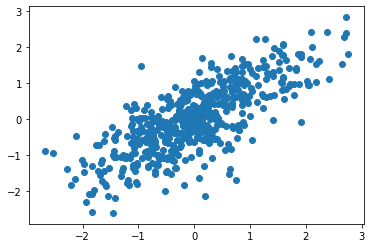

In [359]:
plt.scatter(pheno_df["ADP_PSEL"],pheno_df["ADP_FIB"])

In [360]:
pheno_df.to_hdf("%s/pheno_df.hdf" % training_data,key="pheno_df")
df.to_hdf("%s/df_all_columns.hdf" % training_data,key="all_columns")

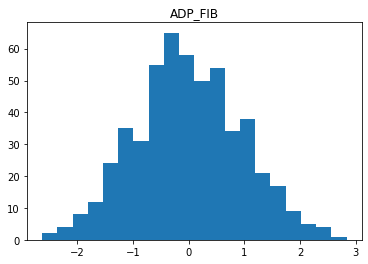

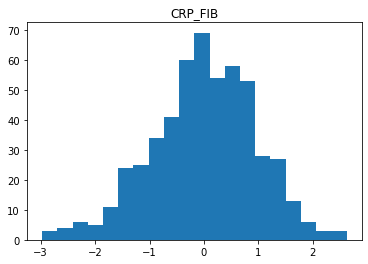

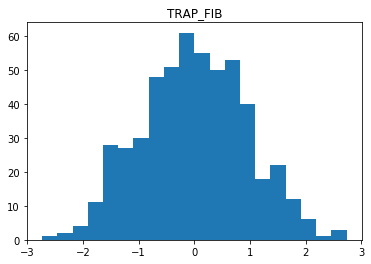

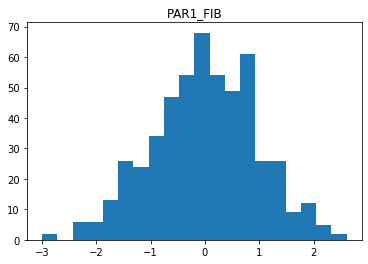

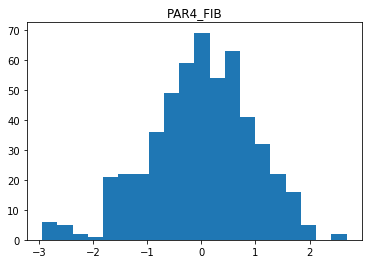

In [361]:
for c in pheno_cols:
    plt.figure()
    plt.hist(pheno_df[c],bins=20)
    plt.title(c)

# Prepare prediction input

Rerun with
- One folder per tag (move existing outputs to a new folder)
- int_sct adjusted by machine

In [3]:
int_sct = pd.read_hdf("%s/int_sct_discrepancy_adjusted.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)

In [4]:
df = pd.read_hdf("%s/df_all_columns.hdf" % training_data)

In [5]:
df.head()

PROJECT SAMPLE_ID       DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
1559  PFC_4_U    C0WX8R 2016-01-12   -1.117794   -0.951069    -0.234577   
1558  PFC_4_U    C0WX7T 2016-01-12   -0.010914    0.576895     0.270801   
1560  PFC_4_U    C0WXBL 2016-01-12   -0.898536   -0.640624    -0.560580   
1556  PFC_4_U    C0WX4Z 2016-01-12   -0.735112   -2.031737     0.063618   
1555  PFC_4_U    C0WX14 2016-01-12    1.979151    2.007390    -0.452823   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR4_PSEL_QC_OK  \
1559    -0.249044   0.131977  -0.016889   0.244401  ...                1   
1558     0.405902   0.991922   0.957245   1.627910  ...                1   
1560    -0.491976  -0.814314  -0.783250  -1.234146  ...                1   
1556    -0.137273   0.272949   0.582431   0.547542  ...                1   
1555    -0.392173   1.036594   1.058580   2.052054  ...                1   

          PAR4  SEX   AGE    PLT   MPV  is_MAN  DAYS  order  group  
1559  0.101175    F  71.0  255.0  10.9     0.0  -554      0    0.0  
1558  0.128823    F  70.0  265.0  11.1     0.0  -554      1    0.0  
1560 -0.614570    F  58.0  358.0  10.1     0.0  -554      2    0.0  
1556 -0.042351    F  63.0  243.0  10.2     0.0  -554      3    0.0  
1555  0.207053    F  67.0  258.0   9.3     0.0  -554      4    0.0  

[5 rows x 110 columns]

## Build features

### fit PCA

In [6]:
pca = PCA(whiten=True,n_components=2)

In [7]:
def sub_sample(df):
    return df.sample(3000,replace=True)
X = sys_sct.groupby("ID")[FACS_cols].apply(sub_sample)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.91528321 0.05808418]


### Compute features

In [8]:
sct = pd.concat((sys_sct[FACS_cols + ["ID"]],int_sct[FACS_cols + ["ID"]]),axis=0)

In [9]:
X_t = pca.transform(sct[FACS_cols])
sct["X_0"] = X_t[:,0]
sct["X_1"] = X_t[:,1]
cond = (sct.X_0 > sct.X_0.quantile(0.005)) & (sct.X_0 < sct.X_0.quantile(0.995)) & (sct.X_1 > sct.X_1.quantile(0.005)) & (sct.X_1 < sct.X_1.quantile(0.995))
#sct = sct.loc[cond]

In [20]:
sys_IDs = sys_sct.ID.unique().tolist()

In [50]:
ID1 = "C1A21T"
ID2 = "C19RQZ"

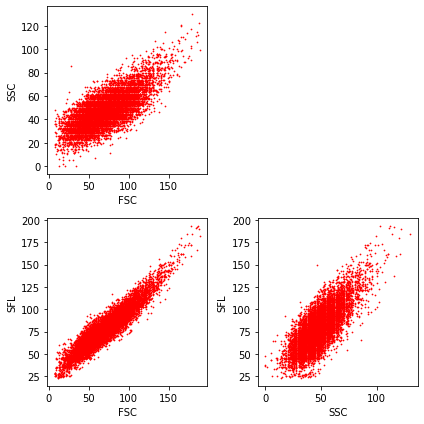

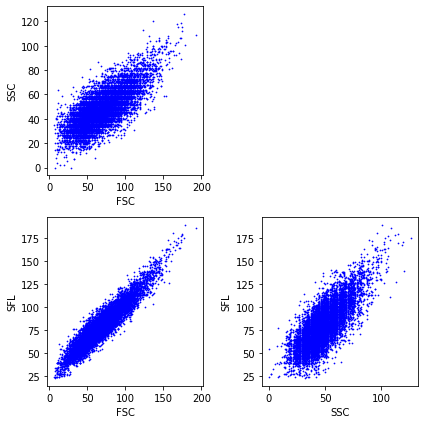

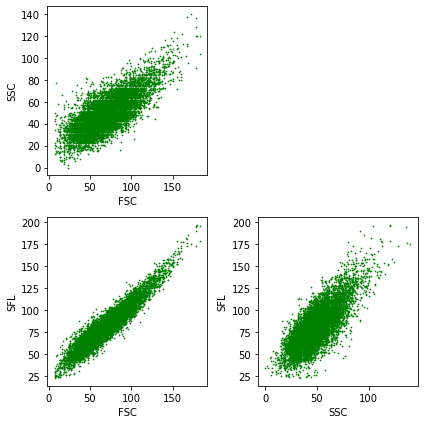

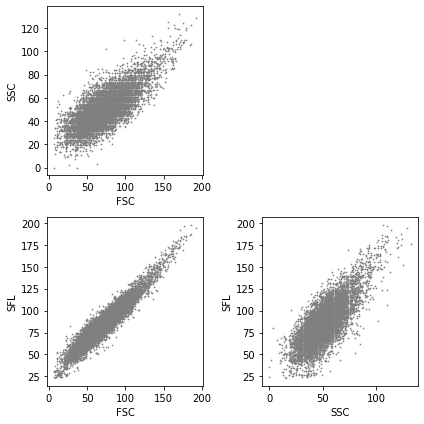

In [54]:
colors = ["red","blue","green","grey"]
for i, ID in enumerate(sys_IDs[:4]):
    fig = plt.figure(figsize=(6,6))
    sub_sct = sct.loc[sct.ID == ID].sample(int(1e4))
    ax = fig.add_subplot(221)
    ax.scatter(sub_sct["FSC"],sub_sct["SSC"],s=.5,c=colors[i],cmap="bwr")
    ax.set_xlabel("FSC")
    ax.set_ylabel("SSC")
    ax = fig.add_subplot(223)
    ax.scatter(sub_sct["FSC"],sub_sct["SFL"],s=.5,c=colors[i],cmap="bwr")
    ax.set_xlabel("FSC")
    ax.set_ylabel("SFL")
    ax = fig.add_subplot(224)
    ax.scatter(sub_sct["SSC"],sub_sct["SFL"],s=.5,c=colors[i],cmap="bwr")
    ax.set_xlabel("SSC")
    ax.set_ylabel("SFL")
    #ax.set_xlim((-3,3))
    #ax.set_ylim((-3,3))
    #ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig("%s/figures/Sysmex_scatter_%s.pdf" % (export_folder,ID))

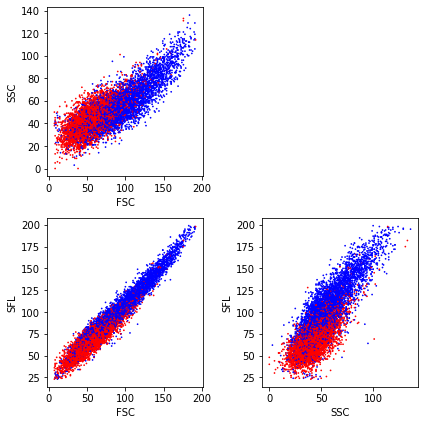

In [59]:
fig = plt.figure(figsize=(6,6))
sub_sct = pd.concat([sct.loc[sct["ID"] == ID].sample(int(1e4)) for ID in [ID1,ID2]],axis=0).sample(int(1e4))
ax = fig.add_subplot(221)
ax.scatter(sub_sct["FSC"],sub_sct["SSC"],s=.5,c=sub_sct.ID == ID1,cmap="bwr")
ax.set_xlabel("FSC")
ax.set_ylabel("SSC")
ax = fig.add_subplot(223)
ax.scatter(sub_sct["FSC"],sub_sct["SFL"],s=.5,c=sub_sct.ID == ID1,cmap="bwr")
ax.set_xlabel("FSC")
ax.set_ylabel("SFL")
ax = fig.add_subplot(224)
ax.scatter(sub_sct["SSC"],sub_sct["SFL"],s=.5,c=sub_sct.ID == ID1,cmap="bwr")
ax.set_xlabel("SSC")
ax.set_ylabel("SFL")
#ax.set_xlim((-3,3))
#ax.set_ylim((-3,3))
#ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("%s/figures/Sysmex_scatter_example.pdf" % export_folder)

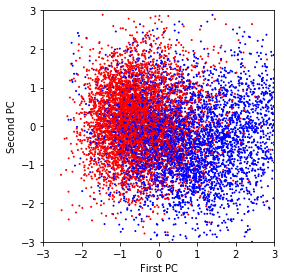

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
sub_sct = pd.concat([sct.loc[sct["ID"] == ID].sample(int(1e4)) for ID in [ID1,ID2]],axis=0).sample(int(1e4))
ax.scatter(sub_sct["X_0"],sub_sct["X_1"],s=1,c=sub_sct.ID == ID1,cmap="bwr")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("%s/figures/PC_scatter.pdf" % export_folder)

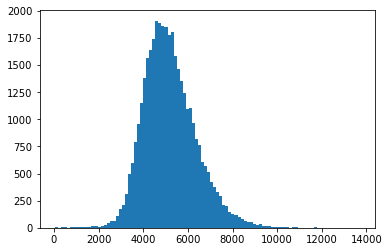

In [19]:
plt.hist(int_sct.groupby("ID")["SSC"].count(),bins=100);

In [124]:
#sct["X_0"] = np.clip(sct["X_0"],
#                     np.quantile(sct["X_0"],0.005),
#                     np.quantile(sct["X_0"],1-0.005))
#sct["X_1"] = np.clip(sct["X_1"],
#                     np.quantile(sct["X_1"],0.005),
#                     np.quantile(sct["X_1"],1-0.005))
g = sct.groupby("ID")[["X_0","X_1"]]
mean = g.mean()
median = g.median()
upper = g.quantile(0.9)
lower = g.quantile(0.1)
std = g.std()
iqr = g.quantile(0.75) - g.quantile(0.25)
skew = g.skew()
ratio_upper = np.log10(upper["X_1"] / upper["X_0"])
ratio_lower = np.log10(lower["X_1"] / lower["X_0"])
ratio_std = np.log10(std["X_1"] / std["X_0"])

up_0 = sct.X_0.quantile(0.7)
low_0 = sct.X_0.quantile(0.3)
g_up = sct.loc[sct.X_0 > up_0].groupby("ID")[["X_1"]]
iqr_up_1 = g_up.quantile(0.75) - g_up.quantile(0.25)
g_low = sct.loc[sct.X_0 < low_0].groupby("ID")[["X_1"]]
iqr_low_1 = g_low.quantile(0.75) - g_low.quantile(0.25)

up_1 = sct.X_1.quantile(0.7)
low_1 = sct.X_1.quantile(0.3)
g_up = sct.loc[sct.X_1 > up_1].groupby("ID")[["X_0"]]
iqr_up_0 = g_up.quantile(0.75) - g_up.quantile(0.25)
g_low = sct.loc[sct.X_1 < low_1].groupby("ID")[["X_0"]]
iqr_low_0 = g_low.quantile(0.75) - g_low.quantile(0.25)

In [125]:
features = pd.concat([mean.rename(columns={"X_0":"mean_0","X_1":"mean_1"}),
           median.rename(columns={"X_0":"median_0","X_1":"median_1"}),
           upper.rename(columns={"X_0":"upper_0","X_1":"upper_1"}),
           lower.rename(columns={"X_0":"lower_0","X_1":"lower_1"}),
           std.rename(columns={"X_0":"std_0","X_1":"std_1"}),
           iqr.rename(columns={"X_0":"iqr_0","X_1":"iqr_1"}),
           iqr_up_1.rename(columns={"X_1":"iqr_up_1"}),
           iqr_low_1.rename(columns={"X_1":"iqr_low_1"}),
           iqr_up_0.rename(columns={"X_0":"iqr_up_0"}),
           iqr_low_0.rename(columns={"X_0":"iqr_low_0"}),
           skew.rename(columns={"X_0":"skew_0","X_1":"skew_1"}),
           pd.DataFrame(ratio_upper).rename(columns={0:"ratio_upper"}),
           pd.DataFrame(ratio_lower).rename(columns={0:"ratio_lower"}),
           pd.DataFrame(ratio_std).rename(columns={0:"ratio_std"})],axis=1)
features = features.dropna(how="any",axis=0)

In [126]:
features.head()

mean_0    mean_1  median_0  median_1   upper_0   upper_1   lower_0  \
ID                                                                             
C0WX4Z -0.026078 -0.044876 -0.125952 -0.065231  1.172155  1.167170 -1.079433   
C0WX6V -0.039608  0.000681 -0.128626 -0.022281  1.236116  1.180094 -1.185447   
C0WX7T  0.080688  0.131490  0.001308  0.119090  1.291763  1.337546 -1.016465   
C0WX8R  0.061248 -0.198954 -0.047453 -0.213626  1.355537  0.921343 -1.088894   
C0WXBL -0.074660 -0.078218 -0.157396 -0.086787  1.118868  1.069266 -1.156653   

         lower_1     std_0     std_1  ...     iqr_1  iqr_up_1  iqr_low_1  \
ID                                    ...                                  
C0WX4Z -1.240177  0.894128  0.925976  ...  1.258816  1.400900   1.206601   
C0WX6V -1.161304  0.957929  0.906041  ...  1.225688  1.355716   1.178765   
C0WX7T -1.076549  0.907130  0.923900  ...  1.271411  1.386049   1.183193   
C0WX8R -1.330968  0.969171  0.872985  ...  1.181221  1.271356   1.155199   
C0WXBL -1.222949  0.905953  0.885354  ...  1.189355  1.323387   1.151950   

        iqr_up_0  iqr_low_0    skew_0    skew_1  ratio_upper  ratio_lower  \
ID                                                                          
C0WX4Z  1.268548   1.165620  0.575873  0.172521    -0.001851     0.060288   
C0WX6V  1.413004   1.242551  0.566411  0.174555    -0.020142    -0.008936   
C0WX7T  1.262718   1.169949  0.474162  0.050443     0.015126     0.024941   
C0WX8R  1.369881   1.272869  0.557444  0.191291    -0.167690     0.087182   
C0WXBL  1.263985   1.211976  0.585747  0.134667    -0.019693     0.024205   

        ratio_std  
ID                 
C0WX4Z   0.015200  
C0WX6V  -0.024185  
C0WX7T   0.007955  
C0WX8R  -0.045393  
C0WXBL  -0.009989  

[5 rows x 21 columns]

### Filter and save

In [127]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37960 entries, C0WX4Z to INT_116_999400
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mean_0       37960 non-null  float64
 1   mean_1       37960 non-null  float64
 2   median_0     37960 non-null  float64
 3   median_1     37960 non-null  float64
 4   upper_0      37960 non-null  float64
 5   upper_1      37960 non-null  float64
 6   lower_0      37960 non-null  float64
 7   lower_1      37960 non-null  float64
 8   std_0        37960 non-null  float64
 9   std_1        37960 non-null  float64
 10  iqr_0        37960 non-null  float64
 11  iqr_1        37960 non-null  float64
 12  iqr_up_1     37960 non-null  float64
 13  iqr_low_1    37960 non-null  float64
 14  iqr_up_0     37960 non-null  float64
 15  iqr_low_0    37960 non-null  float64
 16  skew_0       37960 non-null  float64
 17  skew_1       37960 non-null  float64
 18  ratio_upper  37960 non-null  float64


In [128]:
features.to_hdf("%s/features.hdf" % training_data,key="features")

### Adjust wrt time

In [27]:
features = pd.read_hdf("%s/features.hdf" % training_data,key="features")
int_phen = pd.read_hdf("%s/int_phen_adjusted.hdf" % training_data,key="INT_PHEN")

In [28]:
pfc_IDs = sys_sct.ID.unique().tolist()
int_1_IDs = int_phen.loc[int_phen.Instrument == "XN-10^11041"].SampleNo.unique().tolist()
int_2_IDs = int_phen.loc[int_phen.Instrument != "XN-10^11041"].SampleNo.unique().tolist()

#### First, have a look

In [29]:
f2 = features.loc[features.index.isin(int_2_IDs)]
f2 = pd.merge(f2,int_phen,left_index=True,right_on="SampleNo")

In [30]:
f2_sct_mean = int_sct.loc[int_sct.ID.isin(f2.SampleNo.tolist())].groupby("ID")[FACS_cols].mean()

In [31]:
f2 = pd.merge(f2,f2_sct_mean,left_on="SampleNo",right_index=True,how="left")

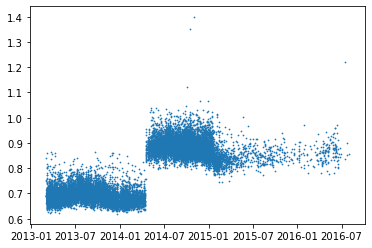

In [32]:
plt.scatter(f2.DateTime,f2["std_1"],s=.5)

#### Now, adjust

In [33]:
orig_features = features.columns

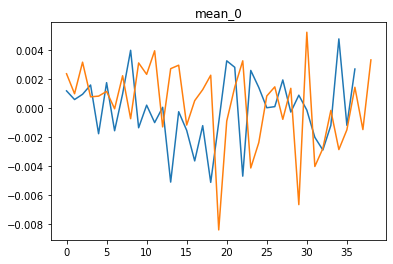

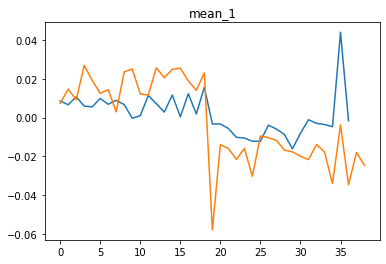

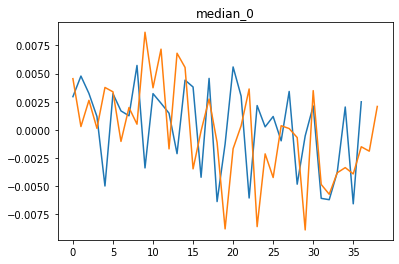

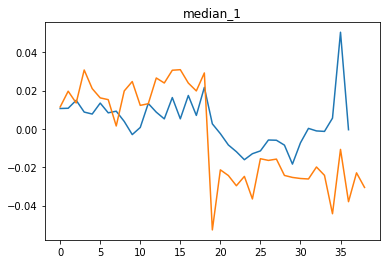

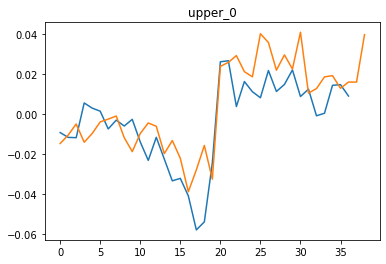

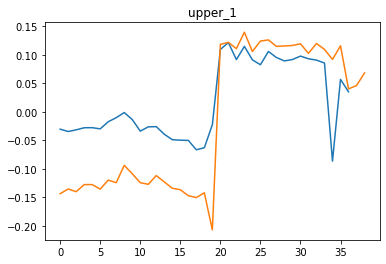

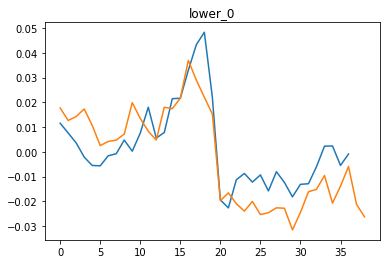

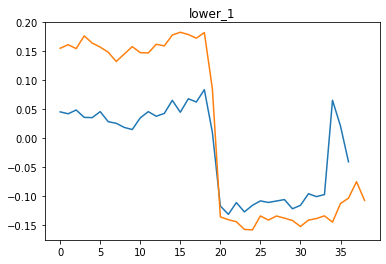

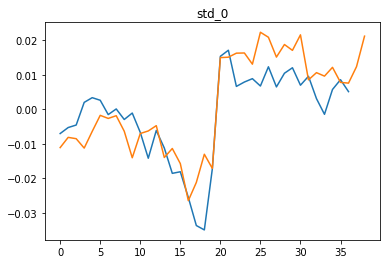

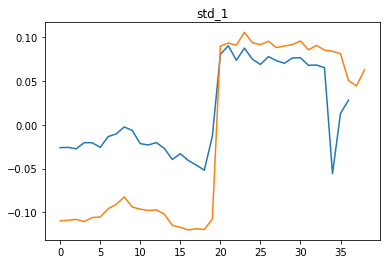

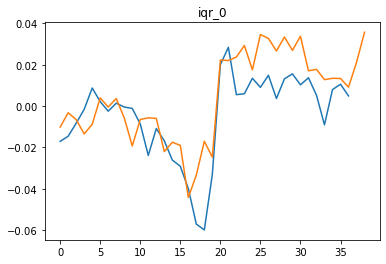

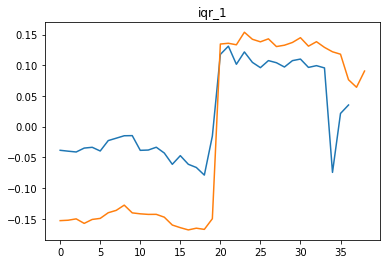

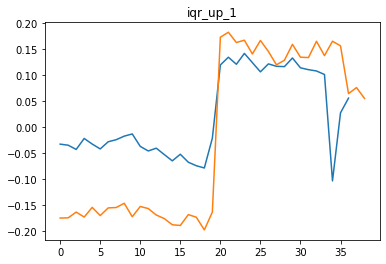

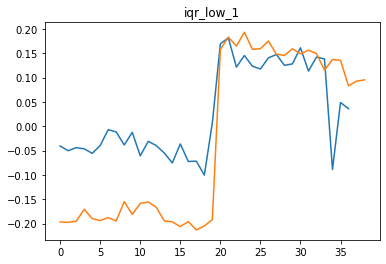

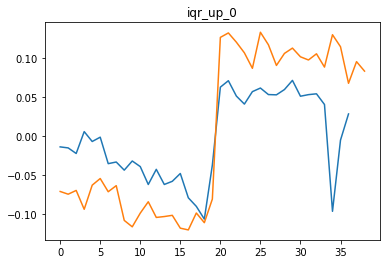

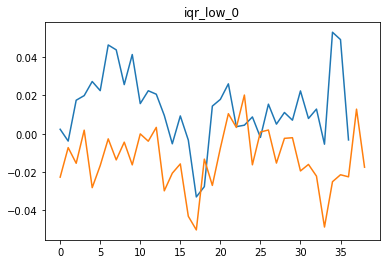

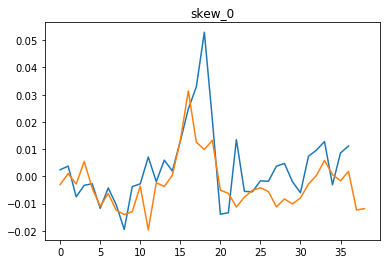

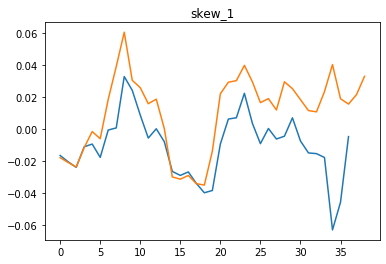

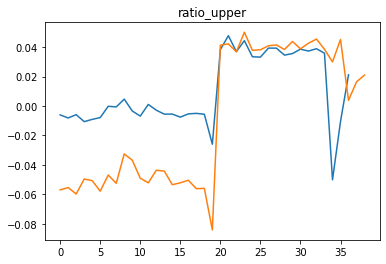

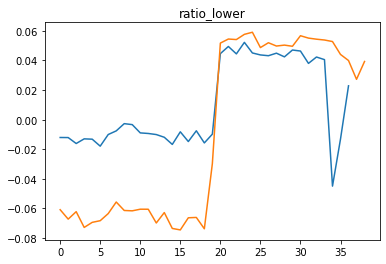

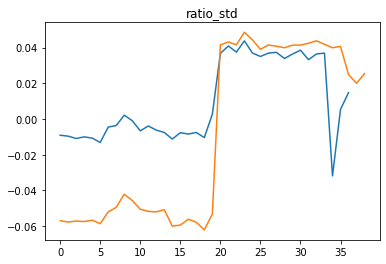

In [34]:
cond_1 = features.index.isin(int_1_IDs)
cond_2 = features.index.isin(int_2_IDs)
for c in features.columns:
    plt.figure()
    mean = features.loc[cond_1 | cond_2,c].mean()
    shifts = []
    for cond in [cond_1,cond_2]:
        f = features.loc[cond].copy()
        f = pd.merge(f,int_phen,left_index=True,right_on="SampleNo",how="left")
        f = f.sort_values("DateTime")
        f.reset_index(inplace=True)
        f["Group"] = f.index // 500
        shift = f.groupby("Group")[[c]].mean() - mean
        plt.plot(shift)
        shift = pd.merge(shift,f,left_index=True,right_on="Group",how="right",suffixes=("_shift",""))
        shifts.append(shift)
    shift = pd.concat(shifts,axis=0)[["SampleNo",c+"_shift"]]
    int_f = features.loc[cond_1 | cond_2]
    int_f = pd.merge(int_f,shift,left_index=True,right_on="SampleNo",how="left")

    int_f[c] = int_f[c] - int_f[c+"_shift"]
    features.loc[cond_1 | cond_2,c] = int_f[c].values
    plt.title(c)

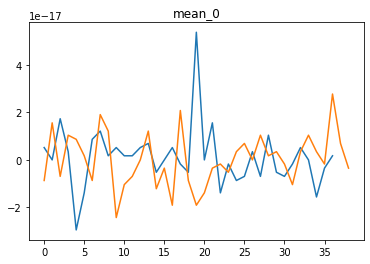

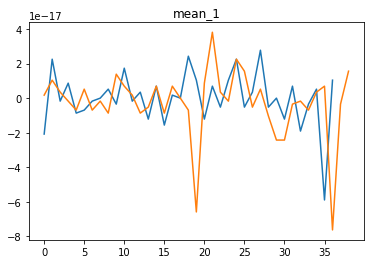

In [35]:
for c in features.columns[:2]:
    plt.figure()
    mean = features.loc[cond_1 | cond_2,c].mean()
    shifts = []
    for cond in [cond_1,cond_2]:
        f = features.loc[cond].copy()
        f = pd.merge(f,int_phen,left_index=True,right_on="SampleNo",how="left")
        f = f.sort_values("DateTime")
        f.reset_index(inplace=True)
        f["Group"] = f.index // 500
        shift = f.groupby("Group")[[c]].mean() - mean
        plt.plot(shift)
    plt.title(c)

In [228]:
features

mean_0    mean_1  median_0  median_1   upper_0   upper_1  \
ID                                                                           
C0WX4Z         -0.026078 -0.044876 -0.125952 -0.065231  1.172155  1.167170   
C0WX6V         -0.039608  0.000681 -0.128626 -0.022281  1.236116  1.180094   
C0WX7T          0.080688  0.131490  0.001308  0.119090  1.291763  1.337546   
C0WX8R          0.061248 -0.198954 -0.047453 -0.213626  1.355537  0.921343   
C0WXBL         -0.074660 -0.078218 -0.157396 -0.086787  1.118868  1.069266   
...                  ...       ...       ...       ...       ...       ...   
INT_116_99700  -0.204897  0.007745 -0.282794 -0.008249  0.985769  1.024114   
INT_116_997100  0.100358 -0.239754  0.019599 -0.263120  1.338881  0.803152   
INT_116_99800  -0.150493 -0.248331 -0.231123 -0.263348  1.001528  0.745115   
INT_116_99900   0.083788 -0.299541 -0.042909 -0.317754  1.448831  0.753988   
INT_116_999400  0.150564 -0.129774  0.055730 -0.158003  1.568887  0.924015   

                 lower_0   lower_1     std_0     std_1  ...     iqr_1  \
ID                                                      ...             
C0WX4Z         -1.079433 -1.240177  0.894128  0.925976  ...  1.258816   
C0WX6V         -1.185447 -1.161304  0.957929  0.906041  ...  1.225688   
C0WX7T         -1.016465 -1.076549  0.907130  0.923900  ...  1.271411   
C0WX8R         -1.088894 -1.330968  0.969171  0.872985  ...  1.181221   
C0WXBL         -1.156653 -1.222949  0.905953  0.885354  ...  1.189355   
...                  ...       ...       ...       ...  ...       ...   
INT_116_99700  -1.308713 -1.003357  0.883805  0.794642  ...  1.046237   
INT_116_997100 -0.992788 -1.269197  0.918237  0.799333  ...  1.073282   
INT_116_99800  -1.204076 -1.234053  0.882904  0.785286  ...  1.007524   
INT_116_99900  -1.105410 -1.321259  0.994108  0.797798  ...  1.090557   
INT_116_999400 -1.099251 -1.127732  1.026533  0.806547  ...  1.070777   

                iqr_up_1  iqr_low_1  iqr_up_0  iqr_low_0    skew_0    skew_1  \
ID                                                                             
C0WX4Z          1.400900   1.206601  1.268548   1.165620  0.575873  0.172521   
C0WX6V          1.355716   1.178765  1.413004   1.242551  0.566411  0.174555   
C0WX7T          1.386049   1.183193  1.262718   1.169949  0.474162  0.050443   
C0WX8R          1.271356   1.155199  1.369881   1.272869  0.557444  0.191291   
C0WXBL          1.323387   1.151950  1.263985   1.211976  0.585747  0.134667   
...                  ...        ...       ...        ...       ...       ...   
INT_116_99700   1.053425   1.048825  1.265629   1.153514  0.472038  0.183358   
INT_116_997100  1.102302   1.126694  1.288574   1.154708  0.491169  0.205038   
INT_116_99800   0.995029   1.062893  1.219499   1.113765  0.610665  0.232044   
INT_116_99900   1.148137   1.074088  1.458336   1.295857  0.539467  0.147503   
INT_116_999400  1.115998   1.053713  1.624244   1.366051  0.457464  0.201415   

                ratio_upper  ratio_lower  ratio_std  
ID                                                   
C0WX4Z            -0.001851     0.060288   0.015200  
C0WX6V            -0.020142    -0.008936  -0.024185  
C0WX7T             0.015126     0.024941   0.007955  
C0WX8R            -0.167690     0.087182  -0.045393  
C0WXBL            -0.019693     0.024205  -0.009989  
...                     ...          ...        ...  
INT_116_99700      0.012730    -0.119571  -0.048400  
INT_116_997100    -0.186301     0.110244  -0.062526  
INT_116_99800     -0.131138     0.008562  -0.052908  
INT_116_99900     -0.287166     0.075934  -0.097704  
INT_116_999400    -0.229513     0.003678  -0.106573  

[37960 rows x 21 columns]

### Check discrepancies

In [ ]:
sys_phen.head()

In [ ]:
pfc_men = sys_

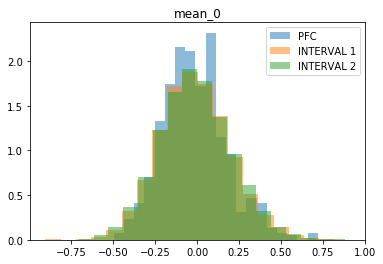

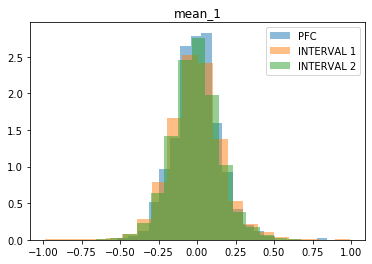

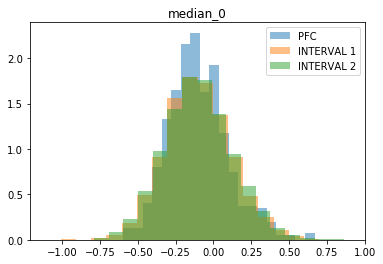

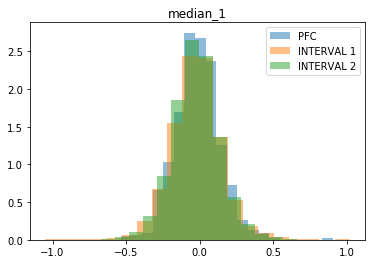

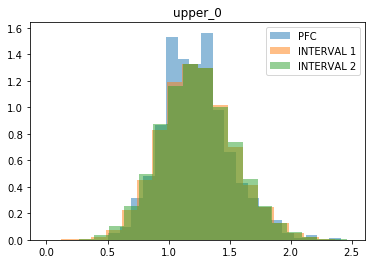

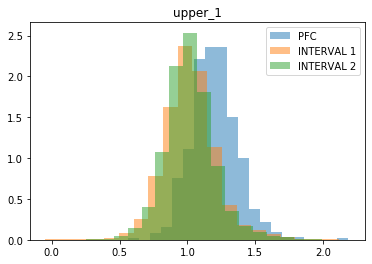

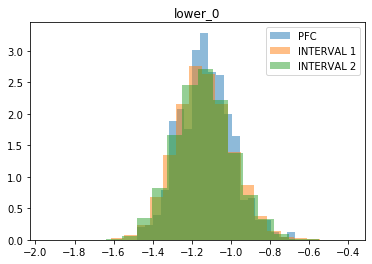

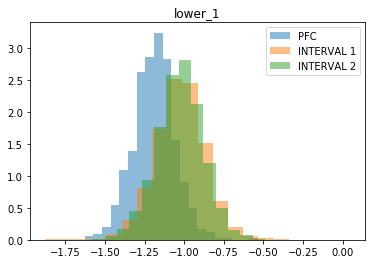

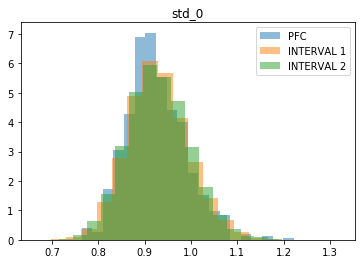

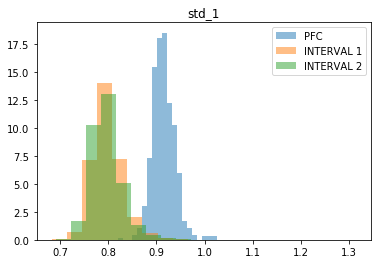

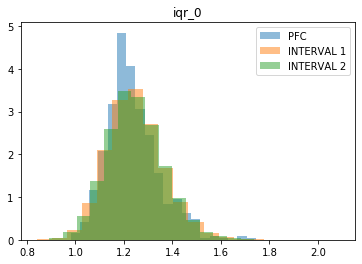

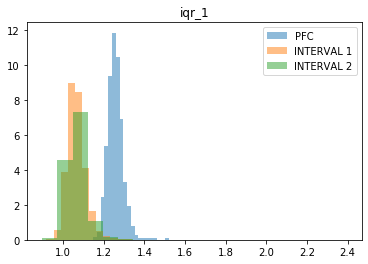

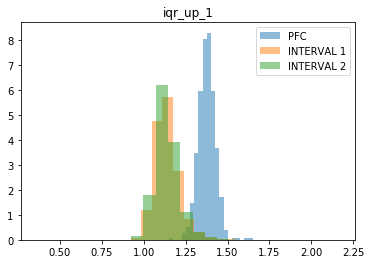

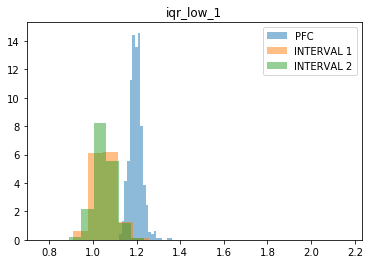

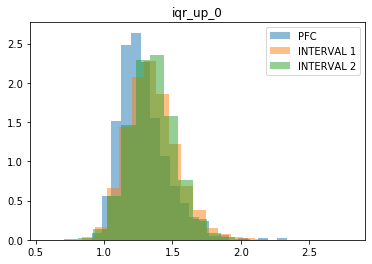

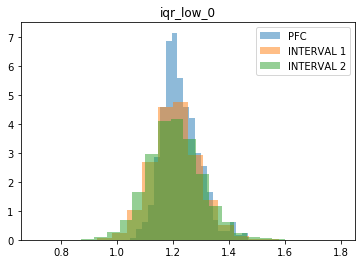

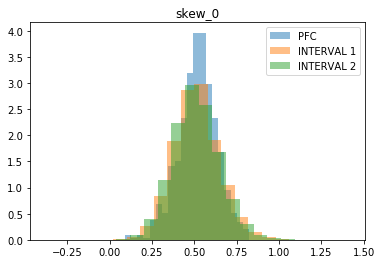

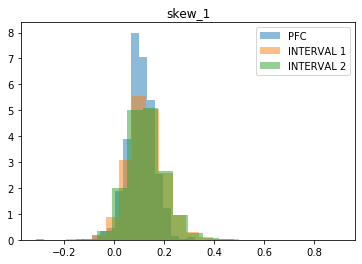

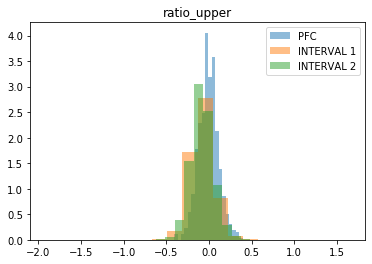

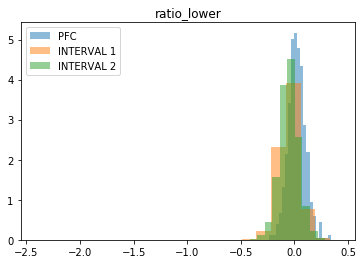

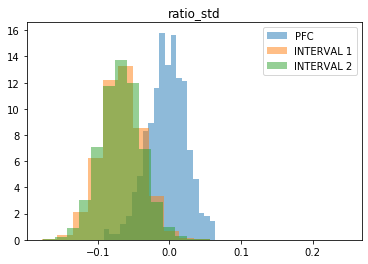

In [229]:
for f in features.columns:
    plt.figure()
    plt.hist(features.loc[features.index.isin(pfc_IDs),f],density=True,bins=20,alpha=.5  ,label="PFC")
    plt.hist(features.loc[features.index.isin(int_1_IDs),f],density=True,bins=20,alpha=.5,label="INTERVAL 1")
    plt.hist(features.loc[features.index.isin(int_2_IDs),f],density=True,bins=20,alpha=.5,label="INTERVAL 2")
    plt.title(f)
    plt.legend()

In [386]:
example = int_sct.loc[int_sct.ID == "INT_116_4699500"]

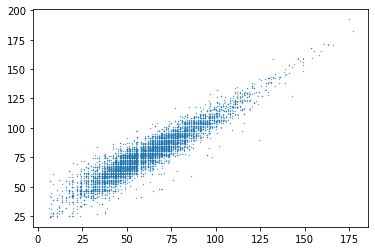

In [388]:
plt.scatter(example.FSC,example.SFL,s=.1)

## Correct Sysmex discrepancies

In [389]:
# Approach : fit/transform gaussian quantile-norm on features, on PFC and INT seperately

In [230]:
features.loc[features.index.isin(pfc_IDs)] = \
    quantile_transform(features.loc[features.index.isin(pfc_IDs)],
                    n_quantiles=50,output_distribution="normal")
features.loc[features.index.isin(int_1_IDs)] = \
    quantile_transform(features.loc[features.index.isin(int_1_IDs)],
                    n_quantiles=250,output_distribution="normal")
features.loc[features.index.isin(int_2_IDs)] = \
    quantile_transform(features.loc[features.index.isin(int_2_IDs)],
                    n_quantiles=250,output_distribution="normal")

In [231]:
features = features.clip(-3,3)

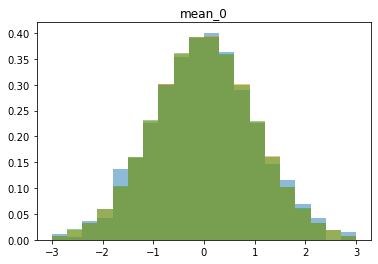

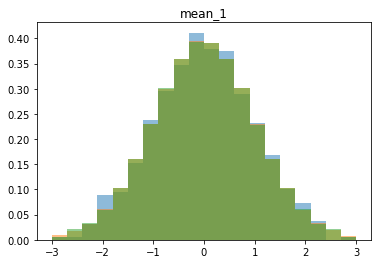

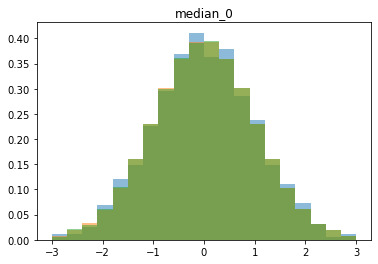

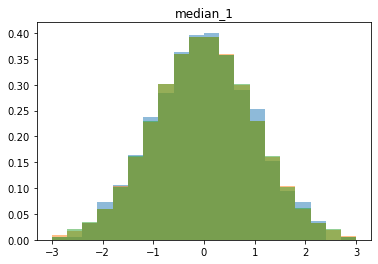

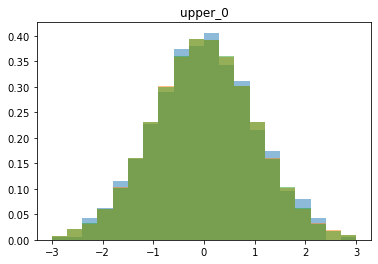

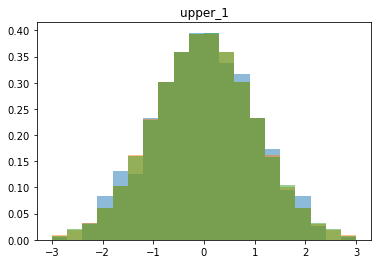

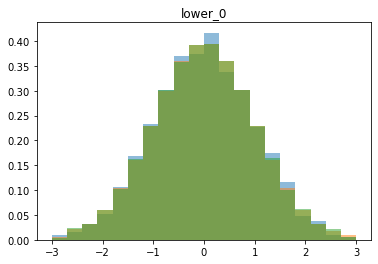

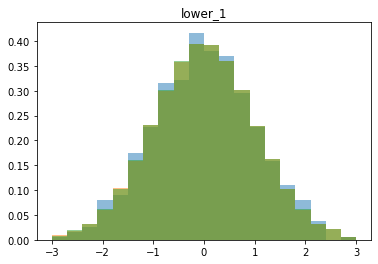

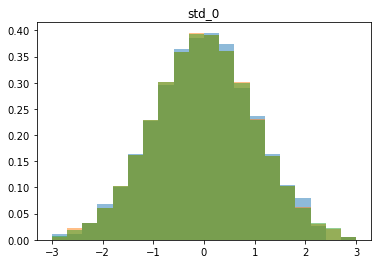

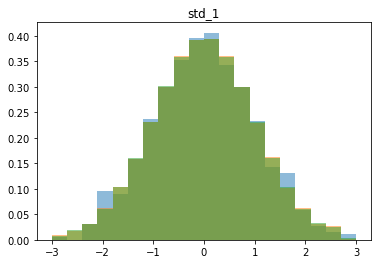

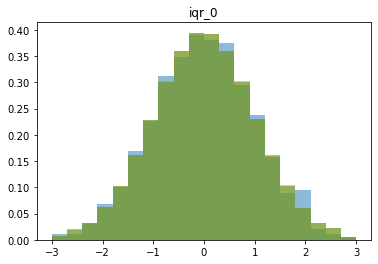

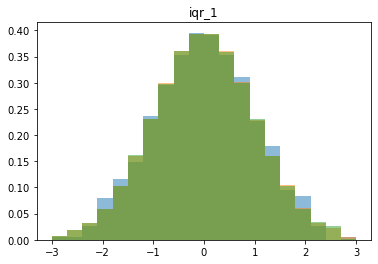

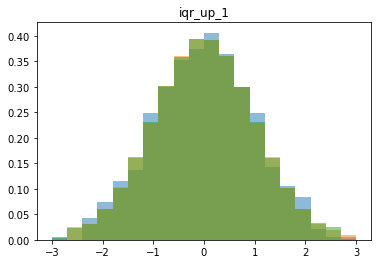

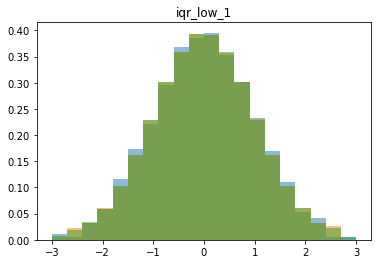

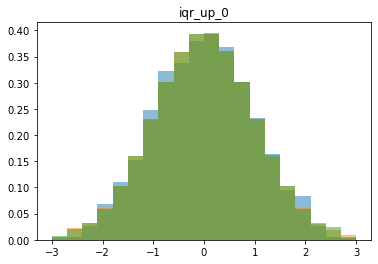

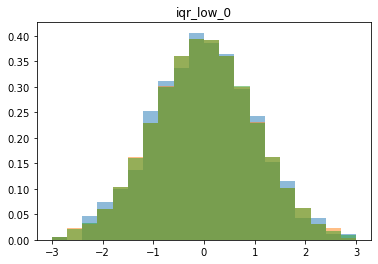

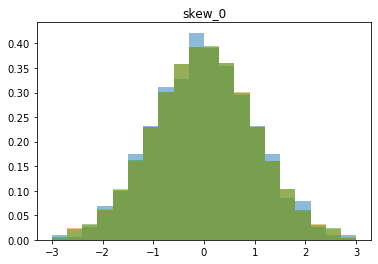

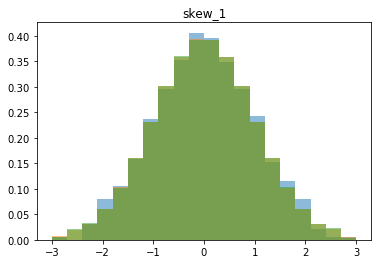

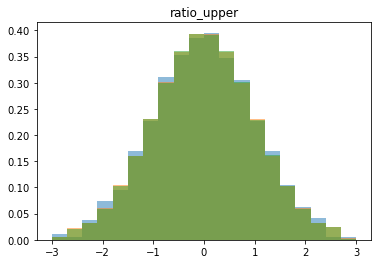

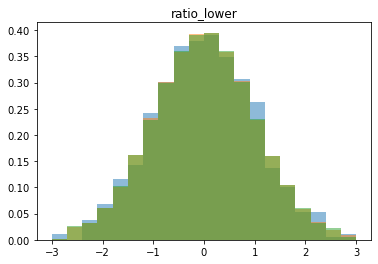

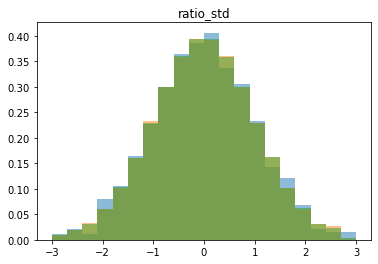

In [22]:
for f in features.columns:
    plt.figure()
    plt.hist(features.loc[ features.index.isin(pfc_IDs),f],density=True,bins=20,alpha=.5)
    plt.hist(features.loc[ features.index.isin(int_1_IDs),f],density=True,bins=20,alpha=.5)
    plt.hist(features.loc[ features.index.isin(int_2_IDs),f],density=True,bins=20,alpha=.5)
    plt.title(f)

In [233]:
features.to_hdf("%s/features_adjusted.hdf" % training_data,key="features")

## Observe features space

In [48]:
features = pd.read_hdf("%s/features_adjusted.hdf" % training_data,key="features")
int_phen = pd.read_hdf("%s/int_phen_adjusted.hdf" % training_data,key="INT_PHEN")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)
pfc_IDs = sys_sct.ID.unique().tolist()
int_1_IDs = int_phen.loc[int_phen.Instrument == "XN-10^11041"].SampleNo.unique().tolist()
int_2_IDs = int_phen.loc[int_phen.Instrument != "XN-10^11041"].SampleNo.unique().tolist()

In [49]:
features.loc[features.index.isin(pfc_IDs)].sort_values("mean_0")

mean_0    mean_1  median_0  median_1   upper_0   upper_1   lower_0  \
ID                                                                             
C1A21T -3.000000  0.981208 -3.000000  1.028819 -3.000000  0.389442 -2.081818   
C19783 -3.000000  0.773733 -3.000000  0.826620 -2.390352  0.451315 -3.000000   
C19DPJ -2.436408  1.063517 -2.422815  1.055914 -2.378470  0.783905 -2.129438   
C1956F -2.286614  0.189295 -2.457630  0.190767 -1.800132  0.153201 -2.752575   
C0X2DM -2.266391 -0.047593 -2.385167  0.005277 -2.135772 -0.387801 -2.136249   
...          ...       ...       ...       ...       ...       ...       ...   
C194W4  2.370302  0.088438  2.321878  0.025695  2.184263  0.452963  2.594265   
C19JWI  2.389007 -0.128259  2.343074 -0.214736  2.260187  0.439661  2.284341   
C19MBB  2.766217 -2.210659  2.745776 -2.256420  2.395425 -2.097067  2.605026   
C19F1M  2.965878 -1.111093  3.000000 -1.183382  2.335936 -0.486618  3.000000   
C19RQZ  3.000000 -1.830483  2.699968 -1.816114  3.000000 -1.279223  2.350294   

         lower_1     std_0     std_1  ...     iqr_1  iqr_up_1  iqr_low_1  \
ID                                    ...                                  
C1A21T  1.546016 -2.870681 -2.086478  ... -2.184167  0.464652  -1.693337   
C19783  0.910632 -2.046657 -0.843240  ... -1.234104  0.253871  -0.814800   
C19DPJ  1.333790 -2.104345 -0.729837  ... -1.070116  0.671939   0.539675   
C1956F  0.143472 -0.528055  0.249625  ...  0.290135  1.108232   1.538739   
C0X2DM  0.138260 -1.379654 -1.194218  ... -1.575074  0.064687  -0.645876   
...          ...       ...       ...  ...       ...       ...        ...   
C194W4 -0.224496  1.561556  1.472189  ...  1.552966  0.362352   1.284967   
C19JWI -0.804395  2.075707  2.066985  ...  2.080551  1.456069  -0.022315   
C19MBB -2.376416  2.090860  0.426380  ...  0.608722 -0.862268  -1.163376   
C19F1M -1.681393  1.887839  1.744101  ...  2.051280  0.506929   1.439798   
C19RQZ -2.102178  2.382534  1.012566  ...  1.474772  0.147794   0.031146   

        iqr_up_0  iqr_low_0    skew_0    skew_1  ratio_upper  ratio_lower  \
ID                                                                          
C1A21T -2.349494  -2.239562  2.404132 -1.438158     3.000000    -2.113390   
C19783 -2.059029  -0.945027  1.406848 -1.765560     2.306596    -2.037127   
C19DPJ -1.745053  -1.803887  2.094499 -0.904545     2.398831    -2.059179   
C1956F -1.074262   0.444485  2.256011 -0.326687     1.643609    -1.529493   
C0X2DM -2.104182  -0.288724  3.000000 -0.522667     1.754728    -1.353900   
...          ...        ...       ...       ...          ...          ...   
C194W4  1.792724   0.377854 -2.090402  0.339006    -1.702120     2.172840   
C19JWI  2.048776   1.388089 -2.256549  0.973655    -1.822603     2.152565   
C19MBB  2.138078   1.742611 -2.505963  3.000000    -3.000000     3.000000   
C19F1M  1.857572   0.509260 -3.000000  1.425371    -2.165670     2.806242   
C19RQZ  2.472643   3.000000 -2.200649  2.113640    -2.829103     2.503273   

        ratio_std  
ID                 
C1A21T   2.134819  
C19783   1.787804  
C19DPJ   1.905843  
C1956F   0.649661  
C0X2DM   1.051657  
...           ...  
C194W4  -1.208899  
C19JWI  -1.585952  
C19MBB  -2.159216  
C19F1M  -1.544425  
C19RQZ  -3.000000  

[632 rows x 21 columns]

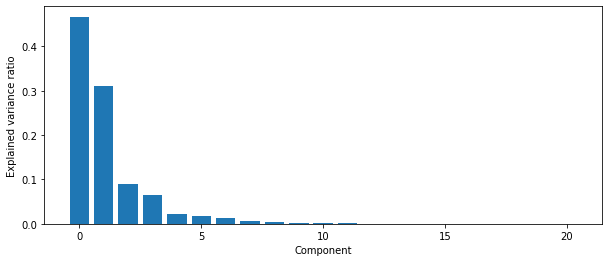

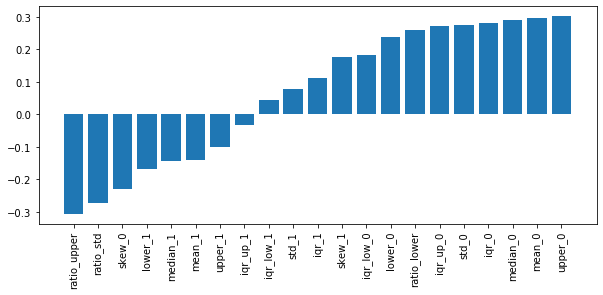

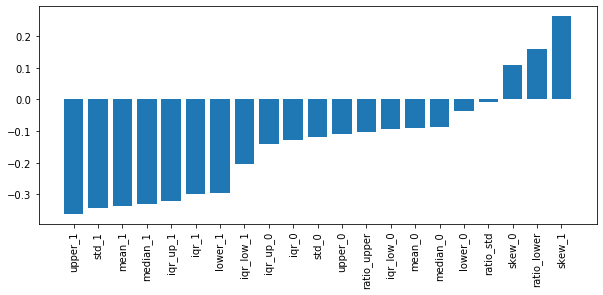

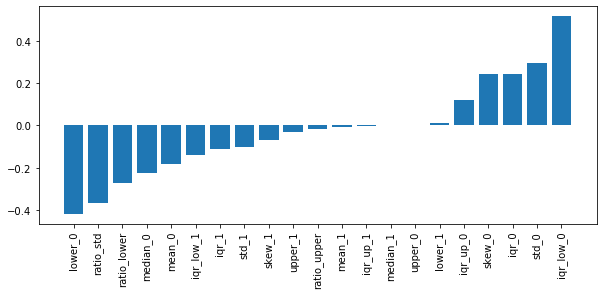

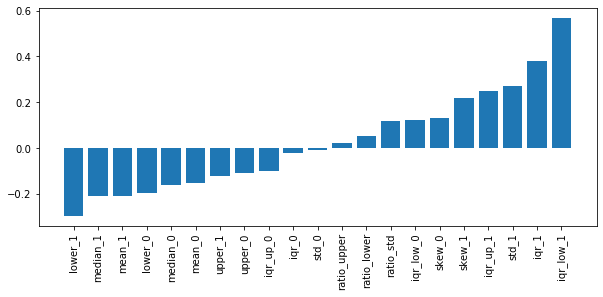

In [245]:
pca = PCA(whiten=True).fit(features.loc[features.index.isin(pfc_IDs)].values)
fig = plt.figure(figsize=(10,4))
e_var = pca.explained_variance_ratio_
plt.bar(np.arange(len(e_var)),e_var)
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
n_significant_comps = np.max(np.where(e_var > 0.05)[0])
for k in range(n_significant_comps +1):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    order = np.argsort(pca.components_[k])
    ax.bar(np.arange(len(e_var)),pca.components_[k,order])
    plt.xticks(np.arange(len(e_var)),features.columns[order],rotation='vertical')

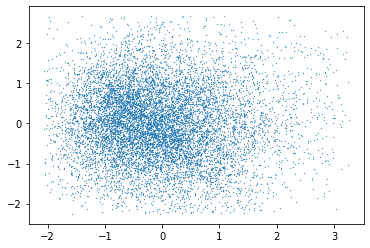

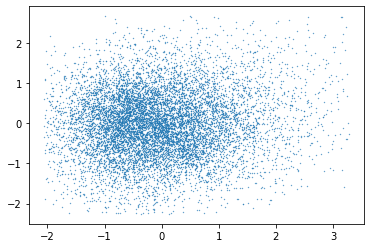

In [246]:
sub_X = sct.loc[sct.ID.isin(pfc_IDs)].sample(int(1e4))
plt.figure()
plt.scatter(sub_X["X_0"],sub_X["X_1"],s=.1)
sub_X = sct.loc[~sct.ID.isin(pfc_IDs)].sample(int(1e4))
plt.figure()
plt.scatter(sub_X["X_0"],sub_X["X_1"],s=.1)

In [247]:
## Finir, lancer le GWAS avec ces features joliment compensées

In [248]:
features.head()

mean_0    mean_1  median_0  median_1   upper_0   upper_1   lower_0  \
ID                                                                             
C0WX4Z  0.004411 -0.310435 -0.054826 -0.355976 -0.129397 -0.155336  0.366988   
C0WX6V -0.063074  0.020559 -0.076198 -0.057653  0.117375 -0.060029 -0.454306   
C0WX7T  0.555353  0.960674  0.602985  0.949015  0.309003  0.905671  0.863230   
C0WX8R  0.437164 -1.404702  0.328134 -1.365766  0.557532 -1.750473  0.301564   
C0WXBL -0.270185 -0.560260 -0.230688 -0.519749 -0.312848 -0.832249 -0.217004   

         lower_1     std_0     std_1  ...     iqr_1  iqr_up_1  iqr_low_1  \
ID                                    ...                                  
C0WX4Z -0.396311 -0.405051  0.531784  ...  0.119188  0.504104   0.348112   
C0WX6V  0.232390  0.570996 -0.393478  ... -0.849495 -0.438687  -0.680426   
C0WX7T  0.935206 -0.186668  0.451158  ...  0.502264  0.150333  -0.489605   
C0WX8R -1.101881  0.725220 -2.058111  ... -2.141145 -2.067668  -1.540957   
C0WXBL -0.251563 -0.211506 -1.444045  ... -2.053197 -1.139458  -1.694682   

        iqr_up_0  iqr_low_0    skew_0    skew_1  ratio_upper  ratio_lower  \
ID                                                                          
C0WX4Z  0.057196  -0.971631  0.519450  1.254911     0.039888     0.488375   
C0WX6V  0.822318   0.361308  0.432196  1.297859    -0.124378    -0.425349   
C0WX7T  0.008685  -0.878570 -0.459557 -1.081680     0.158095     0.051636   
C0WX8R  0.621372   0.791579  0.323077  1.552923    -1.424016     0.835012   
C0WXBL  0.018057  -0.069890  0.609074  0.571250    -0.120280     0.041873   

        ratio_std  
ID                 
C0WX4Z   0.662900  
C0WX6V  -0.794420  
C0WX7T   0.412741  
C0WX8R  -1.544764  
C0WXBL  -0.272513  

[5 rows x 21 columns]

In [249]:
sys_phen.head()

SAMPLE_ID   Age  Sex     Nickname  Analyzer ID        Date      Time Rack  \
0    C0WX8R  71.0  2.0  XN-1000-1-A  XN-20^12829  12/01/2016  13:28:07    6   
1    C0WX7T  70.0  2.0  XN-1000-1-A  XN-20^12829  12/01/2016  12:03:07    5   
2    C0WXBL  58.0  2.0  XN-1000-1-A  XN-20^12829  12/01/2016  14:16:57    7   
3    C0WX4Z  63.0  2.0  XN-1000-1-A  XN-20^12829  12/01/2016  10:44:17    3   
4    C0WX14  67.0  2.0  XN-1000-1-A  XN-20^12829  12/01/2016  10:05:38    2   

       ID Sample Inf.  ... IG#/M IG%/M NEUT#&/M NEUT%&/M NE-SSC/M NE-SFL/M  \
0  C0WX8R           B  ...   NaN   NaN      NaN      NaN      NaN      NaN   
1  C0WX7T           B  ...   NaN   NaN      NaN      NaN      NaN      NaN   
2  C0WXBL           B  ...   NaN   NaN      NaN      NaN      NaN      NaN   
3  C0WX4Z           B  ...   NaN   NaN      NaN      NaN      NaN      NaN   
4  C0WX14           B  ...   NaN   NaN      NaN      NaN      NaN      NaN   

  NE-FSC/M IP SUS(RBC)Iron Deficiency? HCT/M RDW-CV/M  
0      NaN                         NaN   NaN      NaN  
1      NaN                         NaN   NaN      NaN  
2      NaN                         NaN   NaN      NaN  
3      NaN                         NaN   NaN      NaN  
4      NaN                         NaN   NaN      NaN  

[5 rows x 301 columns]

## Prepare covariates

In [250]:
int_IDs = int_sct.ID.unique().tolist()
int_1_IDs = int_phen.loc[int_phen.Instrument == "XN-10^11041"].SampleNo.unique().tolist()
int_2_IDs = int_phen.loc[int_phen.Instrument != "XN-10^11041"].SampleNo.unique().tolist()

In [257]:
add_agesex = pd.merge(df[["SAMPLE_ID","AGE","is_MAN"]],sys_phen,left_on="SAMPLE_ID",right_on="ID")

In [258]:
add_agesex

SAMPLE_ID_x   AGE  is_MAN SAMPLE_ID_y   Age  Sex     Nickname  \
0        C0WX8R  71.0     0.0      C0WX8R  71.0  2.0  XN-1000-1-A   
1        C0WX7T  70.0     0.0      C0WX7T  70.0  2.0  XN-1000-1-A   
2        C0WXBL  58.0     0.0      C0WXBL  58.0  2.0  XN-1000-1-A   
3        C0WX4Z  63.0     0.0      C0WX4Z  63.0  2.0  XN-1000-1-A   
4        C0WX14  67.0     0.0      C0WX14  67.0  2.0  XN-1000-1-A   
..          ...   ...     ...         ...   ...  ...          ...   
531      C1A2PI  69.0     1.0      C1A2PI  69.0  1.0  XN-1000-1-A   
532      C1A2RE  60.0     1.0      C1A2RE  60.0  1.0  XN-1000-1-A   
533      C1A2TA  42.0     0.0      C1A2TA  42.0  2.0  XN-1000-1-A   
534      C1A2X2  71.0     1.0      C1A2X2  71.0  1.0  XN-1000-1-A   
535      C1A32N  44.0     0.0      C1A32N  44.0  2.0  XN-1000-1-A   

     Analyzer ID        Date      Time  ... IG#/M IG%/M NEUT#&/M NEUT%&/M  \
0    XN-20^12829  12/01/2016  13:28:07  ...   NaN   NaN      NaN      NaN   
1    XN-20^12829  12/01/2016  12:03:07  ...   NaN   NaN      NaN      NaN   
2    XN-20^12829  12/01/2016  14:16:57  ...   NaN   NaN      NaN      NaN   
3    XN-20^12829  12/01/2016  10:44:17  ...   NaN   NaN      NaN      NaN   
4    XN-20^12829  12/01/2016  10:05:38  ...   NaN   NaN      NaN      NaN   
..           ...         ...       ...  ...   ...   ...      ...      ...   
531  XN-20^12829  28/11/2018  11:49:20  ...   NaN   NaN      NaN      NaN   
532  XN-20^12829  29/11/2018  10:11:21  ...   NaN   NaN      NaN      NaN   
533  XN-20^12829  29/11/2018  13:25:31  ...   NaN   NaN      NaN      NaN   
534  XN-20^12829  30/11/2018  09:09:50  ...   NaN   NaN      NaN      NaN   
535  XN-20^12829  05/12/2018  12:44:59  ...   NaN   NaN      NaN      NaN   

    NE-SSC/M NE-SFL/M NE-FSC/M IP SUS(RBC)Iron Deficiency? HCT/M RDW-CV/M  
0        NaN      NaN      NaN                         NaN   NaN      NaN  
1        NaN      NaN      NaN                         NaN   NaN      NaN  
2        NaN      NaN      NaN                         NaN   NaN      NaN  
3        NaN      NaN      NaN                         NaN   NaN      NaN  
4        NaN      NaN      NaN                         NaN   NaN      NaN  
..       ...      ...      ...                         ...   ...      ...  
531      NaN      NaN      NaN                         NaN   NaN      NaN  
532      NaN      NaN      NaN                         NaN   NaN      NaN  
533      NaN      NaN      NaN                         NaN   NaN      NaN  
534      NaN      NaN      NaN                         NaN   NaN      NaN  
535      NaN      NaN      NaN                         NaN   NaN      NaN  

[536 rows x 304 columns]

In [259]:
#add_agesex = add_agesex.rename(columns={"AGE":"Age","is_MAN":"Sex"})
#add_agesex.loc[add_agesex["Sex"] == 1,"Sex"] = 1
#add_agesex.loc[add_agesex.Sex == 0,"Sex"] = 2

KeyError: "None of [Index([('S', 'e', 'x'), ('S', 'e', 'x')], dtype='object')] are in the [index]"

suppose that 1 = man,2 = female

In [58]:
#sys_phen = add_agesex

In [262]:
covar = pd.concat((int_phen.set_index("SampleNo")[covar_cols],
           sys_phen.set_index("ID")[covar_cols]),
          axis=0)
#covar = covar.loc[covar.index.isin(valid_IDs_PLT)]

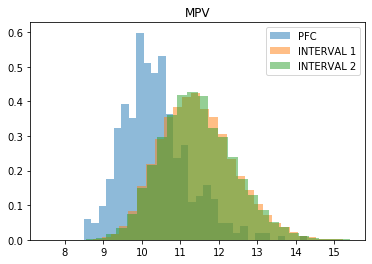

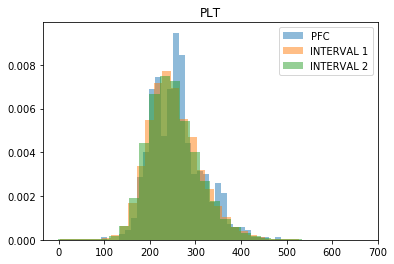

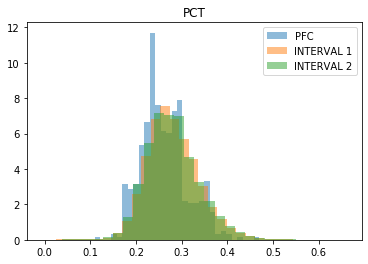

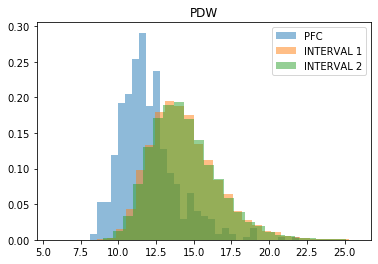

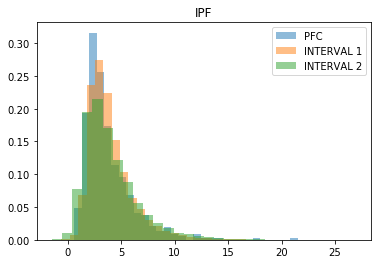

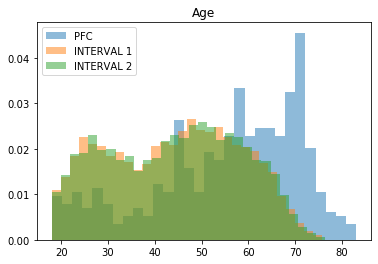

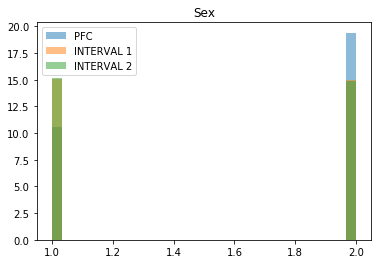

In [263]:
for c in covar.columns:
    plt.figure()
    plt.hist(covar.loc[covar.index.isin(pfc_IDs),c],density=True,alpha=.5,bins=30,label="PFC")
    plt.hist(covar.loc[covar.index.isin(int_1_IDs),c],density=True,alpha=.5,bins=30,label="INTERVAL 1")
    plt.hist(covar.loc[covar.index.isin(int_2_IDs),c],density=True,alpha=.5,bins=30,label="INTERVAL 2")
    plt.title(c)
    plt.legend();

In [264]:
# There are discrpancies, let's correct them the same way
covars_to_correct = ["MPV","PCT","PDW","PLT"]
covar.loc[covar.index.isin(pfc_IDs),covars_to_correct] = \
    quantile_transform(covar.loc[covar.index.isin(pfc_IDs),covars_to_correct],
                    n_quantiles=50,output_distribution="normal")
covar.loc[covar.index.isin(int_1_IDs),covars_to_correct] = \
    quantile_transform(covar.loc[covar.index.isin(int_1_IDs),covars_to_correct],
                    n_quantiles=2500,output_distribution="normal")
covar.loc[covar.index.isin(int_2_IDs),covars_to_correct] = \
    quantile_transform(covar.loc[covar.index.isin(int_2_IDs),covars_to_correct],
                    n_quantiles=2500,output_distribution="normal")
covar[covars_to_correct] = covar[covars_to_correct].clip(-3,3)

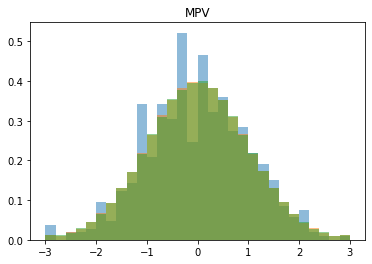

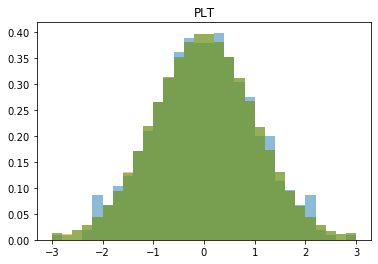

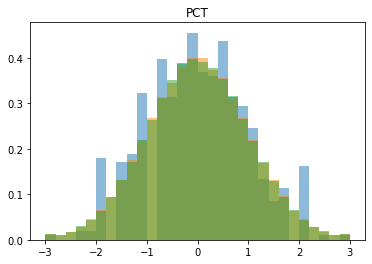

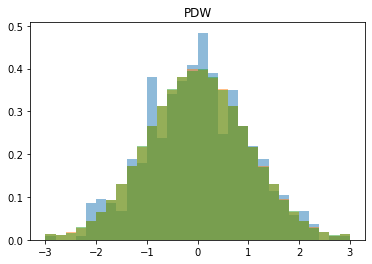

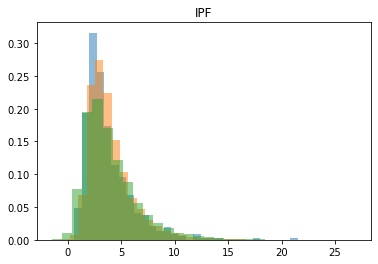

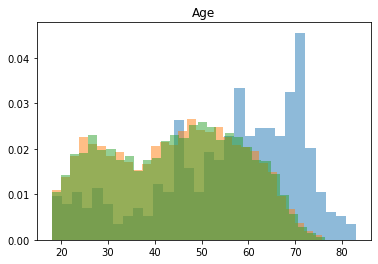

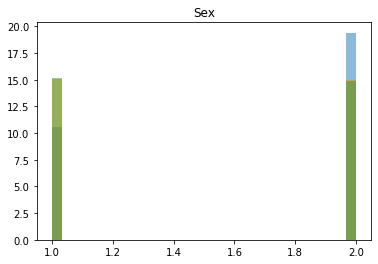

In [265]:
for c in covar.columns:
    plt.figure()
    plt.hist(covar.loc[covar.index.isin(pfc_IDs),c],density=True,alpha=.5,bins=30)
    plt.hist(covar.loc[covar.index.isin(int_1_IDs),c],density=True,alpha=.5,bins=30)
    plt.hist(covar.loc[covar.index.isin(int_2_IDs),c],density=True,alpha=.5,bins=30)
    plt.title(c)

In [266]:
features.to_hdf("%s/features_adjusted.hdf" % training_data,key="features")
covar.to_hdf("%s/covar.hdf" % training_data,key="covar")

# Training

In [22]:
features = pd.read_hdf("%s/features_adjusted.hdf" % training_data, key="features")
covar = pd.read_hdf("%s/covar.hdf" % training_data, key="covar")
pheno_df = pd.read_hdf("%s/pheno_df.hdf" % training_data, key="pheno_df")
int_phen = pd.read_hdf("%s/int_phen_adjusted.hdf" % training_data,key="INT_PHEN")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)
pfc_IDs = sys_sct.ID.unique().tolist()
int_1_IDs = int_phen.loc[int_phen.Instrument == "XN-10^11041"].SampleNo.unique().tolist()
int_2_IDs = int_phen.loc[int_phen.Instrument != "XN-10^11041"].SampleNo.unique().tolist()

In [23]:
covar.head()

MPV       PLT       PCT       PDW       IPF   Age  Sex
INT_116_6580100 -0.313499 -0.644134 -1.059624 -0.037623  2.417379  58.8  1.0
INT_116_6580000  0.104507 -0.170845 -0.022571  0.462870  3.517379  22.6  2.0
INT_116_2129800 -1.381039 -1.005563 -1.504499 -0.952317  2.217379  32.5  1.0
INT_116_4555900  0.614302 -2.209234 -2.439133 -0.440314  3.117379  59.4  2.0
INT_116_4555800  0.994195 -0.980412 -0.414823  1.008165  4.217379  21.3  2.0

In [24]:
X_train = pd.merge(covar,pheno_df,left_index=True,right_index=True,how="inner")
X_train = pd.merge(X_train,features,left_index=True,right_index=True,how="inner")

In [25]:
X_train.shape

(527, 46)

In [26]:
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

## Estimate performance

In [27]:
N_PLS_COMPS = 1

In [28]:
for f in features.columns:
    corr = False
    for c in covar_cols:
        r, p = pearsonr(X_train[f],X_train[c])
        if p < 1e-2:
            print(f,c,r,p)
            corr = True
    if not corr:
        print(f)

mean_0 MPV 0.9332159236837828 1.57321223975014e-235
mean_0 PLT -0.45534048766925206 2.461892800950108e-28
mean_0 PDW 0.9121796420609464 1.5011669570547495e-205
mean_0 IPF 0.8028924414792487 4.877878355103801e-120
mean_0 Age -0.16599400717244306 0.00012909456370991282
mean_1 MPV -0.2460502016969091 1.04504072610226e-08
mean_1 PDW -0.23767866905405852 3.339378822571432e-08
mean_1 IPF -0.22478459487043792 1.8392299783721513e-07
median_0 MPV 0.9192367363898402 1.1039702010978254e-214
median_0 PLT -0.43972706322271654 2.5035069228709266e-26
median_0 PDW 0.901398420000955 5.467139003018042e-193
median_0 IPF 0.7610222121647764 9.812546774880834e-101
median_0 Age -0.19026827280161082 1.0937623893187245e-05
median_1 MPV -0.2609702525973846 1.1836171399413506e-09
median_1 PLT 0.1174673963807895 0.006942566875482668
median_1 PDW -0.2522044026438105 4.327875402220219e-09
median_1 IPF -0.23632078976211623 4.0155975873493013e-08
upper_0 MPV 0.9396392444320459 1.1051878917815122e-246
upper_0 PLT -0.5

In [29]:
lm = LinearRegression().fit(X_train[covar_cols],X_train[features.columns])
X_train[features.columns] -= lm.predict(X_train[covar_cols])
#X_train[features.columns] -= X_train[features.columns].mean(axis=0)
#X_train[features.columns] /= X_train[features.columns].std(axis=0)

In [30]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
y_pred_test = {}
y_test = {}
r2_cov = defaultdict(lambda: [])
r2_all = defaultdict(lambda: [])
r2_res = defaultdict(lambda: [])
for c in pheno_cols:
    skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=100)
    y = X_train[c]
    cond = ~y.isnull()
    X = X_train.loc[cond,features.columns]
    C = X_train.loc[cond,covar_cols]
    y = y.loc[cond]
    
    y_split = pd.cut(y,3,labels=False)
    
    for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
        #print(len(train_index),len(test_index))
        pls = LinearRegression()
        pls.fit(C.iloc[train_index],y.iloc[train_index])
        y_cov = np.reshape(pls.predict(C),(-1,1))
        
        residuals = y-y_cov[:,0]
        pls_res = PLSRegression(n_components=N_PLS_COMPS)
        pls_res.fit(X.iloc[train_index],residuals.iloc[train_index])
        y_res = pls_res.predict(X)
        y_pred = y_cov + y_res
        
        pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]
        pearson_cov = pearsonr(y.iloc[test_index],y_cov[test_index,0])[0]
        
        rho_cov[c].append(pearson_cov)
        rho_all[c].append(pearson_all)
        r2_all[c].append(r2_score(y.iloc[test_index],y_pred[test_index,0]))
        r2_cov[c].append(r2_score(y.iloc[test_index],y_cov[test_index,0]))
        r2_res[c].append(r2_score(residuals.iloc[test_index],y_res[test_index,0]))
        
        if i == 0:
            
            y_pred_test[c] = y_pred[test_index,0]
            y_test[c] = y.iloc[test_index]
        

In [ ]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(10,6))
for i, c in enumerate(pheno_cols):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(y_test[c],y_pred_test[c],s=15)
    ax.set_ylim((-1.5,1.5))
    ax.set_xlim((-3,3))
    ax.plot([-1.5,1.5],[-1.5,1.5],c="red",ls=":")
    #R2 = r2_score(y_test[c],y_pred_test[c])
    R2 = np.median(r2_all[c])
    R2_res = np.median(r2_res[c])
    R2_cov = np.median(r2_cov[c])
    ax.set_title("%s\ntotal $R^2=%.2f$ \n covariates $R^2 = %.2f $ \n residuals $ R^2=%.2f $" % (c,R2,R2_cov,R2_res))
plt.tight_layout()
plt.savefig("%s/predictions_test.pdf" % export_folder)

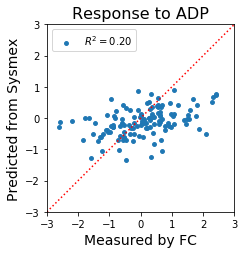

In [109]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(3.5,4))
c = "ADP_FIB"
ax = fig.add_subplot(111)
ax.scatter(y_test[c],y_pred_test[c],s=15,label="$R^2=%.2f$" % (R2))
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.plot([-3,3],[-3,3],c="red",ls=":")
ax.set_xlabel("Measured by FC",fontsize=14)
ax.set_ylabel("Predicted from Sysmex",fontsize=14)
ax.set_aspect("equal")
#R2 = r2_score(y_test[c],y_pred_test[c])
R2 = np.mean(r2_all[c])
ax.legend()
ax.set_title("Response to ADP",fontsize=16)
plt.tight_layout()
plt.savefig("%s/predictions_test.pdf" % export_folder)

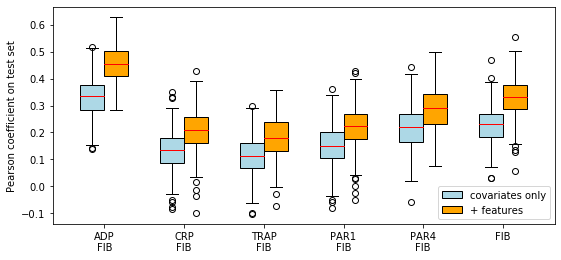

In [51]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
bp1 = ax.boxplot([rho_cov[c] for c in rho_cov],
           positions=np.arange(len(rho_cov))-.15,
           widths=0.3,
           patch_artist=True,
           medianprops={"color":"red"},
           boxprops={"facecolor":"lightblue"})
bp2 = ax.boxplot([rho_all[c] for c in rho_cov],
           positions=np.arange(len(rho_cov))+.15,
           widths=0.3,
           patch_artist=True,
           medianprops={"color":"red"},
           boxprops={"facecolor":"orange"});
ax.set_xticks(np.arange(len(rho_cov)))
ax.set_xticklabels(["\n".join(c.split("_")) for c in rho_cov]);
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["covariates only", "+ features"])
ax.set_ylabel("Pearson coefficient on test set");

## Fit

In [52]:
pls = {}
pls_res = {}

predictions = pd.DataFrame(index=X_train.index)

for c in pheno_cols:
    y = X_train[c]
    cond = ~y.isnull()
    X = X_train.loc[cond,features.columns]
    C = X_train.loc[cond,covar_cols]
    y = y.loc[cond]
    
    pls[c] = LinearRegression()
    pls[c].fit(C,y)
    y_cov = np.reshape(pls[c].predict(C),(-1,1))

    residuals = y-y_cov[:,0]
    pls_res[c] = PLSRegression(n_components=N_PLS_COMPS)
    pls_res[c].fit(X,residuals)
    y_pred = y_cov + pls_res[c].predict(X)
    
    predictions[c] = np.nan
    predictions.loc[cond,c] = y_pred[:,0]

## Predict on INTERVAL

In [53]:
X_interval = pd.merge(covar,features,left_index=True,right_index=True,how="inner")

In [54]:
for f in features.columns:
    corr = False
    for c in covar_cols:
        r, p = pearsonr(X_interval[f],X_interval[c])
        if p < 1e-2:
            print(f,c,r,p)
            corr = True
    if not corr:
        print(f)

mean_0 MPV 0.7455865155088008 0.0
mean_0 PLT -0.40764492734576124 0.0
mean_0 PCT -0.1304317873155925 2.863409920024318e-143
mean_0 PDW 0.7240784944951667 0.0
mean_0 IPF 0.8090204331281434 0.0
mean_0 Age -0.1271945247800081 2.745943733368025e-136
mean_0 Sex -0.030000944521025048 5.27635245558338e-09
mean_1 MPV -0.12432909034838611 2.936901073032532e-130
mean_1 PLT 0.18317990903606685 6.396098147818038e-283
mean_1 PCT 0.1393213110221944 2.249669736116076e-163
mean_1 PDW -0.10802546118371913 1.2440618924580877e-98
mean_1 IPF -0.07771169041878279 8.522063454038428e-52
mean_1 Age -0.14282732222862884 1.1096383224273266e-171
mean_1 Sex 0.06378645531164656 1.9664636923495834e-35
median_0 MPV 0.7180030851460629 0.0
median_0 PLT -0.38931379707421887 0.0
median_0 PCT -0.11960100650814058 1.2817475249233571e-120
median_0 PDW 0.6970834844487344 0.0
median_0 IPF 0.7746564162861114 0.0
median_0 Age -0.14474342417006342 2.597930841384232e-176
median_0 Sex -0.020363772499262047 7.422211061455897e-05
m

In [55]:
lm = LinearRegression().fit(X_interval[covar_cols],X_interval[features.columns])
X_interval[features.columns] -= lm.predict(X_interval[covar_cols])
#X_interval[features.columns] -= X_interval[features.columns].mean(axis=0)
#X_interval[features.columns] /= X_interval[features.columns].std(axis=0)

In [56]:
predictions_interval = pd.DataFrame(index=X_interval.index)

for c in pheno_cols:
    X = X_interval[features.columns]
    C = X_interval[covar_cols]
    
    y_cov = np.reshape(pls[c].predict(C),(-1,1))
    y_pred = y_cov + pls_res[c].predict(X)
    
    predictions_interval[c] = y_pred[:,0]

## Check

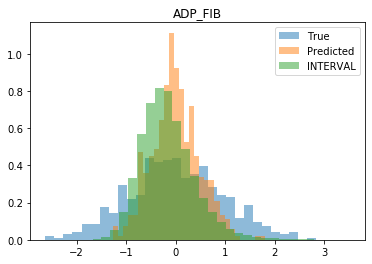

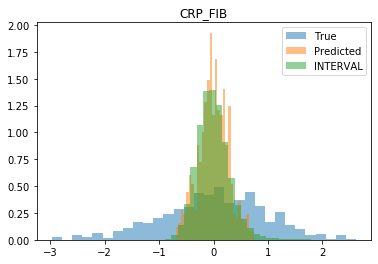

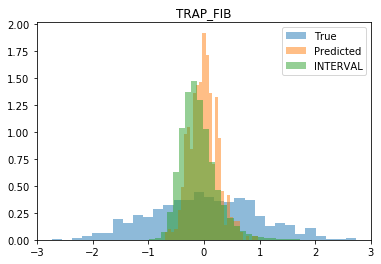

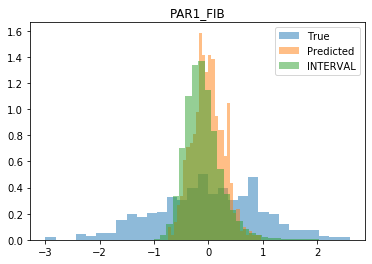

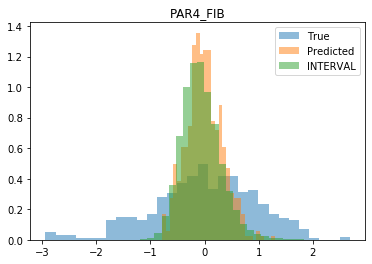

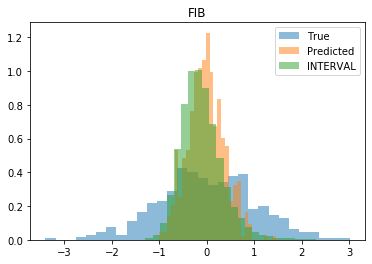

In [57]:
for c in pheno_cols:
    plt.figure()
    plt.hist(pheno_df[c],label="True",alpha=.5,bins=30,density=True)
    plt.hist(predictions[c],label="Predicted",alpha=.5,bins=30,density=True)
    plt.hist(predictions_interval[c],label="INTERVAL",alpha=.5,bins=30,density=True)
    plt.title(c)
    plt.legend();

## Look at predictors

<BarContainer object of 21 artists>

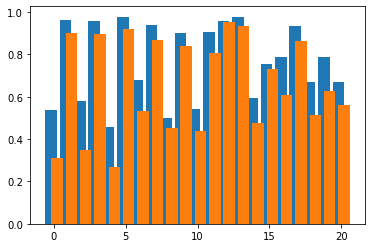

In [58]:
n_features = len(features.columns)
plt.bar(np.arange(n_features)-0.2,X_interval[features.columns].std(axis=0))
plt.bar(np.arange(n_features)+0.2,X_train[features.columns].std(axis=0))

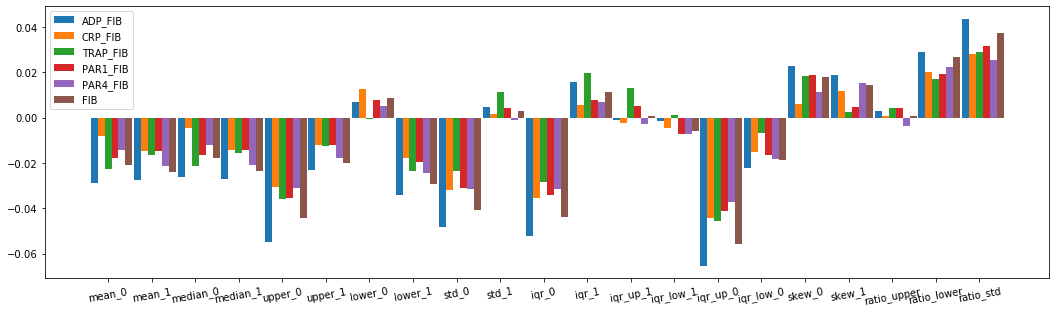

In [59]:
plt.figure(figsize=(18,5))
w = 0.16
for i,c in enumerate(pheno_cols):
    plt.bar(x=np.arange(len(features.columns))+w*(i-2),height=pls_res[c].coef_[:,0],width=w,label=c)
plt.xticks(np.arange(len(features.columns)),features.columns,rotation=10)
plt.legend();

# Prepare tables for GWAS

In [60]:
tag = "26feb"

In [61]:
from sklearn.preprocessing import RobustScaler

In [62]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")
has_one_id = ~matching["Affymetrix_QC_bl"].isnull() | ~matching["Affymetrix_QC_24m"].isnull()
matching = matching.loc[has_one_id]
matching["AffyID"] = matching["Affymetrix_QC_bl"]
matching.loc[matching.AffyID.isnull(),"AffyID"] = matching.loc[matching.AffyID.isnull(),"Affymetrix_QC_24m"]

In [63]:
matching.head()

identifier  Affymetrix_QC_bl  Affymetrix_gwasQC_bl  Affymetrix_QC_24m  \
0     1000000      1.100169e+11          1.100169e+11                NaN   
1     1000001      1.100032e+11          1.100032e+11                NaN   
2     1000003      1.100126e+11          1.100126e+11                NaN   
3     1000004      1.100185e+11          1.100185e+11                NaN   
4     1000005      1.100141e+11          1.100141e+11                NaN   

   Affymetrix_gwasQC_24m        AffyID  
0                    NaN  1.100169e+11  
1                    NaN  1.100032e+11  
2                    NaN  1.100126e+11  
3                    NaN  1.100185e+11  
4                    NaN  1.100141e+11

In [64]:
meta = pd.merge(matching,int_phen,left_on="identifier", right_on="identifier")
meta["IID"] = meta["AffyID"].astype(int).astype(str)
meta["FID"] = meta["AffyID"].astype(int).astype(str)

meta["cohort"] = meta.interval

In [65]:
meta.shape

(35758, 788)

In [66]:
meta.cohort.value_counts()

M12    6080
M10    5995
F14    5963
M08    5928
F16    5897
F12    5895
Name: cohort, dtype: int64

In [67]:
meta.in_cohort.value_counts()

BL    19843
24    15757
48      158
Name: in_cohort, dtype: int64

In [68]:
meta["cohort_covar"] = 0
for i, c in enumerate(meta["in_cohort"].unique().tolist()):
    meta.loc[meta["in_cohort"] == c,"cohort_covar"] = i
meta["age_covar"] = RobustScaler().fit_transform(meta[["Age"]])
meta["instrument_covar"] = 1*(meta.Instrument == "XN-10^11041")

pcs = pd.read_csv("%s/principal_components/PC.eigenvec" % export_folder,sep="\t")
pcs["IID"] = pcs["IID"].astype(str)

In [69]:
match = int_phen.loc[int_phen.ethnicPulse == "Eng/W/Scot/NI/Brit",["SampleNo","identifier"]]
match["valid_id"] = match["identifier"].astype(int)

In [70]:
match.shape

(32409, 3)

In [71]:
covars = pd.merge(covar,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID","cohort_covar","age_covar","instrument_covar"]],
                left_index=True,right_index=True)
covars = pd.merge(covars,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
covars = covars[["FID","IID"] + [c for c in covars.columns if c not in ["IID","FID"]]]
covars = covars.dropna(axis=0,how="any")

In [72]:
covars.head()

FID           IID       MPV       PLT       PCT       PDW  \
0  110006795043  110006795043 -0.313499 -0.644134 -1.059624 -0.037623   
1  110004131286  110004131286  0.104507 -0.170845 -0.022571  0.462870   
2  110006795026  110006795026  0.614302 -2.209234 -2.439133 -0.440314   
3  110004131285  110004131285  0.104507  0.366777  0.501177  0.207609   
4  110006494505  110006494505  0.104507  1.091081  1.412975  0.207609   

        IPF   Age  Sex  cohort_covar  ...       PC1       PC2       PC3  \
0  2.417379  58.8  1.0             0  ... -0.006143 -0.003414 -0.002550   
1  3.517379  22.6  2.0             0  ... -0.002604 -0.000270  0.007260   
2  3.117379  59.4  2.0             0  ...  0.006994  0.005321 -0.006430   
3  2.317379  49.3  1.0             0  ... -0.000951  0.008243 -0.000835   
4  3.217379  51.3  2.0             0  ... -0.001484  0.000059 -0.006912   

        PC4       PC5       PC6       PC7       PC8       PC9      PC10  
0 -0.006617  0.007619  0.000518 -0.005138 -0.001251 -0.001450 -0.000475  
1 -0.000367  0.004252  0.004225  0.002824 -0.006574  0.008446  0.005722  
2  0.002057 -0.001391 -0.005765 -0.005126 -0.006106 -0.001899 -0.011991  
3 -0.004595 -0.002367  0.006899  0.004903  0.001809 -0.000368 -0.000548  
4  0.007134  0.001031  0.000255  0.003179  0.004252  0.002089  0.009268  

[5 rows x 22 columns]

In [73]:
phenotypes = pd.merge(predictions_interval,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
phenotypes = pd.merge(phenotypes,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
phenotypes = phenotypes[["FID","IID"] + [c for c in phenotypes.columns if c not in ["IID","FID"] and "PC" not in c]]
phenotypes = phenotypes.dropna(axis=0,how="any")

In [74]:
cov_ids = covars.IID.unique().tolist()
phen_ids = phenotypes.IID.unique().tolist()
covars = covars.loc[covars.IID.isin(phen_ids)].sort_values(by="IID")
phenotypes = phenotypes.loc[phenotypes.IID.isin(cov_ids)].sort_values("IID")
print(covars.shape)
print(phenotypes.shape)

(29541, 22)
(29541, 8)


In [85]:
gwas_features = pd.merge(features,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
gwas_features = gwas_features[["FID","IID"] + [c for c in gwas_features.columns if c not in ["IID","FID"] and "PC" not in c]]
gwas_features = gwas_features.dropna(axis=0,how="any")
gwas_features = gwas_features.loc[gwas_features.IID.isin(cov_ids) & \
                                  gwas_features.IID.isin(phen_ids)].sort_values("IID")
print(gwas_features.shape)

(29541, 23)


## Export predictions & covariates

In [80]:
tag

'26feb'

In [82]:
phenotypes.to_csv("%s/%s/phenotypes.csv" % (export_folder,tag), index=False,header=True, sep="\t")
covars.to_csv("%s/%s/covars.csv" % (export_folder,tag), index=False,header=True, sep="\t")
gwas_features.to_csv("%s/%s/features.csv" % (export_folder,tag), index=False,header=True, sep="\t")

In [83]:
phenotypes.head()

FID           IID   ADP_FIB   CRP_FIB  TRAP_FIB  PAR1_FIB  \
10222  110000305926  110000305926 -0.001509 -0.028736  0.051676  0.056784   
10314  110000305952  110000305952 -0.359863 -0.026512 -0.141588 -0.231730   
3983   110000315493  110000315493  0.182021  0.274525  0.018747  0.075888   
3967   110000315494  110000315494 -0.270067 -0.208624 -0.316887 -0.184792   
3997   110000315495  110000315495  0.047151  0.088269 -0.078211 -0.183885   

       PAR4_FIB       FIB  
10222 -0.056911 -0.003194  
10314 -0.155055 -0.245332  
3983   0.198764  0.172470  
3967  -0.289160 -0.329655  
3997   0.217461  0.034289

In [84]:
covars.head()

FID           IID       MPV       PLT       PCT       PDW  \
10222  110000305926  110000305926 -0.846347  0.411443  0.082343 -1.000793   
10314  110000305952  110000305952 -0.744486  0.197848 -0.391432 -0.457295   
3983   110000315493  110000315493  0.429077 -0.496761 -0.070774  0.360214   
3967   110000315494  110000315494  0.733284  0.589501  1.021700  0.237428   
3997   110000315495  110000315495  0.925046 -0.907494 -0.540814  0.858609   

            IPF   Age  Sex  cohort_covar  ...       PC1       PC2       PC3  \
10222  2.641979  48.7  2.0             0  ...  0.001051 -0.005030  0.000366   
10314  2.677579  49.9  1.0             0  ... -0.000064 -0.000603  0.000856   
3983   2.639979  56.2  1.0             0  ...  0.001009  0.004312 -0.009543   
3967   4.397779  56.6  2.0             0  ...  0.006815  0.000915  0.006795   
3997   8.297779  37.5  1.0             0  ...  0.006833  0.003003  0.002493   

            PC4       PC5       PC6       PC7       PC8       PC9      PC10  
10222 -0.000485  0.003907 -0.001036  0.003214  0.007618 -0.000403 -0.004247  
10314  0.006369 -0.002127  0.006433  0.001969 -0.000814 -0.000623  0.001776  
3983   0.008209  0.002722  0.004606  0.004591  0.006361  0.002414  0.001101  
3967  -0.005582 -0.005617  0.001646  0.000007  0.000766  0.007461  0.002496  
3997   0.000562  0.008410  0.002672  0.010753  0.005626  0.001188  0.000879  

[5 rows x 22 columns]

In [47]:
covars.columns

Index(['FID', 'IID', 'MPV', 'PLT', 'PCT', 'PDW', 'IPF', 'Age', 'Sex',
       'cohort_covar', 'age_covar', 'instrument_covar', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
      dtype='object')

## Check machine covariates

In [86]:
from scipy.stats import ttest_ind
machine_1_IDs = covars.loc[covars.instrument_covar,"IID"].unique().tolist()
cond = phenotypes.IID.isin(machine_1_IDs)
for p in pheno_cols:
    print(p)
    print(ttest_ind(phenotypes.loc[cond,p],phenotypes.loc[~cond,p]))

ADP_FIB
Ttest_indResult(statistic=-0.37724981480214875, pvalue=0.705990673660864)
CRP_FIB
Ttest_indResult(statistic=-0.050775240613170305, pvalue=0.95950496386466)
TRAP_FIB
Ttest_indResult(statistic=-0.0760451164899941, pvalue=0.9393837193158732)
PAR1_FIB
Ttest_indResult(statistic=-0.1366167891783417, pvalue=0.891334636121528)
PAR4_FIB
Ttest_indResult(statistic=-0.08559238872821039, pvalue=0.9317910292626994)
FIB
Ttest_indResult(statistic=-0.12636410810439372, pvalue=0.8994445719874572)


# Launch GWAS

In [4]:
import subprocess
n_splits = 16
tag = "26feb"

## Phenotypes GWAS

In [87]:
for pheno in pheno_cols:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/%s/phenotypes.csv \
        --phenoCol=%s \
        --covarFile=%s/%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT \
        --qCovarCol=MPV \
        --qCovarCol=PCT \
        --qCovarCol=PDW \
        --qCovarCol=IPF \
        --qCovarCol=age_covar \
        --covarCol=Sex \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder, tag,
                            pheno,
                            export_folder, tag,
                            export_folder,
                            tag,
                            pheno,
                            export_folder, tag,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()


Submitting ADP_FIB
Submitting CRP_FIB
Submitting TRAP_FIB
Submitting PAR1_FIB
Submitting PAR4_FIB
Submitting FIB


## IPF GWAS

In [6]:
#GWAS IPF in order to build a bolygenic score
for pheno in ["IPF"]:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/%s/covars.csv \
        --phenoCol=%s \
        --covarFile=%s/%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT \
        --qCovarCol=MPV \
        --qCovarCol=PCT \
        --qCovarCol=PDW \
        --qCovarCol=IPF \
        --qCovarCol=age_covar \
        --covarCol=Sex \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder, tag,
                            pheno,
                            export_folder, tag,
                            export_folder,
                            tag,
                            pheno,
                            export_folder, tag,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()


Submitting IPF


## Features GWAS

In [9]:
#GWAS features in order to filter out associations which haven't been really 
#"selected" by the linear combination
for pheno in features.columns:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/%s/features.csv \
        --phenoCol=%s \
        --covarFile=%s/%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=age_covar \
        --covarCol=Sex \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder, tag,
                            pheno,
                            export_folder, tag,
                            export_folder,
                            tag,
                            pheno,
                            export_folder, tag,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()

Submitting mean_0
Submitting mean_1
Submitting median_0
Submitting median_1
Submitting upper_0
Submitting upper_1
Submitting lower_0
Submitting lower_1
Submitting std_0
Submitting std_1
Submitting iqr_0
Submitting iqr_1
Submitting iqr_up_1
Submitting iqr_low_1
Submitting iqr_up_0
Submitting iqr_low_0
Submitting skew_0
Submitting skew_1
Submitting ratio_upper
Submitting ratio_lower
Submitting ratio_std


# Analyze GWAS

In [89]:
tag = "19feb"

In [90]:
gws = []
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)

100%|██████████| 5/5 [00:54<00:00, 10.91s/it]


## QQ-plot

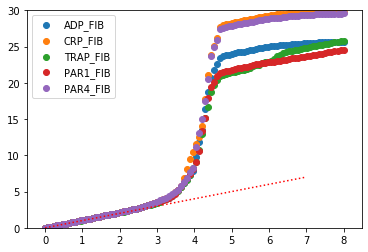

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111)
for c in pheno_cols:
    q_bins = np.logspace(-8,-0.00001,100)
    quantiles = np.array(np.quantile(gw.loc[gw.pheno == c,"P"].astype(float),q_bins),dtype=float)
    ax.scatter(-np.log10(q_bins),-np.log10(quantiles),label=c)
ax.plot([0,7],[0,7],ls=":",c="red")
ax.set_ylim((0,30))
ax.legend()

## Manhattan plot

In [92]:
gw_ = gw.loc[gw.P < 1e-3]

In [93]:
gw_["POS"] = gw_["BP"]
for ch in range(1,23):
    gw_.loc[gw_.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()

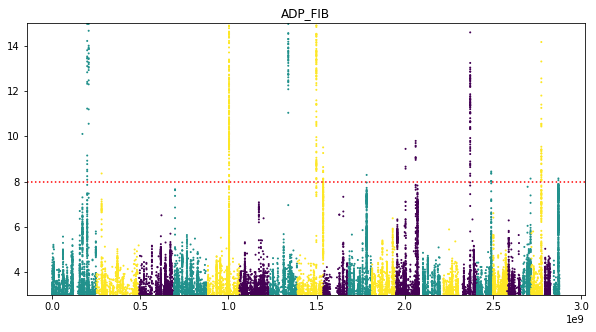

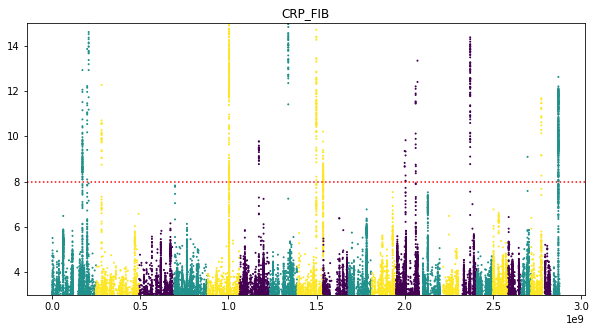

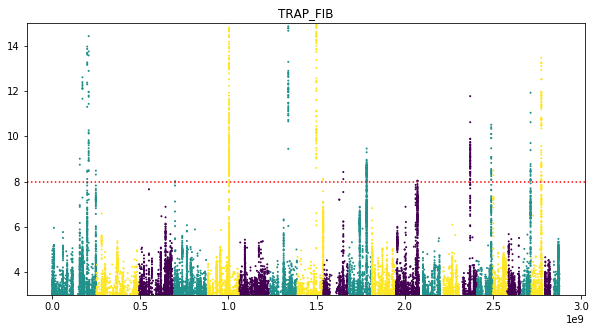

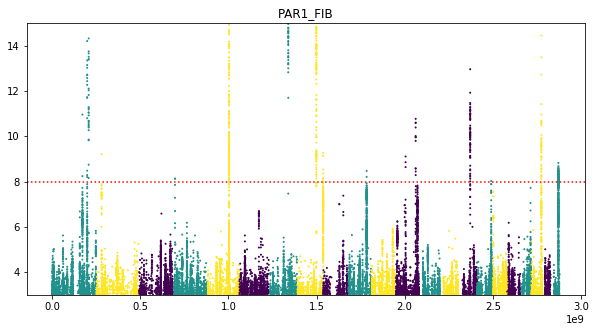

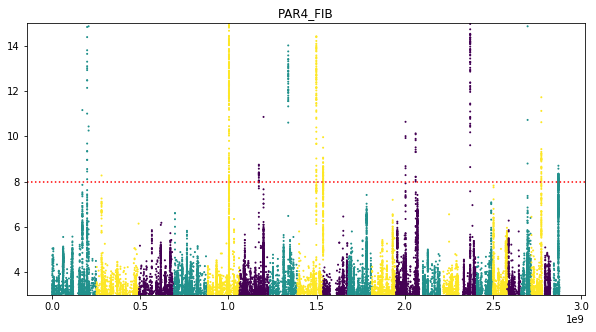

In [94]:
for c in pheno_cols:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    d = gw_.loc[gw_.pheno == c]
    ax.scatter(d.POS,-np.log10(d.P),c=d.CHR % 3,s=1.)
    ax.set_ylim((3,15))
    ax.set_title(c)
    plt.axhline(8,c="red",ls=":")

## Get list of UKBB SNPs

In [40]:
import subprocess
n_splits = 8
for chrom in [2]:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --write-snplist"
    command += " --out %s/UKBB_SNPS_CHR%d" % (export_folder, chrom)
    
    f_name = "/home/hv270/interval_slurm_calls/call_list_snps_chr%s.sh" % chrom
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=2:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % ("UKBB_SNPs",chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % chrom)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 2


In [95]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

100%|██████████| 22/22 [01:21<00:00,  3.71s/it]

93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']


In [96]:
gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

0.9294339779234791


## Isolate one SNP per region

In [97]:
from sklearn.cluster import AgglomerativeClustering
import myvariant
mv = myvariant.MyVariantInfo()

In [98]:
good = {}
gene_names = {}
max_distance = 2e5
for c in pheno_cols:
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < 1e-8) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    good[c] = hits.sort_values("P",ascending=True).groupby("region").first().sort_values(["CHR","BP"])
    
    to_query = [snp for snp in good[c].SNP.tolist() if snp not in gene_names]
    a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)
    
    for i in range(len(a)):
        q = a[i]["query"]
        try:
            gene = a[i]["cadd"]["gene"]["genename"]
        except:
            try:
                gene = a[i]["dbsnp"]["gene"]["symbol"]
            except:
                try:
                    gene = a[i]["wellderly"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"]["genename"]
                    except:
                        try:
                            gene = a[i]["snpeff"]["ann"][0]["genename"]
                        except:
                            gene = "not found"
        if q in gene_names:
            gene_names[q].append(gene)
        else:
            gene_names[q] = [gene]
            
    for q in good[c].SNP.unique().tolist():
        good[c].loc[good[c].SNP == q,"genes"] = ", ".join(list(set(gene_names[q])))
    

querying 1-16...done.
Finished.
7 input query terms found dup hits:
	[('rs6425521', 2), ('rs34101855', 2), ('rs655029', 2), ('rs653178', 2), ('rs59001897', 2), ('rs16544
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-7...done.
Finished.
4 input query terms found dup hits:
	[('rs12037133', 3), ('rs1055301', 3), ('rs17630235', 2), ('rs11066309', 3)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-9...done.
Finished.
7 input query terms found dup hits:
	[('rs11204523', 3), ('rs12640189', 2), ('rs342290', 3), ('rs61751937', 2), ('rs10786697', 3), ('rs11
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1...done.
Finished.
querying 1-4...done.
Finished.
2 input query terms found dup hits:
	[('rs9372251', 2), ('rs7310615', 3)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [99]:
good["ADP_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                 
14       rs6425521    1  171942783       0       C       A  0.193297   
3        rs1434282    1  199010721       0       C       T  0.265178   
4       rs34101855    1  207281706       0       A      AG  0.880331   
9         rs655029    2   31477838       0       G       A  0.286721   
7       rs62377399    5  122324679       0       G       A  0.681626   
13        rs342293    7  106372219       0       C       G  0.542112   
12       rs6993770    8  106581528       0       A       T  0.715736   
1       rs55831924    8  145031968       0       C       T  0.640723   
5       rs35979828   12   54685880       0       C       T  0.928642   
2         rs653178   12  112007756       0       C       T  0.482365   
6        rs7961894   12  122365583       0       C       T  0.885074   
15      rs59001897   15   65160392       0       T       A  0.833345   
11       rs7188868   16   81886135       0       A       G  0.790595   
10       rs1654425   19   55538980       0       T       C  0.166893   
0        rs6064731   20   57547945       0       A       G  0.690507   
8        rs2068944   22   43356442       0       T       G  0.438665   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P    pheno  \
region                                                                        
14      0.005552  0.036368  0.004384    1.100000e-16  1.800000e-17  ADP_FIB   
3       0.067161  0.033951  0.004050    5.200000e-17  5.600000e-17  ADP_FIB   
4       0.014895  0.049180  0.005329    2.700000e-20  2.700000e-20  ADP_FIB   
9       0.089909 -0.022605  0.003987    1.400000e-08  4.400000e-09  ADP_FIB   
7       0.039031  0.039508  0.003757    7.300000e-26  2.000000e-26  ADP_FIB   
13      0.002031  0.032869  0.003481    3.600000e-21  7.800000e-22  ADP_FIB   
12      0.006601  0.039260  0.003822    9.300000e-25  2.800000e-25  ADP_FIB   
1       0.039234 -0.022199  0.003653    1.200000e-09  5.500000e-10  ADP_FIB   
5       0.002370  0.041377  0.006676    5.700000e-10  3.600000e-10  ADP_FIB   
2       0.001862 -0.022010  0.003442    1.600000e-10  1.600000e-10  ADP_FIB   
6       0.000305  0.052995  0.005437    1.900000e-22  1.200000e-22  ADP_FIB   
15      0.052842 -0.037042  0.004748    6.200000e-15  2.600000e-15  ADP_FIB   
11      0.029992 -0.025633  0.004307    2.700000e-09  3.600000e-09  ADP_FIB   
10      0.004502 -0.026245  0.004597    1.100000e-08  7.400000e-09  ADP_FIB   
0       0.046782 -0.029098  0.003824    2.700000e-14  6.900000e-15  ADP_FIB   
8       0.039132  0.020466  0.003533    6.900000e-09  7.300000e-09  ADP_FIB   

               POS  IN_UKBB        genes  
region                                    
14       171942783     True         DNM3  
3        199010721     True    LINC01221  
4        207281706     True        C4BPA  
9        280718381     True         EHD3  
7       1003757336     True        SNX24  
13      1339694880     True   CTB-30L5.1  
12      1499032756     True        ZFPM2  
1       1537483196     True         PLEC  
5       2005058364     True         NFE2  
2       2062380240     True        ATXN2  
6       2072738067     True        WDR66  
15      2371773757     True      PLEKHO2  
11      2491020631     True        PLCG2  
10      2714173637     True          GP6  
0       2775301526     True  GNAS-NELFCD  
8       2872193093     True      PACSIN2

In [100]:
gene_names = good["TRAP_FIB"].genes.tolist()
for g in gene_names:
    if g != "not found":
        print(g)

PEAR1
DNM3
LINC01221
C4BPA
TRIM58
KIAA0232-TBC1D14
SNX24
CTB-111H14.1, CTB-30L5.1
ZFPM2
PLEC
TXNDC8
SVEP1
SUFU
WDR66
PLEKHO2
PLCG2
P2RX1
GP6
TUBB1


In [15]:
good["CRP_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                  
0        rs12037133    1  171949999       0       G       T  0.190014   
7         rs1434282    1  199010721       0       C       T  0.265178   
14       rs34101855    1  207281706       0       A      AG  0.880331   
17         rs655029    2   31477838       0       G       A  0.286721   
5        rs62377399    5  122324679       0       G       A  0.681626   
6         rs1055301    6  110713042       0       A       G  0.563939   
15         rs342293    7  106372219       0       C       G  0.542112   
12        rs6993770    8  106581528       0       A       T  0.715736   
10       rs55831924    8  145031968       0       C       T  0.640723   
8        rs80012730   12   49671659       0       A       C  0.928254   
2        rs35979828   12   54685880       0       C       T  0.928642   
1          rs653178   12  112007756       0       C       T  0.482365   
18       rs17630235   12  112591686       0       G       A  0.590091   
13       rs11066309   12  112883476       0       G       A  0.588526   
4         rs7961894   12  122365583       0       C       T  0.885074   
11       rs59001897   15   65160392       0       T       A  0.833345   
9        rs35496032   19   38817628       0       G       A  0.986639   
3       rs117092014   20   57617444       0       G       T  0.979422   
16        rs2068944   22   43356442       0       T       G  0.438665   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P    pheno  \
region                                                                        
0       0.013845  0.025074  0.002456    1.800000e-24  8.900000e-26  CRP_FIB   
7       0.067161  0.017232  0.002242    1.500000e-14  1.400000e-14  CRP_FIB   
14      0.014895  0.027736  0.002951    5.500000e-21  4.800000e-21  CRP_FIB   
17      0.089909 -0.015413  0.002208    2.900000e-12  5.400000e-13  CRP_FIB   
5       0.039031  0.023558  0.002080    9.700000e-30  1.500000e-30  CRP_FIB   
6       0.024001 -0.012405  0.001942    1.700000e-10  1.700000e-10  CRP_FIB   
15      0.002031  0.018777  0.001927    2.000000e-22  2.500000e-23  CRP_FIB   
12      0.006601  0.020261  0.002116    1.000000e-21  2.600000e-22  CRP_FIB   
10      0.039234 -0.012558  0.002023    5.400000e-10  1.700000e-10  CRP_FIB   
8       0.018381  0.023096  0.003734    6.200000e-10  4.500000e-10  CRP_FIB   
2       0.002370  0.023294  0.003697    3.000000e-10  1.500000e-10  CRP_FIB   
1       0.001862 -0.013720  0.001906    6.100000e-13  6.300000e-13  CRP_FIB   
18      0.001083  0.011495  0.001935    2.900000e-09  3.500000e-09  CRP_FIB   
13      0.033513  0.011839  0.001967    1.800000e-09  2.100000e-09  CRP_FIB   
4       0.000305  0.022494  0.003011    8.000000e-14  4.600000e-14  CRP_FIB   
11      0.052842 -0.020932  0.002629    1.700000e-15  5.000000e-16  CRP_FIB   
9       0.000474 -0.050615  0.008278    9.700000e-10  8.100000e-10  CRP_FIB   
3       0.006398 -0.046265  0.006744    6.900000e-12  2.100000e-12  CRP_FIB   
16      0.039132  0.014303  0.001956    2.700000e-13  2.400000e-13  CRP_FIB   

               POS  IN_UKBB        genes  
region                                    
0        171949999     True         DNM3  
7        199010721     True    LINC01221  
14       207281706     True        C4BPA  
17       280718381     True         EHD3  
5       1003757336     True        SNX24  
6       1172982297     True          DDO  
15      1339694880     True   CTB-30L5.1  
12      1499032756     True        ZFPM2  
10      1537483196     True         PLEC  
8       2000044143     True       TUBA1C  
2       2005058364     True         NFE2  
1       2062380240     True        ATXN2  
18      2062964170     True       TRAFD1  
13      2063255960     True       PTPN11  
4       2072738067     True        WDR66  
11      2371773757     True      PLEKHO2  
9       2697452285     True        KCNK6  
3    

In [16]:
good["PAR4_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                  
6         rs6425521    1  171942783       0       C       A  0.193297   
3         rs1434282    1  199010721       0       C       T  0.265178   
16       rs34101855    1  207281706       0       A      AG  0.880331   
10         rs655029    2   31477838       0       G       A  0.286721   
13       rs62377399    5  122324679       0       G       A  0.681626   
14        rs9372251    6  110700656       0       A       G  0.562989   
12       rs12191772    6  137259725       0       G       A  0.811845   
15         rs342293    7  106372219       0       C       G  0.542112   
5         rs6993770    8  106581528       0       A       T  0.715736   
8        rs55831924    8  145031968       0       C       T  0.640723   
2        rs35979828   12   54685880       0       C       T  0.928642   
1         rs7310615   12  111865049       0       C       G  0.483991   
9         rs7961894   12  122365583       0       C       T  0.885074   
11       rs59001897   15   65160392       0       T       A  0.833345   
17      rs111482267   19   38574098       0       T       G  0.986163   
7        rs35496032   19   38817628       0       G       A  0.986639   
4         rs6064731   20   57547945       0       A       G  0.690507   
0         rs2068944   22   43356442       0       T       G  0.438665   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P     pheno  \
region                                                                         
6       0.005552  0.023175  0.002695    8.100000e-18  1.100000e-18  PAR4_FIB   
3       0.067161  0.020770  0.002490    7.300000e-17  7.400000e-17  PAR4_FIB   
16      0.014895  0.034669  0.003276    3.600000e-26  2.500000e-26  PAR4_FIB   
10      0.089909 -0.013707  0.002451    2.200000e-08  5.400000e-09  PAR4_FIB   
13      0.039031  0.026042  0.002309    1.700000e-29  2.500000e-30  PAR4_FIB   
14      0.044751 -0.013127  0.002178    1.700000e-09  1.800000e-09  PAR4_FIB   
12      0.002031 -0.018046  0.002710    2.800000e-11  1.400000e-11  PAR4_FIB   
15      0.002031  0.019812  0.002140    2.100000e-20  4.200000e-21  PAR4_FIB   
5       0.006601  0.023175  0.002349    6.000000e-23  1.800000e-23  PAR4_FIB   
8       0.039234 -0.013764  0.002246    8.900000e-10  3.200000e-10  PAR4_FIB   
2       0.002370  0.027048  0.004104    4.400000e-11  2.300000e-11  PAR4_FIB   
1       0.038929 -0.014021  0.002156    7.900000e-11  7.500000e-11  PAR4_FIB   
9       0.000305  0.031063  0.003342    1.500000e-20  1.100000e-20  PAR4_FIB   
11      0.052842 -0.025053  0.002919    9.300000e-18  3.400000e-18  PAR4_FIB   
17      0.011611 -0.054268  0.009076    2.200000e-09  1.600000e-09  PAR4_FIB   
7       0.000474 -0.073194  0.009190    1.700000e-15  1.400000e-15  PAR4_FIB   
4       0.046782 -0.016095  0.002351    7.600000e-12  1.900000e-12  PAR4_FIB   
0       0.039132  0.013050  0.002172    1.900000e-09  2.000000e-09  PAR4_FIB   

               POS  IN_UKBB        genes  
region                                    
6        171942783     True         DNM3  
3        199010721     True    LINC01221  
16       207281706     True        C4BPA  
10       280718381     True         EHD3  
13      1003757336     True        SNX24  
14      1172969911     True  METTL24-DDO  
12      1199528980     True        Y_RNA  
15      1339694880     True   CTB-30L5.1  
5       1499032756     True        ZFPM2  
8       1537483196     True         PLEC  
2       2005058364     True         NFE2  
1       2062237533     True        SH2B3  
9       2072738067     True        WDR66  
11      2371773757     True      PLEKHO2  
17      2697208755     True      SIPA1L3  
7       2697452285     True        KCNK6  
4       2775301526     True  GNAS-NELFCD  
0       2872193093     True      PACSIN2

In [17]:
# PEAR1
gw.loc[gw.SNP == "rs12566888"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
392801  rs12566888    1  156869047       0       G       T  0.910532   
392801  rs12566888    1  156869047       0       G       T  0.910532   
392801  rs12566888    1  156869047       0       G       T  0.910532   
392801  rs12566888    1  156869047       0       G       T  0.910532   
392801  rs12566888    1  156869047       0       G       T  0.910532   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P     pheno  
392801  0.003588  0.030329  0.006031    4.900000e-07  2.000000e-07   ADP_FIB  
392801  0.003588  0.011413  0.003339    6.300000e-04  3.600000e-04   CRP_FIB  
392801  0.003588  0.023221  0.003898    2.600000e-09  9.800000e-10  TRAP_FIB  
392801  0.003588  0.019550  0.003882    4.700000e-07  2.100000e-07  PAR1_FIB  
392801  0.003588  0.016083  0.003707    1.400000e-05  6.200000e-06  PAR4_FIB

In [467]:
# ADRA2A (epinephrine)
gw.loc[gw.SNP == "rs4311994"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
5795507  rs4311994   10  112903090       0       C       T  0.842359   
5795507  rs4311994   10  112903090       0       C       T  0.842359   
5795507  rs4311994   10  112903090       0       C       T  0.842359   
5795507  rs4311994   10  112903090       0       C       T  0.842359   
5795507  rs4311994   10  112903090       0       C       T  0.842359   

           F_MISS      BETA        SE  P_BOLT_LMM_INF     P     pheno  
5795507  0.018551 -0.001623  0.004765            0.73  0.74   ADP_FIB  
5795507  0.018551 -0.000093  0.002638            0.97  0.99   CRP_FIB  
5795507  0.018551 -0.002144  0.003080            0.49  0.50  TRAP_FIB  
5795507  0.018551 -0.001284  0.003067            0.68  0.69  PAR1_FIB  
5795507  0.018551 -0.000130  0.002929            0.96  0.97  PAR4_FIB

In [19]:
# GP6
gw.loc[gw.SNP == "rs1671152"]

SNP  CHR        BP  GENPOS ALLELE1 ALLELE0    A1FREQ    F_MISS  \
8620491  rs1671152   19  55526345       0       T       G  0.157733  0.026201   
8620491  rs1671152   19  55526345       0       T       G  0.157733  0.026201   
8620491  rs1671152   19  55526345       0       T       G  0.157733  0.026201   
8620491  rs1671152   19  55526345       0       T       G  0.157733  0.026201   
8620491  rs1671152   19  55526345       0       T       G  0.157733  0.026201   

             BETA        SE  P_BOLT_LMM_INF             P     pheno  
8620491 -0.022736  0.004766    1.800000e-06  1.400000e-06   ADP_FIB  
8620491 -0.006250  0.002639    1.800000e-02  1.700000e-02   CRP_FIB  
8620491 -0.018278  0.003081    3.000000e-09  2.100000e-09  TRAP_FIB  
8620491 -0.014152  0.003068    4.000000e-06  3.200000e-06  PAR1_FIB  
8620491 -0.012164  0.002930    3.300000e-05  2.600000e-05  PAR4_FIB

## Box plots

In [358]:
s_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample"

In [359]:
bgens = {}
for CH in tqdm(range(1,23)):
    f_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_%d_interval.bgen" % CH
    bgens[CH] = BgenFile(f_path, sample_path=s_path, delay_parsing=True)

100%|██████████| 22/22 [00:00<00:00, 159.89it/s]


In [360]:
interesting_IDs = []
for c in pheno_cols:
    interesting_IDs += good[c].SNP.tolist()

In [361]:
interesting_IDs += ["rs1671152"] # GP6

In [362]:
dosages = {}
dom = {}
alleles = {}
for CH in [19]:
    for v in tqdm(bgens[CH]):
        if v.rsid in interesting_IDs:
            dosages[v.rsid] = v.minor_allele_dosage
            dom[v.rsid] = np.argmax(v.probabilities,axis=1)
            alleles[v.rsid] = v.alleles

100%|██████████| 1965269/1965269 [00:22<00:00, 88970.62it/s]


In [369]:
samples = bgens[1].samples
phenotypes = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder,tag),sep="\t")
covariates = pd.read_csv("%s/%s/covars.csv" % (export_folder,tag),sep="\t")

del phenotypes["FID"]
del covariates["FID"]
#for c in covariates.columns:
#    if "PC" in c and c != "PCT":
#        del covariates[c]
phenotypes.set_index("IID",inplace=True)
covariates.set_index("IID",inplace=True)
covariates = pd.concat((covariates,pd.get_dummies(covariates["cohort_covar"])),axis=1)
del covariates["cohort_covar"]
X = pd.merge(phenotypes,covariates,how="inner",left_index=True,right_index=True)
covars_no_IPF = [c for c in covariates.columns if "IPF" != c]
X_noIPF = pd.merge(phenotypes,
                   covariates[covars_no_IPF],
                   how="inner",
                   left_index=True,right_index=True)




In [370]:
from sklearn.linear_model import LinearRegression

In [371]:
lm = LinearRegression().fit(X[covariates.columns],X[phenotypes.columns])
X[phenotypes.columns] = X[phenotypes.columns] - lm.predict(X[covariates.columns])

lm = LinearRegression().fit(X_noIPF[covars_no_IPF],X_noIPF[phenotypes.columns])
X_noIPF[phenotypes.columns] = X_noIPF[phenotypes.columns] - lm.predict(X_noIPF[covars_no_IPF])

In [372]:
X[covariates.columns]

MPV       PLT       PCT       PDW  IPF   Age  Sex  \
IID                                                                    
110000305926 -0.848502  0.480246  0.091909 -0.935094  1.9  48.7  2.0   
110000305952 -0.848502  0.210685 -0.481372 -0.535597  1.7  49.9  1.0   
110000315493  0.423036 -0.672917 -0.281520  0.373625  2.2  56.2  1.0   
110000315494  0.623413  0.526358  0.909767  0.153567  4.6  56.6  2.0   
110000315495  0.816585 -0.984377 -0.689361  0.773248  8.5  37.5  1.0   
...                ...       ...       ...       ...  ...   ...  ...   
119999995908 -0.296161 -0.545464 -0.689361 -0.123185  3.3  55.9  1.0   
119999995922 -0.962628  0.618548  0.270579 -0.817986  1.9  58.9  2.0   
119999995934  0.325110  0.753782  1.200122  0.412638  3.4  22.8  1.0   
119999995944  1.085476 -0.401197  0.270579  1.105582  6.9  20.9  1.0   
119999995958 -0.188174  0.263303  0.091909 -0.123185  3.6  65.9  2.0   

              age_covar  instrument_covar       PC1  ...       PC4       PC5  \
IID                                                  ...                       
110000305926   0.152542                 1  0.001051  ... -0.000485  0.003907   
110000305952   0.203390                 1 -0.000064  ...  0.006369 -0.002127   
110000315493   0.470339                 1  0.001009  ...  0.008209  0.002722   
110000315494   0.487288                 0  0.006815  ... -0.005582 -0.005617   
110000315495  -0.322034                 0  0.006833  ...  0.000562  0.008410   
...                 ...               ...       ...  ...       ...       ...   
119999995908   0.457627                 0  0.006282  ... -0.002726  0.004170   
119999995922   0.584746                 1  0.005786  ... -0.000380  0.005957   
119999995934  -0.944915                 0 -0.007510  ... -0.002013 -0.004946   
119999995944  -1.025424                 0  0.000856  ... -0.005159  0.000064   
119999995958   0.881356                 1 -0.000309  ... -0.006871  0.002052   

                   PC6       PC7       PC8       PC9      PC10  0  1  2  
IID                                                                      
110000305926 -0.001036  0.003214  0.007618 -0.000403 -0.004247  1  0  0  
110000305952  0.006433  0.001969 -0.000814 -0.000623  0.001776  1  0  0  
110000315493  0.004606  0.004591  0.006361  0.002414  0.001101  1  0  0  
110000315494  0.001646  0.000007  0.000766  0.007461  0.002496  1  0  0  
110000315495  0.002672  0.010753  0.005626  0.001188  0.000879  1  0  0  
...                ...       ...       ...       ...       ... .. .. ..  
119999995908 -0.004865  0.001438  0.000362 -0.005078 -0.001738  1  0  0  
119999995922 -0.001834  0.000926  0.000208 -0.002771 -0.001967  1  0  0  
119999995934 -0.001235  0.003813  0.010033  0.004138  0.002752  1  0  0  
119999995944  0.004055 -0.005480  0.001067  0.008342 -0.005231  1  0  0  
119999995958  0.001865  0.008149  0.003399 -0.004282  0.004645  1  0  0  

[29545 rows x 22 columns]

In [373]:
from scipy.stats import pearsonr

In [356]:
for c in phenotypes.columns:
    print(c, pearsonr(X[c],phenotypes[c]))

ADP_FIB (0.4966026562842976, 0.0)
CRP_FIB (0.5022260455793013, 0.0)
TRAP_FIB (0.5383688691038492, 0.0)
PAR1_FIB (0.49166275328656445, 0.0)
PAR4_FIB (0.5144178841694917, 0.0)


In [374]:
for c in phenotypes.columns:
    print(c, pearsonr(X_noIPF[c],phenotypes[c]))

ADP_FIB (0.5851804946999697, 0.0)
CRP_FIB (0.6729397940492309, 0.0)
TRAP_FIB (0.6438624530056524, 0.0)
PAR1_FIB (0.6932584843285662, 0.0)
PAR4_FIB (0.573721668465076, 0.0)


In [380]:
s = gw.loc[gw.SNP.isin(interesting_IDs)]

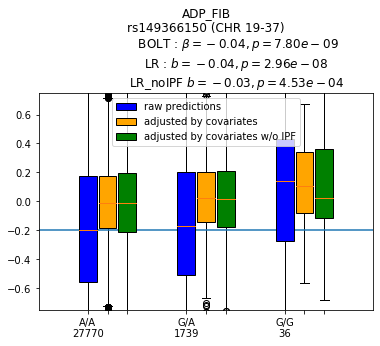

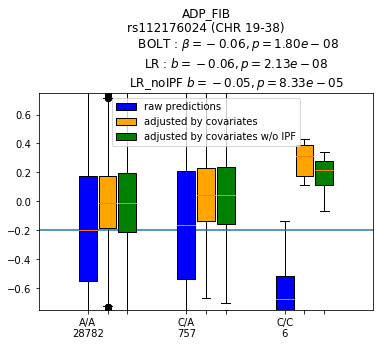

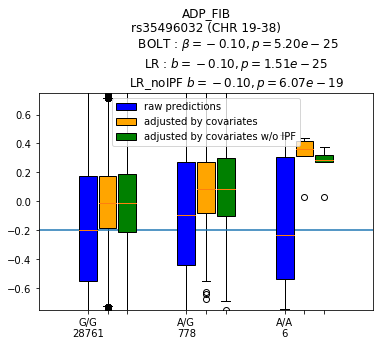

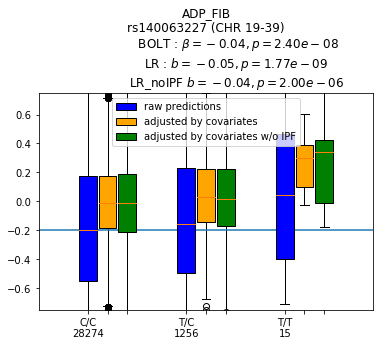

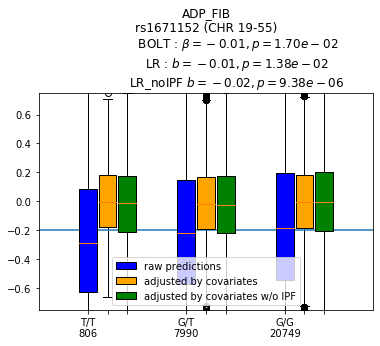

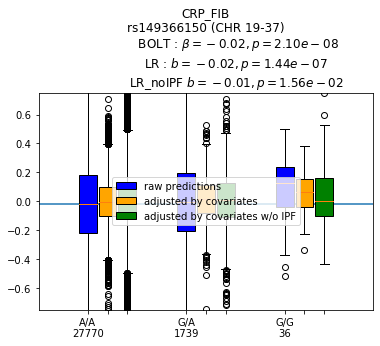

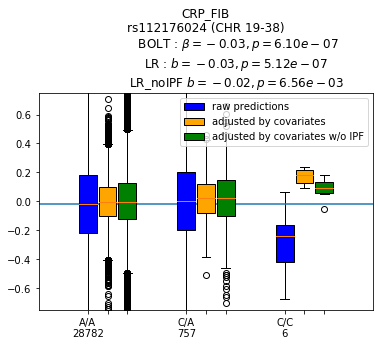

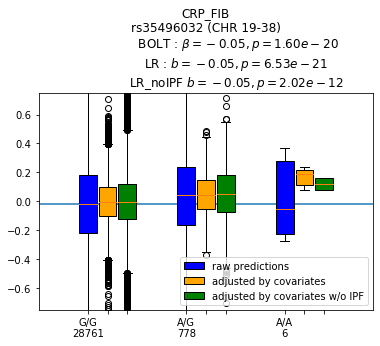

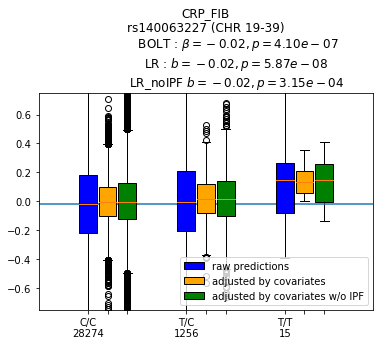

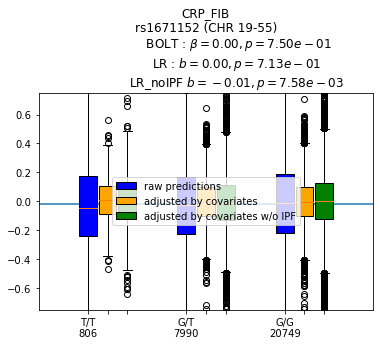

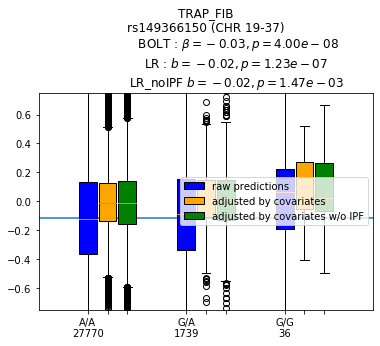

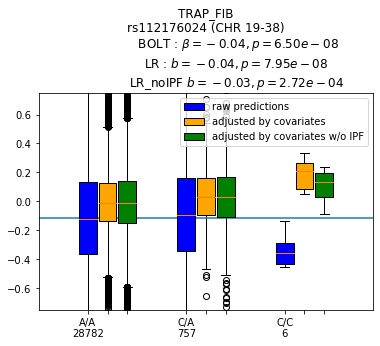

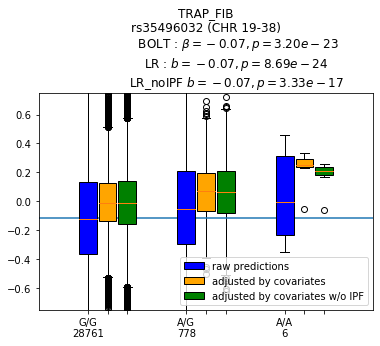

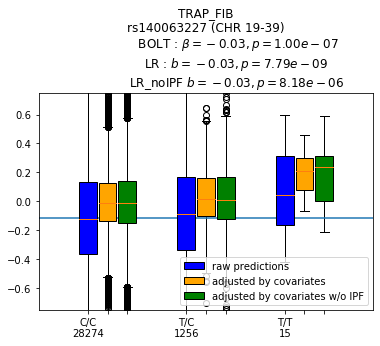

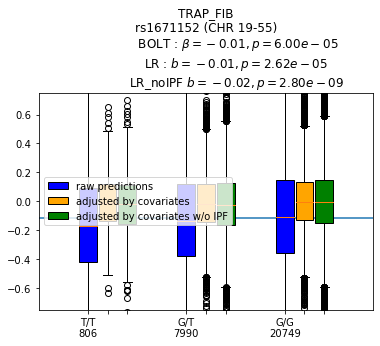

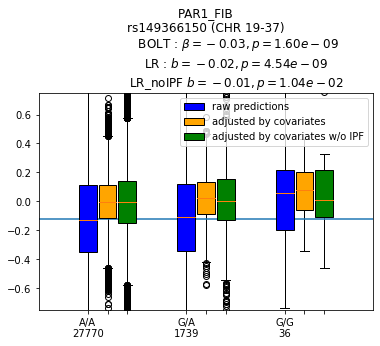

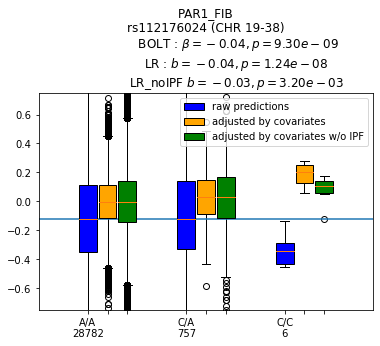

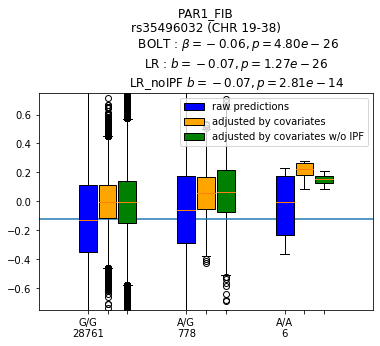

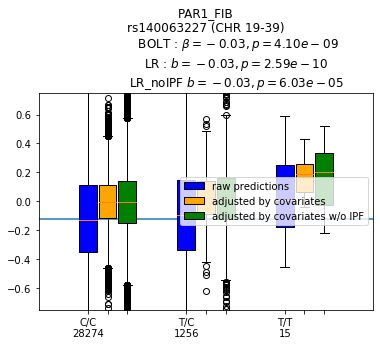

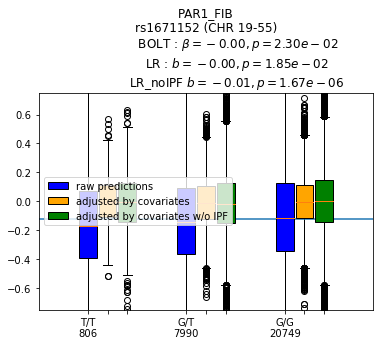

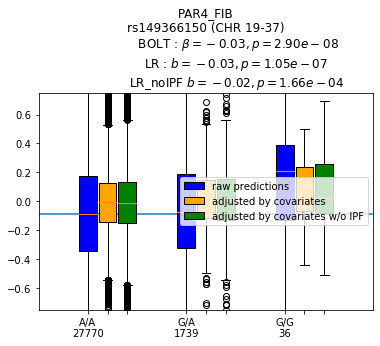

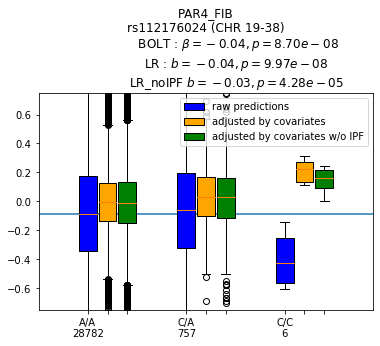

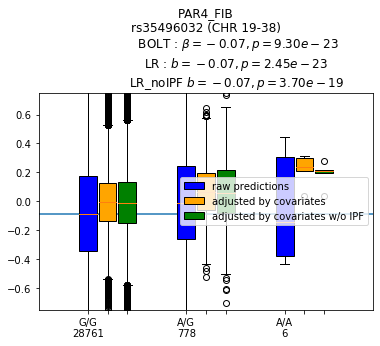

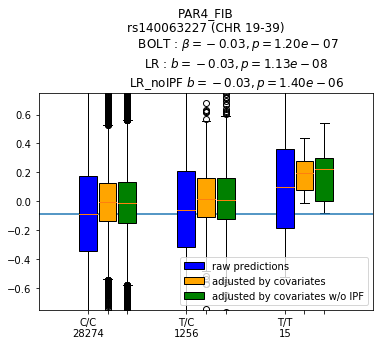

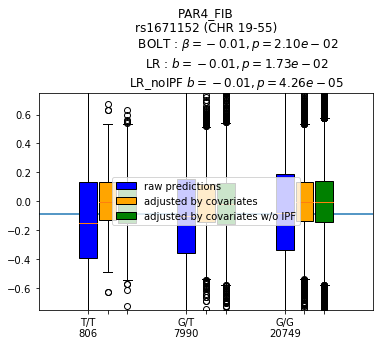

In [386]:
for c in pheno_cols:
    for SNP in alleles:
        row = s.loc[(s.SNP == SNP) & (s.pheno == c)].iloc[0]
        if row["CHR"] not in [19]: continue
        fig = plt.figure()
        ax = fig.add_subplot(111)
        IDs = {}
        allele_counts = sorted(np.unique(dom[row["SNP"]]))
        allele = alleles[row["SNP"]]
        allele_ref = ["%s/%s" % (allele[0],allele[0]), "%s/%s" % (allele[1],allele[0]), "%s/%s" % (allele[1],allele[1])]
        for k in allele_counts:
            IDs[k] = [int(samples[i]) for i in np.where(dom[row["SNP"]] == k)[0]]
        bp1 = ax.boxplot([phenotypes.loc[phenotypes.index.isin(IDs[k]),c] for k in allele_counts],
                  positions=np.arange(len(IDs))-.2,
                           widths=0.18,
                           patch_artist=True,
                           meanprops={"color":"red"},
                           boxprops={"facecolor":"blue"})
        bp2 = ax.boxplot([X.loc[X.index.isin(IDs[k]),c] for k in allele_counts],
                  positions=np.arange(len(IDs)),
                           widths=0.18,
                           patch_artist=True,
                           meanprops={"color":"red"},
                           boxprops={"facecolor":"orange"})
        
        bp3 = ax.boxplot([X_noIPF.loc[X_noIPF.index.isin(IDs[k]),c] for k in allele_counts],
                  positions=np.arange(len(IDs))+.2,
                           widths=0.18,
                           patch_artist=True,
                           meanprops={"color":"red"},
                           boxprops={"facecolor":"green"})
        
        M = pd.DataFrame(data={"IID":[int(s) for s in samples],"count":dom[row["SNP"]]})
        M = pd.merge(M,X, left_on="IID",right_on="IID",how="right")
        
        _, p = pearsonr(M["count"],M[c])
        b = -LinearRegression().fit(np.reshape(M["count"].values,(-1,1)),M[c]).coef_[0]
        
        M = pd.DataFrame(data={"IID":[int(s) for s in samples],"count":dom[row["SNP"]]})
        M = pd.merge(M,X_noIPF, left_on="IID",right_on="IID",how="right")
        
        _, p_noIPF = pearsonr(M["count"],M[c])
        b_noIPF = -LinearRegression().fit(np.reshape(M["count"].values,(-1,1)),M[c]).coef_[0]
        
        ax.set_xticklabels([allele_ref[k] + "\n" + str(phenotypes.index.isin(IDs[k]).sum()) for k in allele_counts])
        ax.set_title("%s\n%s (CHR %d-%d)\n \
                BOLT : $\\beta = %.2f, p=%.2e$\n\
                LR : $b=%.2f, p=%.2e$\n\
                LR_noIPF $b=%.2f, p=%.2e$" % \
                     (c, row["SNP"], int(row["CHR"]),int(row["BP"]) // int(1e6),
                      row["BETA"], row["P"], 
                      b, p,b_noIPF,p_noIPF))
        ax.set_ylim((-.75,.75))
        ax.axhline(phenotypes[c].median())
        ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["raw predictions", "adjusted by covariates", "adjusted by covariates w/o IPF"])

In [41]:
good["PAR4_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                  
8        rs34101855    1  207281706       0       A      AG  0.880335   
6         rs7536995    1  248012098       0       C       T  0.256876   
9        rs11393160    4    6857838       0       C      CT  0.839881   
4        rs10076288    5  122101327       0       A       G  0.441059   
3        rs12655145    5  150835349       0       A       G  0.387112   
7        rs12191772    6  137259725       0       G       A  0.811704   
2        rs12680382    8  106524285       0       G       A  0.739371   
0         rs7961894   12  122365583       0       C       T  0.884748   
11      rs149366150   19   37343674       0       A       G  0.969968   
5        rs35496032   19   38817628       0       G       A  0.986400   
10      rs560568175   20   50327067       0       C       G  0.992533   
1          rs463312   20   57597970       0       A       C  0.951130   

          F_MISS      BETA        SE             P     pheno         POS  \
region                                                                     
8       0.015247  0.034473  0.003074  3.500000e-29  PAR4_FIB   207281706   
6       0.007859  0.013382  0.002286  4.800000e-09  PAR4_FIB   248012098   
9       0.064967 -0.016586  0.002792  2.800000e-09  PAR4_FIB   697246618   
4       0.004216 -0.014053  0.002006  2.400000e-12  PAR4_FIB  1003533984   
3       0.048911  0.012479  0.002093  2.500000e-09  PAR4_FIB  1032268006   
7       0.001923 -0.019758  0.002548  8.800000e-15  PAR4_FIB  1199528980   
2       0.016191  0.018937  0.002282  1.000000e-16  PAR4_FIB  1498975513   
0       0.000371  0.032929  0.003143  1.100000e-25  PAR4_FIB  2072738067   
11      0.059333 -0.034901  0.005955  4.600000e-09  PAR4_FIB  2695978331   
5       0.000439 -0.061643  0.008565  6.100000e-13  PAR4_FIB  2697452285   
10      0.031033 -0.068421  0.011729  5.400000e-09  PAR4_FIB  2768080648   
1       0.001585 -0.075866  0.004647  6.600000e-60  PAR4_FIB  2775351551   

        IN_UKBB  
region           
8          True  
6          True  
9          True  
4          True  
3          True  
7          True  
2          True  
0          True  
11         True  
5          True  
10         True  
1          True

# Genetic scores of Sysmex phenotypes

In [234]:
sys_gwas = pd.read_excel("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/GWAS_Sysmex_traits_hits.xlsx")
sys_gwas = sys_gwas.rename(columns={"Associated Blood Index":"pheno",
                                    "rsID (where available)":"rsID",
                                    "Chr (GRCh37)":"CHR",
                                    "BP (GRCh37)":"BP",
                                    "REF (GRC37)":"REF",
                                    "ALT (GRC37)":"ALT",
                                    "(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)":"BETA"})
sys_phenos = ["PLT#","MPV","PCT","PDW"]
sys_gwas = sys_gwas.loc[sys_gwas["pheno"].isin(sys_phenos)]

sys_gwas[["pheno","rsID","CHR","BP","REF","ALT","BETA"]].head()

pheno         rsID CHR       BP   REF ALT      BETA
8   PLT#   rs34646035   1  2166607     G  GT -0.025125
9    PCT   rs34646035   1  2166607     G  GT -0.022806
10   PDW  rs141190925   1  2234040  CAGG   C -0.031649
14   PCT  rs113565775   1  2978755     A  AG  0.029835
16   PCT    rs1569419   1  2996602     T   C  0.041643

In [235]:
for pheno in sys_phenos:
    betas_path = "%s/Genetic_score_Sysmex_traits/%s.csv" % (export_folder,pheno)
    sys_gwas.loc[sys_gwas.pheno == pheno,["rsID","ALT","BETA"]]\
        .to_csv(betas_path,
                sep="\t",index=False,header=False)
    
    causal_snps = sys_gwas.loc[sys_gwas.pheno == pheno].rsID.tolist()
    causal_snps_path = "%s/Genetic_score_Sysmex_traits/causal_snps_%s" % (export_folder,pheno)
    with open(causal_snps_path,"w") as snp_file:
        for snp in causal_snps:
            snp_file.write("%s\n" % snp)
    
    n_splits = 16
    
    for chrom in sys_gwas.loc[sys_gwas.pheno == pheno].CHR.unique().tolist():
        command = "/home/hv270/Plink2/plink2"
        command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
        command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
        #command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1"
        command += " --extract %s" % causal_snps_path
        command += " --keep %s" % EUR_path
        command += " --score %s" % betas_path
        #command += " --q-score-range %s %s/bolt_res_ADP_FIB 1 12" % (range_file_path, export_folder)
        #useless if we keep only causal SNPs with good p values
        command += " --out %s/Genetic_score_Sysmex_traits/%s_causal_score_chr%s" % (export_folder,pheno,chrom)
        command += " --threads %d" % n_splits

        f_name = "/home/hv270/interval_slurm_calls/call_gs_chr%s.sh" % chrom
        f = open(f_name,"w+")
        f.write("#!/bin/sh\n")

        f.write("#SBATCH -J chr%s\n" % (chrom))
        f.write("#SBATCH -A ASTLE-SL2-CPU\n")
        f.write("#SBATCH -N 1\n")
        f.write("#SBATCH -n %d\n" % n_splits)
        #f.write("#SBATCH -c %d\n" % n_splits)
        f.write("#SBATCH --time=5:30:00\n")
        f.write("#SBATCH -p skylake-himem\n")
        f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",pheno,chrom))
        f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

        f.write(". /etc/profile.d/modules.sh\n")
        f.write("module purge\n")
        f.write("module load rhel7/default-peta4\n")
        f.write(command)
        f.close()

        print("Submitting %s" % chrom)
        p = subprocess.Popen("sbatch %s" % f_name,shell=True)
        p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22
Submitting X
Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22
Submitting X
Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22
Submitting X
Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5

# Genetic scores of predicted phenotypes

In [3]:
# Extract rsIDs present in UKBB files, as well as ref/alt alleles
# Compute score based on best alleles

## Compute

In [4]:
tag

NameError: name 'tag' is not defined

In [101]:
for pheno in pheno_cols:
    # Checked only on one sample, that REF was the column to use
    # It corresponds to the same side (between ref and alt) 
    # as the one used to compute the score of our phenotypes based on interval GWAS
    betas_path = "%s/Genetic_score_Sysmex_traits/%s.csv" % (export_folder,pheno)
    good[pheno][["SNP","ALLELE1","BETA"]]\
        .to_csv(betas_path,
                sep="\t",index=False,header=False)
    
    causal_snps = good[pheno].SNP.tolist()
    causal_snps_path = "%s/Genetic_score_Sysmex_traits/causal_snps_%s" % (export_folder,pheno)
    with open(causal_snps_path,"w") as snp_file:
        for snp in causal_snps:
            snp_file.write("%s\n" % snp)
    
    n_splits = 8

    for chrom in good[pheno].CHR.unique().tolist():
        command = "/home/hv270/Plink2/plink2"
        command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
        command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
        command += " --extract %s" % causal_snps_path
        command += " --keep %s" % EUR_path
        command += " --score %s" % betas_path
        command += " --out %s/Genetic_score_Sysmex_traits/%s/%s_good_score_chr%s" % (export_folder,tag,pheno,chrom)
        command += " --threads %d" % n_splits

        f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_%s_%s.sh" % (chrom,tag,pheno)
        f = open(f_name,"w+")
        f.write("#!/bin/sh\n")

        f.write("#SBATCH -J chr%s\n" % (chrom))
        f.write("#SBATCH -A ASTLE-SL2-CPU\n")
        f.write("#SBATCH -N 1\n")
        f.write("#SBATCH -n %d\n" % n_splits)
        f.write("#SBATCH --time=5:30:00\n")
        f.write("#SBATCH -p skylake-himem\n")
        f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s_%s.out\n" % ("GS",tag,pheno,chrom))
        f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

        f.write(". /etc/profile.d/modules.sh\n")
        f.write("module purge\n")
        f.write("module load rhel7/default-peta4\n")
        f.write(command)
        f.close()

        print("Submitting %s %s" % (pheno,chrom))
        p = subprocess.Popen("sbatch %s" % f_name,shell=True)
        p.wait()

Submitting ADP_FIB 1
Submitting ADP_FIB 2
Submitting ADP_FIB 5
Submitting ADP_FIB 7
Submitting ADP_FIB 8
Submitting ADP_FIB 12
Submitting ADP_FIB 15
Submitting ADP_FIB 16
Submitting ADP_FIB 19
Submitting ADP_FIB 20
Submitting ADP_FIB 22
Submitting CRP_FIB 1
Submitting CRP_FIB 2
Submitting CRP_FIB 5
Submitting CRP_FIB 6
Submitting CRP_FIB 7
Submitting CRP_FIB 8
Submitting CRP_FIB 12
Submitting CRP_FIB 15
Submitting CRP_FIB 19
Submitting CRP_FIB 20
Submitting CRP_FIB 22
Submitting TRAP_FIB 1
Submitting TRAP_FIB 4
Submitting TRAP_FIB 5
Submitting TRAP_FIB 7
Submitting TRAP_FIB 8
Submitting TRAP_FIB 9
Submitting TRAP_FIB 10
Submitting TRAP_FIB 12
Submitting TRAP_FIB 15
Submitting TRAP_FIB 16
Submitting TRAP_FIB 17
Submitting TRAP_FIB 19
Submitting TRAP_FIB 20
Submitting PAR1_FIB 1
Submitting PAR1_FIB 2
Submitting PAR1_FIB 4
Submitting PAR1_FIB 5
Submitting PAR1_FIB 7
Submitting PAR1_FIB 8
Submitting PAR1_FIB 12
Submitting PAR1_FIB 15
Submitting PAR1_FIB 16
Submitting PAR1_FIB 20
Submitting

## Read scores

In [5]:
tag = "19feb"

In [6]:
scores = {}
for pheno in pheno_cols:
    f = glob.glob("%s/Genetic_score_Sysmex_traits/%s/%s_good_score_chr*.sscore" % (export_folder,tag,pheno))
    print([s.split("chr")[-1][:-7] for s in f])
    print(pheno,len(f))
    log_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s/%s_good_score_chr*.log" % (export_folder,tag,pheno))
    for lf in log_files:
        with open(lf,"r") as lff:
            if len(lff.readlines()) == 0:
                print("%s has an empty log file" % lf)
            
    s = [pd.read_csv(f[i],sep="\t").set_index("IID")[["SCORE1_AVG"]].rename(columns={"SCORE1_AVG":i}) for i in range(len(f))]
    scores[pheno] = pd.concat(s,axis=1,join="outer").sum(axis=1)
scores = pd.concat(scores,axis=1)

['2', '22', '8', '5', '19', '16', '20', '1', '15', '7', '12']
ADP_FIB 11
['6', '2', '7', '1', '15', '8', '12', '22', '19', '5', '20']
CRP_FIB 11
['10', '20', '1', '12', '17', '4', '19', '8', '15', '7', '5', '9', '16']
TRAP_FIB 13
['15', '8', '5', '22', '20', '16', '12', '4', '1', '2', '7']
PAR1_FIB 11
['20', '22', '1', '2', '15', '6', '12', '5', '7', '8', '19']
PAR4_FIB 11
/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/19feb/PAR4_FIB_good_score_chr6.log has an empty log file


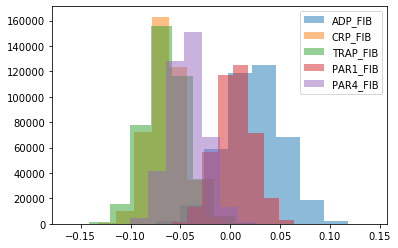

In [7]:
for s in scores:
    plt.hist(scores[s],label=s,alpha=.5)
plt.legend()

## Read Sysmex traits scores

In [8]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for i, score_file in enumerate(chrom_files):
        df = pd.read_csv(score_file,sep="\t")
        df["score"] = df["SCORE1_AVG"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % i}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:pheno}))
scores_sys = pd.concat(score_dfs,axis=1)

In [9]:
scores_sys = scores_sys.rename(columns={"PLT#":"PLT"})
scores_sys = scores_sys.add_suffix("_score")
scores_sys

PLT_score  MPV_score  PCT_score  PDW_score
IID                                                
3988147   0.011610  -0.027600   0.007958  -0.005995
5152243   0.007862  -0.016196   0.005119  -0.002073
2770265   0.004983  -0.039424  -0.017437  -0.003341
3790399  -0.001070  -0.027039  -0.009639   0.011838
4681935   0.012693  -0.028224   0.001313  -0.005025
...            ...        ...        ...        ...
4494916   0.014897  -0.021669   0.001732   0.019635
4272180  -0.001114  -0.017683  -0.004186   0.024122
2654475   0.020629  -0.039821  -0.000400  -0.003238
4943537   0.019387  -0.049689  -0.005507  -0.008037
2379838   0.026561  -0.029896  -0.003403  -0.027935

[409016 rows x 4 columns]

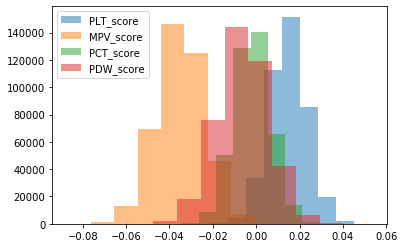

In [10]:
for c in scores_sys.columns:
    plt.hist(scores_sys[c],alpha=.5,label=c)
plt.legend()

## Read UKBB phenotypes

In [64]:
STROKE_FIELD = "42006-0.0"
ISCHAEMIC_STROKE_FIELD = "42008-0.0"
INTRACEREBRAL_HAEMO_FIELD = "42010-0.0"
BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
MI_FIELD = "42000-0.0" 
AGE_DVT = "4012-0.0" # Deep venous thrombosis, blot clot in the leg
PE_FIELD  = "4022-0.0" # pulmonary embolism, age
KINSHIP = '22021-0.0'
DEATH_FIELD = '40007-0.0'
BP_FIELD = '2966-0.0' # Age high blood pressure diagnosed
PLT = '30080-0.0'
PCT = '30090-0.0'
MPV = '30100-0.0'
PDW = '30110-0.0'
PHLEBITIS_FIELD = '131396-0.0'
RECRUITMENT_FIELD = '21022-0.0'
ISCHAEMIC_FIELD = '131306-0.0'

TOBACCO_FIELD = "22506-0.0"
ID_FIELD = "eid"

HEARING_FIELD = "2247-0.0"

ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"

for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    break
ICD10_cols = [c for c in ukbb_ if "41270" in c]
death_cols = [c for c in ukbb_ if "40002" in c]

In [75]:
cols = [ID_FIELD,BIRTH_FIELD,SEX_FIELD,STROKE_FIELD, ISCHAEMIC_STROKE_FIELD,
        INTRACEREBRAL_HAEMO_FIELD,
        MI_FIELD, PE_FIELD, AGE_DVT,
        HEARING_FIELD,
        DEATH_FIELD,
        PHLEBITIS_FIELD,
        RECRUITMENT_FIELD,
        ISCHAEMIC_FIELD,
        BP_FIELD,
        MPV, PCT, PDW, PLT,
        TOBACCO_FIELD, KINSHIP]
cols = cols + ICD10_cols #+ death_cols

ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True);

In [76]:
ukbb = ukbb_.copy().rename(columns={STROKE_FIELD:"STROKE_DATE",
                             ISCHAEMIC_STROKE_FIELD:"ISCHAEMIC_STROKE_DATE",
                             INTRACEREBRAL_HAEMO_FIELD:"INTRACEREBRAL_HAEMO_DATE",
                            MI_FIELD:"MI_DATE",
                            ID_FIELD:"ID",
                            SEX_FIELD:"SEX",
                            BIRTH_FIELD:"BIRTH",
                            HEARING_FIELD:"HEARING_FIELD",
                            AGE_DVT:"VT_AGE",
                            DEATH_FIELD:"DEATH_AGE",
                            PHLEBITIS_FIELD:"PHLEBITIS_DATE",
                            ISCHAEMIC_FIELD:"ISCHAEMIC_DATE",
                            RECRUITMENT_FIELD:"RECRUITMENT_AGE",
                            BP_FIELD:"HIGH_BP_AGE",
                            PE_FIELD:"PE_AGE",
                            KINSHIP:"KINSHIP",
                            PLT:"PLT",MPV:"MPV",PCT:"PCT",PDW:"PDW",
                            TOBACCO_FIELD:"TOBACCO"})
ukbb["BIRTH"] = pd.to_datetime(ukbb.loc[~ukbb.BIRTH.isnull(), "BIRTH"].astype(int).astype(str),format="%Y")
ukbb["MI_AGE"] = pd.to_datetime(ukbb["MI_DATE"]) - ukbb["BIRTH"]
ukbb["PHLEBITIS_AGE"] = pd.to_datetime(ukbb["PHLEBITIS_DATE"]) - ukbb["BIRTH"]
ukbb["ISCHAEMIC_AGE"] = pd.to_datetime(ukbb["ISCHAEMIC_DATE"]) - ukbb["BIRTH"]
ukbb["STROKE_AGE"] = pd.to_datetime(ukbb["STROKE_DATE"]) - ukbb["BIRTH"]
ukbb["ISCHAEMIC_STROKE_AGE"] = pd.to_datetime(ukbb["ISCHAEMIC_STROKE_DATE"]) - ukbb["BIRTH"]
ukbb["INTRACEREBRAL_HAEMO_AGE"] = pd.to_datetime(ukbb["INTRACEREBRAL_HAEMO_DATE"]) - ukbb["BIRTH"]

In [77]:
ukbb["ALL_ICD10"] = ukbb[ICD10_cols].fillna("").astype(str).apply(lambda x: ' '.join(x), axis = 1)

In [78]:
def ICD10_contains(l):
    return sum([ukbb["ALL_ICD10"].str.contains(code) for code in l]) > 0
        

# ===== COAG ======
# Here, phenotypes related to too much coagulation
ukbb["thrombophilia"] = ICD10_contains(["D685","D686"])

# Here, phenotypes related to too few coagulation
ukbb["VW_disease"] = ICD10_contains(["D680"])
ukbb["factor_XI_deficiency"] = ICD10_contains(["D681"])
ukbb["clotting_factors_deficiency"] = ICD10_contains(["D682"])

# Unspecified coagulation defects
ukbb["unspec_coag_deffect"] = ICD10_contains(["D689"])

# ====== Haemorrhagic conditions =======
ukbb["purpura"] = ICD10_contains(["D690","D692"])
ukbb["diverse_hameo"] = ICD10_contains(["D698","D699"])
ukbb["qualitative_platelet_defects"] = ICD10_contains(["D691"])
ukbb["thrombocytopenia"] = ICD10_contains(["D693","D694","D695","D696"])

# ====== Hypertension ========
ukbb["hypertension"] = ICD10_contains(["I10"])

# ====== Ischaemic heart disease ======
ukbb["angina_pectoris"] = ICD10_contains(["I20"])
ukbb["acute_MI"] = ICD10_contains(["I21"])
ukbb["subsequent_MI"] = ICD10_contains(["I22"])
ukbb["other_ischaemic"] = ICD10_contains(["I240","I248","I249"])

ukbb["chronic_ischaemic_heart"] = ICD10_contains(["I25"])

# ====== Cerebrovascular disease =====
# Haemorrhage
ukbb["cerebral_haemo"] = ICD10_contains(["I60","I61","I62"])
# Coagulation
ukbb["cerebral_infarction"] = ICD10_contains(["I63"])
ukbb["occlusion_cerebral_arteries"] = ICD10_contains(["I65","I66"])
# Stroke
ukbb["cerebral_stroke"] = ICD10_contains(["I64"])
# Unspecified
ukbb["cerebrovascular_unspecified"] = ICD10_contains(["I679"])

# ===== Diseases of arteries =====
ukbb["artherosclerosis"] = ICD10_contains(["I70"])
ukbb["arterial_embolism_thrombosis"] = ICD10_contains(["I74"])

# ===== Diseases of veins =======
# I80 : phlebitis, G08 : intracranial phlebitis
ukbb["phlebitis"] = ICD10_contains(["I80","G08"])

# ===== Migraine =======
ukbb["migraine"] = ICD10_contains(["G43"])

# ===== Vaginal bleeding =======
ukbb["vaginal_bleeding"] = ICD10_contains(["N93"])

In [79]:
# meta-outcomes 
ukbb["meta_haemo"] = ukbb["purpura"] | ukbb["diverse_hameo"] | ukbb["cerebral_haemo"] | ukbb["vaginal_bleeding"]
ukbb["meta_MI"] = ukbb["acute_MI"] | ukbb["subsequent_MI"]
ukbb["meta_coag+"] = ukbb["cerebral_stroke"] | ukbb["thrombophilia"] | ukbb["artherosclerosis"] | ukbb["arterial_embolism_thrombosis"]

In [80]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
people_to_remove = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()
print(ukbb.shape)
ukbb = ukbb.loc[~ukbb.ID.isin(people_to_remove)]
print(ukbb.shape)
european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()
ukbb = ukbb.loc[ukbb.ID.isin(EUR_IDs)]
print(ukbb.shape)

(502493, 269)
(473905, 269)
(384059, 269)


In [81]:
ICD10_outcomes = ["thrombophilia","VW_disease","factor_XI_deficiency", 
                 "clotting_factors_deficiency","unspec_coag_deffect",
                 "purpura","diverse_hameo","qualitative_platelet_defects",
                 "thrombocytopenia","hypertension","angina_pectoris",
                 "acute_MI","subsequent_MI","other_ischaemic",
                 "chronic_ischaemic_heart","cerebral_haemo",
                 "cerebral_infarction","occlusion_cerebral_arteries",
                 "cerebral_stroke","cerebrovascular_unspecified",
                 "artherosclerosis","arterial_embolism_thrombosis",
                 "phlebitis","migraine","vaginal_bleeding",
                  "meta_haemo","meta_MI","meta_coag+"]

In [82]:
ukbb[ICD10_outcomes].sum(axis=0)

thrombophilia                     242
VW_disease                         95
factor_XI_deficiency               16
clotting_factors_deficiency       268
unspec_coag_deffect               239
purpura                            76
diverse_hameo                      80
qualitative_platelet_defects        5
thrombocytopenia                 1485
hypertension                    84329
angina_pectoris                 19065
acute_MI                         8659
subsequent_MI                     662
other_ischaemic                  1748
chronic_ischaemic_heart         27406
cerebral_haemo                   1947
cerebral_infarction              3802
occlusion_cerebral_arteries      1241
cerebral_stroke                  1054
cerebrovascular_unspecified      1215
artherosclerosis                 1475
arterial_embolism_thrombosis      978
phlebitis                        4127
migraine                         3243
vaginal_bleeding                 3994
meta_haemo                       6071
meta_MI     

In [83]:
from datetime import datetime
ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"] = ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"].astype('timedelta64[Y]').astype(int)
ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"] = ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"].astype('timedelta64[Y]').astype(int)
# Removing those whose date isn't available
ukbb.loc[ukbb.MI_AGE < 0,"MI_AGE"] = np.nan
ukbb.loc[ukbb.STROKE_AGE < 0,"STROKE_AGE"] = np.nan
print("Remove %d because of missing age " % ukbb.BIRTH.isnull().sum())
ukbb = ukbb.loc[~ukbb.BIRTH.isnull()]
ukbb["AGE"] = (datetime.now() - ukbb["BIRTH"]).astype('timedelta64[Y]').astype(int)

Remove 0 because of missing age 


In [84]:
ukbb["has_VT"] = (~ukbb.VT_AGE.isnull())
ukbb["has_PE"] = (~ukbb.PE_AGE.isnull())
ukbb["has_stroke"] = ~ukbb.STROKE_AGE.isnull()
ukbb["has_mi"] = ~ukbb.MI_AGE.isnull()
ukbb["has_hbp"] = ~ukbb.HIGH_BP_AGE.isnull()
ukbb["has_phlebitis"] = ~ukbb.PHLEBITIS_AGE.isnull()
ukbb["has_ischaemic_stroke"] = ~ukbb.ISCHAEMIC_STROKE_AGE.isnull()
ukbb["has_ischaemic"] = ~ukbb.ISCHAEMIC_AGE.isnull()
ukbb["has_intracerebral_haemo"] = ~ukbb.INTRACEREBRAL_HAEMO_AGE.isnull()
ukbb["has_hearing_issues"] = ukbb.HEARING_FIELD.isin([1,99])

In [85]:
ernest_table = pd.read_csv("500Kcohort_thrombosis_cases_20210215.csv",sep=",")
ernest_table["has_DVT_curated"] = (ernest_table["ps_dvt"] == 1)
ernest_table["has_PE_curated"] = (ernest_table["ps_pe"] == 1)
ernest_table["CURATED_PE_AGE"] = ernest_table["hxpe_age"]
ernest_table["CURATED_DVT_AGE"] = ernest_table["hxdvt_age"]
ernest_table = ernest_table.loc[~ernest_table.ages.isnull()]
ernest_table = ernest_table.set_index("eid")[["has_DVT_curated","has_PE_curated","CURATED_PE_AGE","CURATED_DVT_AGE"]]

In [86]:
X = pd.merge(ukbb,scores,left_on="ID",right_index=True,how="left")
#print(X.ID)
X = pd.merge(X,scores_sys,left_on="ID",right_index=True,how="left")
#print(X.ID)
X = pd.merge(X,ernest_table,left_on="ID",right_index=True,how="left")
#print(X.ID)
X = X.dropna(subset=scores_sys.columns,how="any")

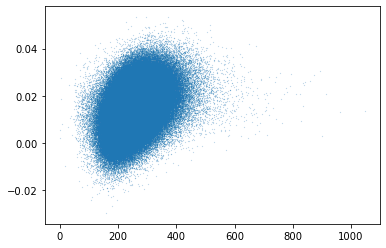

In [35]:
plt.scatter(X["PLT"],X["PLT_score"],s=.01)

In [87]:
p = "PLT"
cond = ~X[p].isnull() & ~X["%s_score" % p].isnull()
pearsonr(X.loc[cond,p],X.loc[cond,"%s_score" % p])

(0.3793031996333959, 0.0)

In [27]:
pearson_matrix = np.zeros((4,4))
for i, c_i in enumerate(["PLT","MPV","PDW","PCT"]):
    for j, c_j in enumerate(["PLT","MPV","PDW","PCT"]):
        X_ = X.loc[~X[c_i].isnull() & ~X[c_j+"_score"].isnull()]
        pearson_matrix[i,j] = pearsonr(X_[c_i],X_[c_j+"_score"])[0]

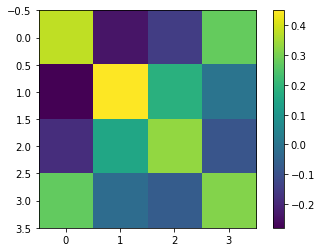

In [28]:
cm = plt.imshow(pearson_matrix)
plt.colorbar(cm)

In [29]:
print(scores.columns)

Index(['ADP_FIB', 'CRP_FIB', 'TRAP_FIB', 'PAR1_FIB', 'PAR4_FIB'], dtype='object')


In [88]:
for p in scores.columns:
    lm = LinearRegression().fit(X[scores_sys.columns],X[p])
    X[p+"_adj"] = X[p] - lm.predict(X[scores_sys.columns])

In [89]:
outcomes = ICD10_outcomes + ["has_mi","has_hbp","has_VT","has_stroke",
                             "has_phlebitis",
                             "has_ischaemic",
                             "has_DVT_curated","has_PE_curated",
                             "has_ischaemic_stroke","has_intracerebral_haemo"]

In [253]:
l = [p+"_adj" for p in scores.columns]

df = pd.DataFrame(index=outcomes)

for pheno in l:
    for c in outcomes:
        cond1 = X[pheno] < X[pheno].quantile(0.1)
        cond2 = X[pheno] > X[pheno].quantile(0.9)
        p_low = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[~cond1,c].mean())
        p_up = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[~cond2,c].mean())
        p_uplow = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[cond2,c].mean())
        p_lowup = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[cond1,c].mean())
        p_mann = mannwhitneyu(X.loc[X[c],pheno],X.loc[~X[c],pheno])[1]
        df.loc[c,pheno+"_low"] = p_low
        df.loc[c,pheno+"_up"] = p_up
        df.loc[c,pheno+"_uplow"] = p_uplow
        df.loc[c,pheno+"_lowup"] = p_lowup
        df.loc[c,pheno+"_mann"] = p_mann

In [254]:
mann = [c for c in df.columns if "_mann" in c and ("_FIB" in c or "TOTAL" in c)]
df[mann]

ADP_FIB_adj_mann  CRP_FIB_adj_mann  \
thrombophilia                         0.371027          0.343599   
VW_disease                            0.285384          0.112182   
factor_XI_deficiency                  0.022056          0.036677   
clotting_factors_deficiency           0.108156          0.312687   
unspec_coag_deffect                   0.486749          0.111203   
purpura                               0.170144          0.149117   
diverse_hameo                         0.225909          0.340109   
qualitative_platelet_defects          0.305754          0.197616   
thrombocytopenia                      0.431821          0.355703   
hypertension                          0.156861          0.312643   
angina_pectoris                       0.051702          0.323655   
acute_MI                              0.123387          0.165080   
subsequent_MI                         0.342568          0.479954   
other_ischaemic                       0.426290          0.442402   
chronic_ischaemic_heart               0.279884          0.036704   
cerebral_haemo                        0.102250          0.206765   
cerebral_infarction                   0.114025          0.111872   
occlusion_cerebral_arteries           0.078253          0.420919   
cerebral_stroke                       0.411833          0.102728   
cerebrovascular_unspecified           0.374642          0.197338   
artherosclerosis                      0.073914          0.069438   
arterial_embolism_thrombosis          0.256576          0.237176   
phlebitis                             0.109859          0.409161   
migraine                              0.128618          0.240778   
vaginal_bleeding                      0.441831          0.326388   
meta_haemo                            0.254358          0.373970   
meta_MI                               0.076421          0.137620   
meta_coag+                            0.144972          0.376615   
has_mi                                0.236391          0.046785   
has_hbp                               0.156793          0.403905   
has_VT                                0.383013          0.172283   
has_stroke                            0.329534          0.204560   
has_phlebitis                         0.405452          0.172468   
has_ischaemic                         0.310482          0.027458   
has_ischaemic_stroke                  0.186689          0.026137   
has_intracerebral_haemo               0.444840          0.476929   

                              TRAP_FIB_adj_mann  PAR1_FIB_adj_mann  \
thrombophilia                          0.492909           0.408093   
VW_disease                             0.135689           0.361750   
factor_XI_deficiency                   0.048858           0.049900   
clotting_factors_deficiency            0.017917           0.053334   
unspec_coag_deffect                    0.470382           0.464495   
purpura                                0.014957           0.091826   
diverse_hameo                          0.046628           0.384551   
qualitative_platelet_defects           0.253685           0.431474   
thrombocytopenia                       0.482910           0.426597   
hypertension                           0.198938           0.249874   
angina_pectoris                        0.449643           0.185756   
acute_MI                               0.005035           0.037121   
subsequent_MI                          0.477307           0.438298   
other_ischaemic                        0.293080           0.425541   
chronic_ischaemic_heart                0.014973           0.087921   
cerebral_haemo                         0.459548           0.079738   
cerebral_infarction                    0.091987           0.086525   
occlusion_cerebral_arteries            0.020726           0.059613   
cerebral_stroke                        0.489313           0.446002   
cerebrovascular_unspecified            0.223593           0.303807   
artherosclerosis                       0.10

## Violin plots

In [138]:
adj_phenos

['ADP_FIB_adj', 'CRP_FIB_adj', 'TRAP_FIB_adj', 'PAR1_FIB_adj', 'PAR4_FIB_adj']

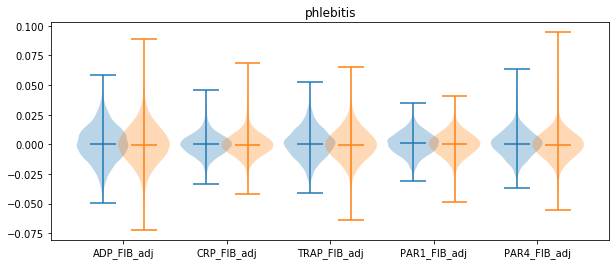

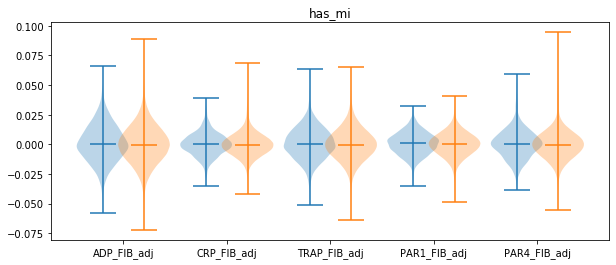

In [140]:
adj_phenos = [p+"_adj" for p in pheno_cols]
for c in ["phlebitis","has_mi"]:
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    
    stats_has = [X.loc[X[c],pheno].values for pheno in adj_phenos]
    stats_has_not = [X.loc[~X[c],pheno].values for pheno in adj_phenos]
    
    ax.violinplot(stats_has,np.arange(len(adj_phenos))-0.2,showmedians=True,)
    ax.violinplot(stats_has_not,np.arange(len(adj_phenos))+0.2,showmedians=True)
    
    ax.set_xticks(np.arange(len(adj_phenos)))
    ax.set_xticklabels(adj_phenos)
    
    ax.set_title(c)
        

## Survival analysis

In [90]:
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from datetime import datetime
from scipy.stats import chi2

In [91]:
# likelihood test, avec et sans les socres ADP & co
# Ajuster mesures en fonction de l'âge
# Isoler SNPs avec un vrai test

In [92]:
X["META_FIB"] = X[["ADP_FIB","CRP_FIB","PAR1_FIB","PAR4_FIB","TRAP_FIB"]].mean(axis=1)

  0%|          | 0/11 [00:00<?, ?it/s]

For has_hearing_issues, 1.88 percent of events occur before 55 years old


  0%|          | 0/11 [00:00<?, ?it/s]

For has_hearing_issues, 1.88 percent of events occur before 55 years old


  0%|          | 0/11 [00:00<?, ?it/s]

For has_hearing_issues, 1.88 percent of events occur before 55 years old


  0%|          | 0/11 [00:21<?, ?it/s]


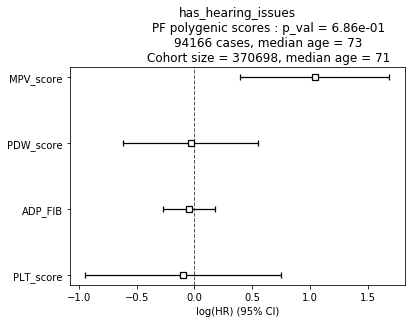

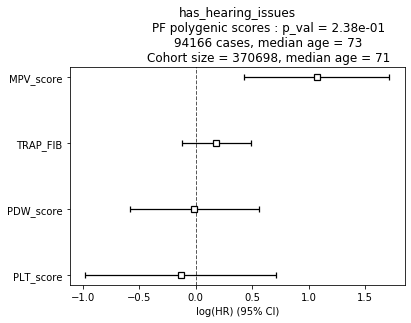

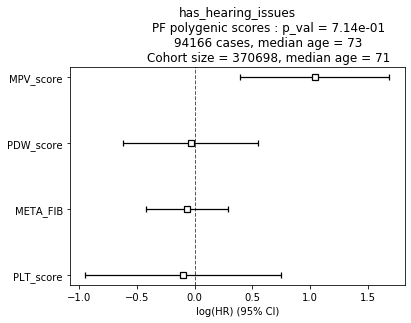

In [95]:
events = X.loc[~X.BIRTH.isnull()].copy()
events["AGE"] = (datetime.now() - events["BIRTH"]).dt.days // 365

events["MI_AGE"] = events["MI_AGE"].fillna(1000).astype(int)
events["STROKE_AGE"] = events["STROKE_AGE"].fillna(1000).astype(int)
events["VT_AGE"] = events["MI_AGE"].fillna(1000).astype(int)

for c in events.columns:
    if "_AGE" in c and events[c].dtype == "timedelta64[ns]":
        try:
            events[c] = pd.to_timedelta(events[c]).dt.days // 365
            events[c] = events[c].fillna(1000).astype(int)
        except Exception as e:
            print(e)
            print("Assume %s already in years" % c)

outcome_pairs = [("has_hearing_issues","AGE"),
                 ("has_VT","VT_AGE"),
                 ("has_DVT_curated","CURATED_DVT_AGE"),
                 ("has_PE_curated","CURATED_PE_AGE"),
                 ("has_phlebitis","PHLEBITIS_AGE"),
                 ("has_mi","MI_AGE"),
                 ("diverse_hameo","AGE"),
                 ("meta_haemo","AGE"),
                 ("has_hbp","HIGH_BP_AGE"),
                 #("has_stroke","STROKE_AGE"),
                 ("has_ischaemic","ISCHAEMIC_AGE"),
                 ("artherosclerosis","AGE"),
                 #("has_intracerebral_haemo","INTRACEREBRAL_HAEMO_AGE"),
                 #("has_ischaemic_stroke","ISCHAEMIC_STROKE_AGE"),
                ]
# STRATA : SMOKING, BMI ?

for score_cols in [["ADP_FIB"],["TRAP_FIB"],["META_FIB"]]:
    for pheno, age_col in tqdm(outcome_pairs):

        e = events.copy()
        e["min_T"] = e["AGE"]
        e.loc[e["min_T"] > e["DEATH_AGE"],"min_T"] = e.loc[e["min_T"] > e["DEATH_AGE"],"DEATH_AGE"]
        e.loc[e["min_T"] > e[age_col],"min_T"] = e.loc[e["min_T"] > e[age_col],age_col]
        e = e.loc[e.min_T >= 1]
        MIN_AGE = e.loc[e[pheno],"min_T"].quantile(0.03)
        print("For %s, %.2f percent of events occur before %d years old" % \
              (pheno,100*(e.loc[e[pheno],"min_T"] < MIN_AGE).mean(),MIN_AGE))
        e = e.loc[e["min_T"] >= MIN_AGE]

        #plt.figure()
        #plt.scatter(e["PCT"],e["MPV"]*e["PLT"])

        #after_recruitment = lambda delta: e["RECRUITMENT_AGE"] <= (e["min_T"] - delta)
        #if e.loc[after_recruitment(2),pheno].sum() > 1000:
        #    e = e.loc[after_recruitment(2)]
        #else:
        #    print("Must keep all people for %s" % pheno)

        basics = ["min_T",pheno]
        covars_1 = ["SEX"]
        #covars_1 += ["MPV","PDW","PLT"] #,"PCT" 
        covars_1 += ["MPV_score","PLT_score","PDW_score"] #"PCT_score"
        #cols_to_include += ["ADP_FIB_adj","CRP_FIB_adj","PAR1_FIB_adj","PAR4_FIB_adj","TRAP_FIB_adj"]
        #score_cols = ["TRAP_FIB"]#,"TRAP_FIB"]#["ADP_FIB","CRP_FIB","PAR1_FIB","PAR4_FIB","TRAP_FIB"]
        covars_2 = covars_1 + score_cols

        cols_to_include_1 = basics + covars_1
        cols_to_include_2 = basics + covars_2

        no_null_cond = e[cols_to_include_2].isnull().sum(axis=1) == 0
        e = e.loc[no_null_cond]
        #plt.figure()
        #plt.scatter(e["PLT"],quantile_transform(e[["PLT"]],output_distribution="normal",axis=0)[:,0])
        #e[covars_2] = quantile_transform(e[covars_2],output_distribution="normal",axis=0)

        pen_args = {"penalizer":0.,"l1_ratio":1.}
        fit_args = {"duration_col":"min_T","event_col":pheno,"strata":["SEX"],
                    "show_progress":False}#"step_size":.1,

        aft1 = CoxPHFitter(**pen_args)
        X_1 = e[cols_to_include_1].copy()
        aft1.fit(X_1, **fit_args) 
        #aft1.check_assumptions(X_1)
        
        aft2 = CoxPHFitter(**pen_args)
        X_2 = e[cols_to_include_2].copy()
        aft2.fit(X_2, **fit_args)

        #plt.figure()
        #plt.scatter(X_2["PCT"]-X_2["PCT"].min(),(X_2["PLT"]-X_2["PLT"].min())*(X_2["MPV"]-X_2["MPV"].min()),s=.1)

        #plt.figure()
        #best_col = aft2.summary.loc[aft2.summary.p == aft2.summary.p.min()].index[0]
        #plt.hist(e[best_col],density=True,alpha=.5,label="Whole population",bins=30)
        #plt.hist(e.loc[e[pheno],best_col],density=True,alpha=.5,label="People with %s" % pheno,bins=30)
        #plt.legend()
        #plt.title(best_col)

        plt.figure()
        aft2.plot()

        LL_without = aft1.log_likelihood_
        LL_with = aft2.log_likelihood_
        Delta_LL = LL_with-LL_without
        p_val = 1.-chi2(len(score_cols)).cdf(2*Delta_LL)

        plt.title("%s\n\
                PF polygenic scores : p_val = %.2e\n\
                %d cases, median age = %d\n\
                Cohort size = %d, median age = %d" % (pheno, p_val,
                            X_1[pheno].sum(),X_1.loc[X_1[pheno],"min_T"].median(),
                            X_1.shape[0],X_1["min_T"].median()))
        break

In [96]:
pearsonr(X["AGE"],["MPV"])

ValueError: array must not contain infs or NaNs

In [ ]:
# IF small step size (0.1) and only score_col is ADP_FIB, ADP_FIB always has a tendency to increase the risk (good sign)
# Tried with TRAP_FIB, same !
# Trying with both together and small step size (0.05)

In [123]:
pca = PCA()
pca.fit(X_2[["ADP_FIB","CRP_FIB","PAR1_FIB","PAR4_FIB","TRAP_FIB"]])

PCA()

In [125]:
pca.explained_variance_ratio_

array([0.81820492, 0.11440965, 0.04098757, 0.01471609, 0.01168177])

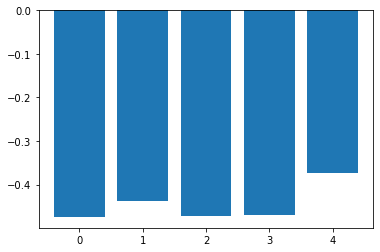

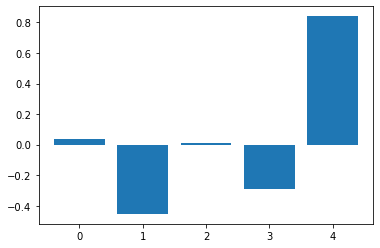

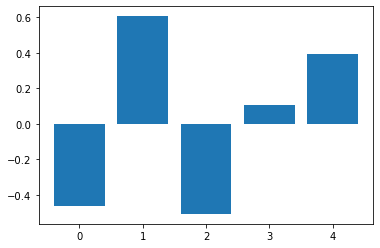

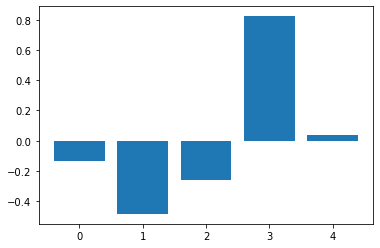

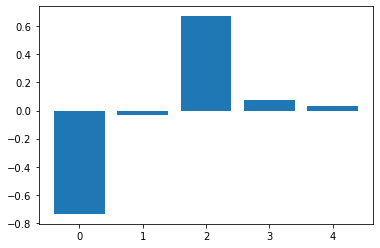

In [127]:
for i in range(5):
    plt.figure()
    plt.bar(np.arange(5),pca.components_[i])

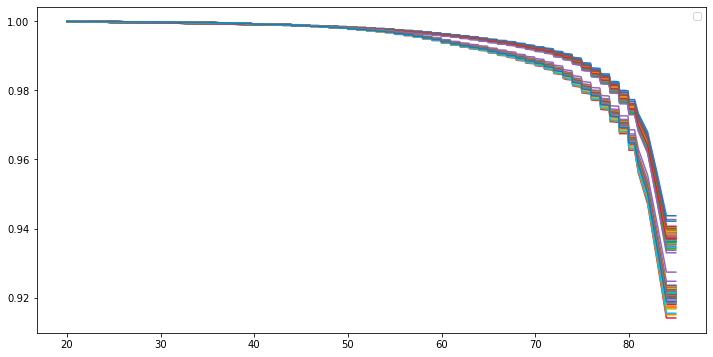

In [122]:
aft2.predict_survival_function(X_2.loc[:200]).plot(figsize=(12,6))
plt.legend([])

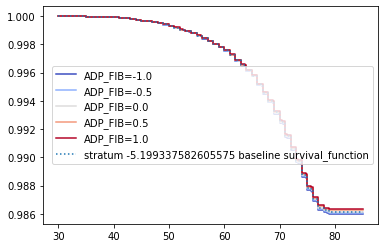

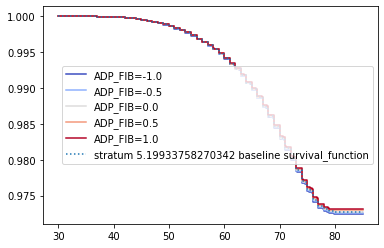

In [36]:
aft2.plot_partial_effects_on_outcome(covariates='ADP_FIB', values=[-1,-0.5,0.,.5,1.], cmap='coolwarm')

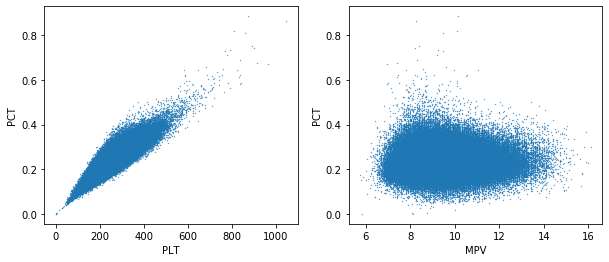

In [59]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.scatter(ukbb["PLT"],ukbb["PCT"],s=.1)
ax1.set_ylabel("PCT")
ax1.set_xlabel("PLT")
ax2 = fig.add_subplot(122)
ax2.scatter(ukbb["MPV"],ukbb["PCT"],s=.1)
ax2.set_ylabel("PCT")
ax2.set_xlabel("MPV");

KeyError: 'covariate `PCT` is not present in the original dataset'

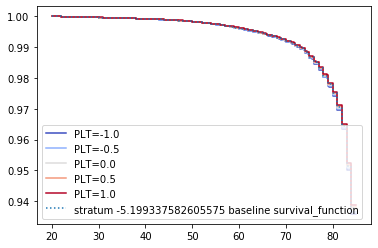

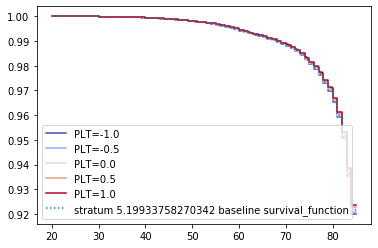

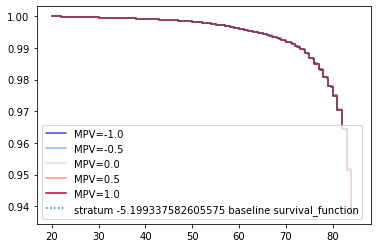

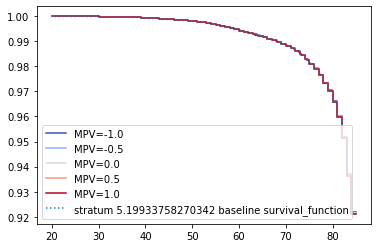

In [114]:
aft2.plot_partial_effects_on_outcome(covariates='PLT', values=[-1,-0.5,0.,.5,1.], cmap='coolwarm')
aft2.plot_partial_effects_on_outcome(covariates='MPV', values=[-1,-0.5,0.,.5,1.], cmap='coolwarm')
aft2.plot_partial_effects_on_outcome(covariates='PCT', values=[-1,-0.5,0.,.5,1.], cmap='coolwarm')

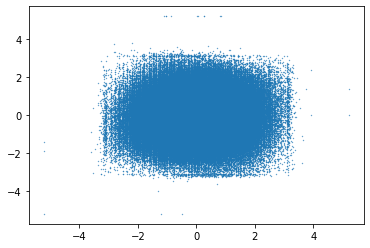

In [104]:
plt.scatter(e["MPV"],e["PCT"],s=.1)

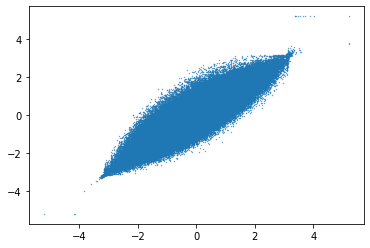

In [103]:
plt.scatter(e["PLT"],e["PCT"],s=.1)

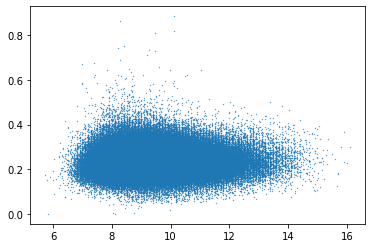

In [106]:
plt.scatter(ukbb["MPV"],ukbb["PCT"],s=.1)

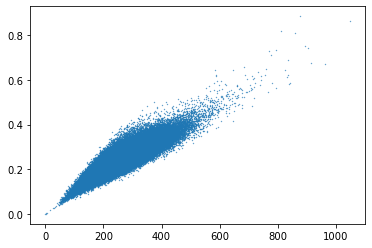

In [107]:
plt.scatter(ukbb["PLT"],ukbb["PCT"],s=.1)

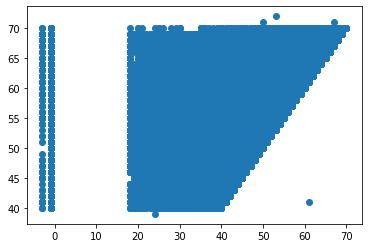

In [98]:
# Strange, all patients with high bp were recruited after their diagnostic...
plt.scatter(X["HIGH_BP_AGE"],X["RECRUITMENT_AGE"])

TypeError: '>=' not supported between instances of 'NaTType' and 'int'

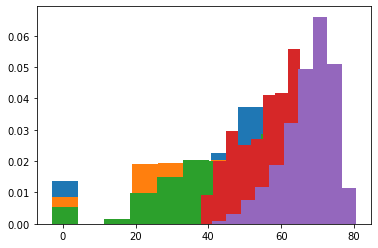

In [262]:
for c in X.columns:
    if "AGE" in c:
        plt.hist(X[c],density=True,label=c)
        

In [ ]:
plt.hist

(array([  19.,  100.,  227.,  346.,  432.,  730., 1076., 1183.,  739.,
         123.]),
 array([42. , 45.8, 49.6, 53.4, 57.2, 61. , 64.8, 68.6, 72.4, 76.2, 80. ]),
 <a list of 10 Patch objects>)

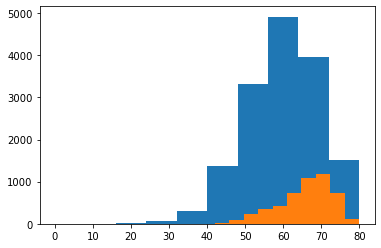

In [241]:
plt.hist(ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"])
plt.hist(events.loc[events.MI_AGE < 1000,"MI_AGE"])

# Unused

## interprétation des prédicteurs, par phénotype.

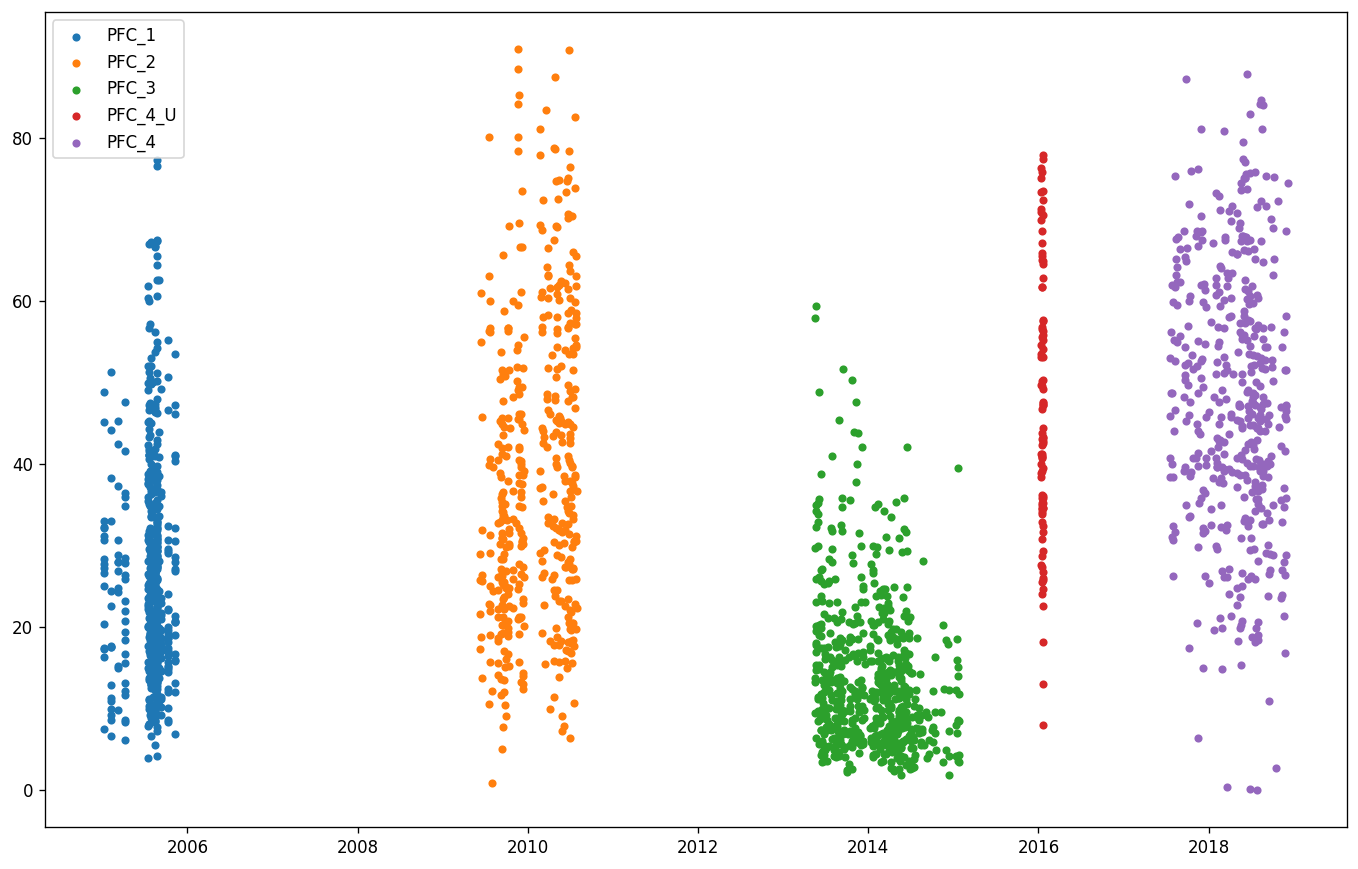

In [329]:
plt.figure(figsize=(14,9),dpi=120)
for project in all_pheno_df.PROJECT.unique():
    cond = all_pheno_df.PROJECT == project
    plt.scatter(all_pheno_df.loc[cond,"DATE"],all_pheno_df.loc[cond,"ADP_FIB_1"],label=project,s=15)
plt.legend()

In [13]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sample(10)

PROJECT SAMPLE_ID       DATE      TIME  REST_FIB_1  REST_FIB_2  \
854   PFC_2      1417 2010-06-25  10:41:42        6.46        5.35   
638   PFC_2       722 2009-09-22  13:42:41        2.24        1.11   
871   PFC_2       522 2010-07-05  08:08:35        2.91        1.51   
693   PFC_2       787 2009-11-19  08:22:50       26.21        8.90   
884   PFC_2      1294 2010-07-13  11:15:52        3.74        5.63   
814   PFC_2       875 2010-05-21  08:37:10        2.25        2.60   
935   PFC_2      1447 2010-09-07  11:56:41        4.87        4.03   
862   PFC_2       585 2010-06-29  11:01:35        1.51        0.68   
674   PFC_2       520 2009-10-27  11:28:14        3.01        3.61   
701   PFC_2       658 2009-11-24  10:41:57        5.10        2.67   

     REST_PSEL_1  REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  ...  PAR1_PSEL_1  \
854         8.85        10.43      53.47      67.78  ...          NaN   
638         3.52         2.65      12.09      11.77  ...          NaN   
871         8.51         9.62      24.52      36.83  ...          NaN   
693         6.32         6.96      84.17      82.67  ...          NaN   
884        12.34        11.92      53.50      59.37  ...          NaN   
814         7.10         6.53      28.58      34.27  ...          NaN   
935         8.17         6.02      25.81      26.60  ...          NaN   
862         9.05        10.09      19.74      28.03  ...          NaN   
674         6.92         7.23      25.95      30.27  ...          NaN   
701         3.66         3.92      40.56      36.76  ...          NaN   

     PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
854          NaN         NaN         NaN          NaN          NaN   
638          NaN         NaN         NaN          NaN          NaN   
871          NaN         NaN         NaN          NaN          NaN   
693          NaN         NaN         NaN          NaN          NaN   
884          NaN         NaN         NaN          NaN          NaN   
814          NaN         NaN         NaN          NaN          NaN   
935          NaN         NaN         NaN          NaN          NaN   
862          NaN         NaN         NaN          NaN          NaN   
674          NaN         NaN         NaN          NaN          NaN   
701          NaN         NaN         NaN          NaN          NaN   

     TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
854         NaN         NaN          NaN          NaN  
638         NaN         NaN          NaN          NaN  
871         NaN         NaN          NaN          NaN  
693         NaN         NaN          NaN          NaN  
884         NaN         NaN          NaN          NaN  
814         NaN         NaN          NaN          NaN  
935         NaN         NaN          NaN          NaN  
862         NaN         NaN          NaN          NaN  
674         NaN         NaN          NaN          NaN  
701         NaN         NaN          NaN          NaN  

[10 rows x 28 columns]

In [22]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sort_values("DATE").head(15)[["PROJECT","SAMPLE_ID","DATE"]]

PROJECT SAMPLE_ID       DATE
266   PFC_2      1133 2005-08-15
311   PFC_2       534 2005-08-17
312   PFC_2       610 2005-08-17
313   PFC_2       640 2005-08-17
314   PFC_2       643 2005-08-17
315   PFC_2       723 2005-08-17
316   PFC_2       750 2005-08-17
317   PFC_2       921 2005-08-17
318   PFC_2      1154 2005-08-17
515   PFC_2       779 2009-01-10
516   PFC_2      1013 2009-01-10
517   PFC_2      1161 2009-01-10
524   PFC_2      1102 2009-01-12
523   PFC_2      1045 2009-01-12
522   PFC_2      1007 2009-01-12

In [24]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sort_values("SAMPLE_ID")[["SAMPLE_ID","DATE"]]

SAMPLE_ID       DATE
597      1001 2009-08-27
545      1003 2009-06-16
892      1005 2010-07-20
522      1007 2009-01-12
589      1008 2009-08-26
..        ...        ...
641       992 2009-09-22
728       994 2010-01-07
793       995 2010-04-30
719       996 2009-12-15
945       999 2010-11-03

[450 rows x 2 columns]

## Train on all and save

In [26]:
agg_cols

['high_10_0_wb',
 'high_10_1_wb',
 'high_20_0_wb',
 'high_20_1_wb',
 'high_50_0_wb',
 'high_50_1_wb',
 'low_10_0_wb',
 'low_10_1_wb',
 'low_20_0_wb',
 'low_20_1_wb',
 'low_50_0_wb',
 'low_50_1_wb',
 'mean_0_wb',
 'mean_1_wb',
 'ratio_10_wb',
 'ratio_20_wb',
 'mean_std_0_wb',
 'mean_std_1_wb',
 'mode_0_wb',
 'mode_1_wb',
 'S_0_wb',
 'S_1_wb',
 'iqr_0_wb',
 'iqr_1_wb',
 'corr_wb']

In [27]:
X_info_Y.mean()

high_10_0_wb       0.042774
high_10_1_wb       0.052301
high_20_0_wb       0.054351
high_20_1_wb       0.048367
high_50_0_wb       0.050946
high_50_1_wb       0.051891
low_10_0_wb        0.006725
low_10_1_wb        0.011643
low_20_0_wb        0.000936
low_20_1_wb        0.000094
low_50_0_wb       -0.028676
low_50_1_wb        0.031979
mean_0_wb          0.058504
mean_1_wb          0.030464
ratio_10_wb       -0.064768
ratio_20_wb       -0.066926
mean_std_0_wb      0.041217
mean_std_1_wb      0.032689
mode_0_wb          0.047735
mode_1_wb         -0.003512
S_0_wb            -0.025476
S_1_wb            -0.011358
iqr_0_wb           0.119144
iqr_1_wb          -0.053234
corr_wb            0.008266
MPV_wb             0.037012
PCT_wb             0.014205
PDW_wb             0.126897
PLT_wb             0.053986
PLT_count        259.833021
IPF                3.702251
is_PLT_F           1.000000
MPV               10.340713
PDW               11.979174
PCT                0.260994
FIB               -0

## Check dates of PFC2

In [303]:
pfc2_dates = pd.read_excel("%s/metadata_PF/EE2 Study_Platelet Function_KD_early file.xlsx" % data_dir)
pfc2_dates.SampleID = pfc2_dates.SampleID.astype(str)

In [306]:
all_pheno_df

PROJECT     SAMPLE_ID      DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
0      PFC_1  100010100138  08/01/05        2.22        2.91          NaN   
1      PFC_1  100010100139  08/01/05        3.22        2.84          NaN   
2      PFC_1  100010100140  08/01/05        3.52        3.28          NaN   
3      PFC_1  100010100141  08/01/05        2.19        2.93          NaN   
4      PFC_1  100010100142  08/01/05        3.60        3.68          NaN   
...      ...           ...       ...         ...         ...          ...   
2137   PFC_4        C1A2PI  28/11/18        0.22        0.36        16.63   
2138   PFC_4        C1A2RE  29/11/18        0.60        0.78        16.23   
2139   PFC_4        C1A2TA  29/11/18        0.32        0.18        11.40   
2140   PFC_4        C1A2X2  30/11/18        0.61        0.37         9.58   
2141   PFC_4        C1A32N  05/12/18        1.39        1.48        12.25   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR1_PSEL_1  \
0             NaN      30.74      28.15      51.16  ...          NaN   
1             NaN      27.77      25.39      72.27  ...          NaN   
2             NaN      32.35      28.99      47.34  ...          NaN   
3             NaN      27.31      33.07      60.62  ...          NaN   
4             NaN       7.52       8.47      28.44  ...          NaN   
...           ...        ...        ...        ...  ...          ...   
2137        17.23      46.53      45.68      11.31  ...        52.34   
2138        15.65      58.13      57.92      52.53  ...        62.44   
2139        10.59      47.23      41.39       1.66  ...        81.64   
2140         8.33      68.61      67.27      42.16  ...        65.87   
2141        13.04      74.45      76.61      62.99  ...        79.20   

      PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
0             NaN         NaN         NaN          NaN          NaN   
1             NaN         NaN         NaN          NaN          NaN   
2             NaN         NaN         NaN          NaN          NaN   
3             NaN         NaN         NaN          NaN          NaN   
4             NaN         NaN         NaN          NaN          NaN   
...           ...         ...         ...          ...          ...   
2137        52.25       10.62        9.70        51.81        51.21   
2138        68.03       19.76       17.40        67.39        65.58   
2139        81.52       11.15       12.23        50.49        50.53   
2140        66.92       32.51       34.66        58.86        59.99   
2141        79.01       37.87       39.69        72.81        75.02   

      TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
0            NaN         NaN          NaN          NaN  
1            NaN         NaN          NaN          NaN  
2            NaN         NaN          NaN          NaN  
3            NaN         NaN          NaN          NaN  
4            NaN         NaN          NaN          NaN  
...          ...         ...          ...          ...  
2137        0.26        0.50        23.14        23.30  
2138        0.92        0.98        18.05        20.74  
2139        1.78        2.72        27.51        33.64  
2140        6.26        5.92        18.91        19.24  
2141        6.17        6.08        36.30        36.20  

[2142 rows x 27 columns]

In [317]:
print(pfc2_dates.shape)
print(all_pheno_df.shape)

m.DATE = pd.to_datetime(m.DATE, format="%d/%m/%y")
print(m.shape)

(450, 3)
(2142, 27)
(450, 30)


Text(0, 0.5, 'Pheno file date')

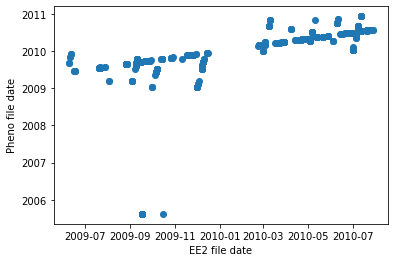

In [320]:
plt.figure()
plt.scatter(m.Date,m.DATE)
plt.xlabel("EE2 file date")
plt.ylabel("Pheno file date")

# Not yet useful

Check if we have the genotype

In [23]:
pfc_4_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/Genomes/S159_UKBBAffy_v1.0.fam"
gen_ids = pd.read_csv(pfc_4_path, delim_whitespace=True,header=-1)[1].tolist()
print("%d genotypes available for PFC_4 cohort, in %s" % (len(gen_ids),pfc_4_path))

nemunas_data_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/Nemunas_data"
matching = pd.read_csv("%s/metadata_PF/Genotyping" % nemunas_data_path,sep="\t")
matching = matching.dropna(how="all",axis=1)
matching = matching.rename(columns={"sampleid of tube":"tube_sample_id",
                                   "Proper Sample ID":"proper_sample_id"})

matching.loc[matching.SAMPLE_ID.isnull(),"SAMPLE_ID"] = \
    matching.loc[matching.SAMPLE_ID.isnull(),"tube_sample_id"]



ValueError: Passing negative integer to header is invalid. For no header, use header=None instead

In [17]:
matching.loc[matching.PROJECT == "PFC4"]

PROJECT SAMPLE_ID RackID     SampleID_2 proper_sample_id Blueprint_ID  \
1919    PFC4    C18967    NaN     S15904007E              NaN          NaN   
1920    PFC4    C18975    NaN     S15901120R              NaN          NaN   
1921    PFC4    C189DU    NaN     S15904639R              NaN          NaN   
1922    PFC4    C189KG    NaN     S15905004N              NaN          NaN   
1923    PFC4    C189UX    NaN  ]C1S15903404Z              NaN          NaN   
1924    PFC4    C189WT    NaN  ]C1S15904414X              NaN          NaN   
1925    PFC4    C18A0F    NaN  ]C1S15903612A              NaN          NaN   
1926    PFC4    C18A1D    NaN  ]C1S15905175Z              NaN          NaN   
1927    PFC4    C18A47    NaN  ]C1S15903640F              NaN          NaN   
1928    PFC4    C18A63    NaN  ]C1S15904638Q              NaN          NaN   
1929    PFC4    C18AFM    NaN  ]C1S15904873W              NaN          NaN   
1930    PFC4    C18AGK    NaN  ]C1S15901392M              NaN          NaN   
1931    PFC4    C18AKC    NaN  ]C1S15900253Z              NaN          NaN   
1932    PFC4    C18AM8    NaN  ]C1S15903975V              NaN          NaN   
1933    PFC4    C18ASX    NaN  ]C1S15902531A              NaN          NaN   
1934    PFC4    C18AWP    NaN  ]C1S15903863Y              NaN          NaN   
1935    PFC4    C18AXN    NaN            NaN              NaN          NaN   
1936    PFC4    C18B19    NaN            NaN              NaN          NaN   
1937    PFC4    C18B27    NaN            NaN              NaN          NaN   
1938    PFC4    C18B43    NaN  ]C1S15903966K              NaN          NaN   
1939    PFC4    C18BBQ    NaN  ]C1S15902081L              NaN          NaN   
1940    PFC4    C18BFI    NaN  ]C1S15905079V              NaN          NaN   
1941    PFC4    C18BQX    NaN  ]C1S15903676V              NaN          NaN   
1942    PFC4    C18BST    NaN  ]C1S15901294F              NaN          NaN   
1943    PFC4    C18BTR    NaN  ]C1S15904313M              NaN          NaN   
1944    PFC4    C18BWL    NaN  ]C1S15902247R              NaN          NaN   
1945    PFC4    C18BXJ    NaN  ]C1S15903412H              NaN          NaN   
1946    PFC4    C18C15    NaN  ]C1S15901164P              NaN          NaN   
1947    PFC4    C18C31    NaN  ]C1S15900269R              NaN          NaN   
1948    PFC4    C18C8S    NaN  ]C1S15901209N              NaN          NaN   
...      ...       ...    ...            ...              ...          ...   
2387    PFC4    C1A09L    NaN  ]C1S15900045Y              NaN          NaN   
2388    PFC4    C1A0BH    NaN  ]C1S15903270D              NaN          NaN   
2389    PFC4    C1A0NU    NaN  ]C1S15904526T              NaN          NaN   
2390    PFC4    C1A0PQ    NaN  ]C1S15901136J              NaN          NaN   
2391    PFC4    C1A0SK    NaN  ]C1S15904451M              NaN          NaN   
2392    PFC4    C1A0UG    NaN  ]C1S15904366V              NaN          NaN   
2393    PFC4    C1A0Y8    NaN  ]C1S15900144F              NaN          NaN   
2394    PFC4    C1A10Z    NaN  ]C1S15900752R              NaN          NaN   
2395    PFC4    C1A14R    NaN  ]C1S15902643X              NaN          NaN   
2396    PFC4    C1A15P    NaN  ]C1S15903770X              NaN          NaN   
2397    PFC4    C1A1AF    NaN  ]C1S15901580R              NaN          NaN   
2398    PFC4    C191D9    NaN  ]C1S15903053S              NaN          NaN   
2399    PFC4    C1A1F5    NaN  ]C1S15905065E              NaN          NaN   
2400    PFC4    C1A1JY    NaN  ]C1S15904328D              NaN          NaN   
2401    PFC4    C1A1Y4    NaN  ]C1S15900245Q              NaN          NaN   
2402    PFC4    C1A21T    NaN  ]C1S15904664T              NaN          NaN   
2403    PFC4    C1A22R    NaN  ]C1S15900803X              NaN          NaN   
2404    PFC4    C1A25L    NaN  ]C1S15903560T              NaN          NaN   
2405    PFC4    C1A27H    NaN  ]C1S15903921L              NaN          NaN   
2406    PFC4    C1A28F    N

In [18]:
pheno_df_w_gen = pd.merge(pheno_df,
                          matching[["SAMPLE_ID","tubeid"]],
                          left_on="SAMPLE_ID",
                          right_on="SAMPLE_ID",how="inner")
pheno_df_w_gen["has_genotype"] = pheno_df_w_gen.tubeid.isin(gen_ids)
print("%d samples for which we have FC measurement and WB also have genotypes" % (pheno_df_w_gen["has_genotype"].sum()))

424 samples for which we have FC measurement and WB also have genotypes


In [20]:
pheno_df_w_gen[["SAMPLE_ID","tubeid","has_genotype"]].to_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/summaries/wb_fc.csv",index=False)